# Задание, импорт библиотек

1. Познакомьтесь с данными.
2. Осуществите предобработку данных.
    - 2.1 Приведите заголовки к удобному виду.
    - 2.2 Проверьте типы данных.
    - 2.3 Обработайте пропуски.
    - 2.4 Проверьте наличие дубликатов.
    - 2.5 Исключите нулевые значения в выручке для дальнейшего исследования. 
3. Исследовательский анализ данных:
     - 3.1 Создайте отчет о динамике продаж (выручке). Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.
     - 3.2 Исследуйте выручку, примите решение об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.
     - 3.3 Исследуйте сезонность продаж. Дополнительно проверьте гипотезу о том, что выручка от продаж осенью и зимой отличается. Исследуйте выручку и число продаж по месяцам, проверьте корреляцию.
     - 3.4 Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверьте гипотезу о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительно разбейте клиентов минимум на три группы.
     - 3 .5  Определите топ-10 популярных направлений перелета (город-город) отдельно для ВМЛ и МВЛ. Изучите выручку для этих направлений. Для этого добавьте в датасет сведения о городах, используя данные из датасета:
     https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
     - 3.6 Определите есть ли зависимость выручки от других признаков. Постройте матрицу корреляций.

Каждый пункт исследования сопроводите выводами.


In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
from warnings import simplefilter
from scipy.integrate import quad
from numpy import inf
from math import e 
from math import pi
import folium 

In [2]:
simplefilter(action='ignore', category=FutureWarning)

# Оглавление

## <a class="anchor" id="0"></a>Навигация
1. [Предобработка данных](#1)
    * [Знакомство с данными](#2)
    * [Обработка пропусков](#3)
    * [Удаление строк с нулевой выручкой](#4)
    * [Удаление дубликатов](#5)
    * [Преобразование столбцов](#6)
    * [Результат обработки данных](#7)         
3. [Исследовательский анализ данных](#8)
    * [Настройки визуализации](#9)
    * [Динамика продаж](#10)
        * [Динамика продаж за год](#11)
        * [Динамика продаж про дням  недели](#12)
        * [Детализация динамики продаж](#13)
    * [Исследование выручки](#14)
        * [Отсечение выручки](#15)
        * [Распределение выручки](#16)
        * [Проверка на соответствие теоретическим распределениям](#17)
        * [Преобразование данных к нормальному распределению](#18)
    * [Исследование сезонности продаж](#19)
        * [Столбчатая диаграмма выручки по сезонам](#20)
        * [Проверка различий между осенью и зимой](#21)
        * [Различия между выручкой по месяцам](#22)
    * [Выручка от билетов, купленных за разное время до даты отлета](#23)
        * [Разделение на группы](#24)
        * [Тест Манна-Уитни](#25)
    * [Самые популярные направления перелета](#26)
        * [Создание справочника](#27)
        * [Рейтинг направлений перелета](#28)
        * [Самые частые направления на карте](#29)
        * [Исследование выручки по направлениям](#30)
    * [Матрица корреляций](#31)

# Предобработка данных <a class="anchor" id="1"></a>

#### Знакомство с данными <a class="anchor" id="2"></a>

In [3]:
# запишем данные из файла в DataFrame df
df = pd.read_csv('air_data.csv', sep=';', parse_dates=[0, 1], date_format='%Y-%m-%d %H:%M:%S')

In [4]:
df

ISSUE_DATE FLIGHT_DATE_LOC PAX_TYPE  REVENUE_AMOUNT ORIG_CITY_CODE  \
0     2021-12-07      2022-01-11       AD             200            MOW   
1     2021-12-31      2022-01-03       AD             610            UUS   
2     2021-11-28      2022-01-04       AD             390            KGD   
3     2021-12-08      2022-01-05       AD             190            VOZ   
4     2021-12-08      2022-01-12       AD             190            MOW   
...          ...             ...      ...             ...            ...   
49995 2022-06-11      2022-06-22      CHD             480            MOW   
49996 2022-06-06      2022-06-20       AD             270            LED   
49997 2022-06-26      2022-06-29       AD             230            MOW   
49998 2022-06-26      2022-06-28       AD             270            KZN   
49999 2022-06-09      2022-06-25       AD             260            AER   

      DEST_CITY_CODE ROUTE_FLIGHT_TYPE FFP_FLAG SALE_TYPE  
0                KGD               ВВЛ      NaN    ONLINE  
1                OVB               ВВЛ      NaN   OFFLINE  
2                MOW               ВВЛ      FFP    ONLINE  
3                MOW               ВВЛ      NaN    ONLINE  
4                KRR               ВВЛ      FFP   OFFLINE  
...              ...               ...      ...       ...  
49995            OMS               ВВЛ      NaN    ONLINE  
49996            MOW               ВВЛ      NaN   OFFLINE  
49997            KZN               ВВЛ      FFP    ONLINE  
49998            MOW               ВВЛ      NaN   OFFLINE  
49999            MOW               ВВЛ      FFP    ONLINE  

[50000 rows x 9 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ISSUE_DATE         50000 non-null  datetime64[ns]
 1   FLIGHT_DATE_LOC    50000 non-null  datetime64[ns]
 2   PAX_TYPE           50000 non-null  object        
 3   REVENUE_AMOUNT     50000 non-null  int64         
 4   ORIG_CITY_CODE     49998 non-null  object        
 5   DEST_CITY_CODE     49999 non-null  object        
 6   ROUTE_FLIGHT_TYPE  50000 non-null  object        
 7   FFP_FLAG           19398 non-null  object        
 8   SALE_TYPE          50000 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 3.4+ MB


#### Обработка пропусков <a class="anchor" id="3"></a>

Почти все столбцы не содержат пустых значений, кроме столбцов ORIG_CITY_CODE (2 пропуска), DEST_CITY_CODE (1 пропуск), FFP_FLAG (примерно 30 тыс. пропусков).     
* 2 из 50 тыс. - это незначительное количество, скорее всего, можно просто удалить две строки.      
* А в столбце FFP_FLAG такое количество пропусков, возможно, объясняется тем, что в этом столбце отметка стоит только при участии в программе лояльности, иначе пропуск. Т.е. в данном столбце, возможно, пропуски просто несут смысл неучастия в программе лояльности, а не отсутсвия информации в принципе.

In [6]:
df['FFP_FLAG'].unique()

array([nan, 'FFP'], dtype=object)

Похоже, что так и есть, фактически в столбце два значения - 1 и 0. Таким образом, с пропусками в этом столбце ничего делать не будем.    
Посмотрим на пропуски в оставшихся двух столбцах.

In [7]:
df[df['ORIG_CITY_CODE'].isnull()]

ISSUE_DATE FLIGHT_DATE_LOC PAX_TYPE  REVENUE_AMOUNT ORIG_CITY_CODE  \
2020 2022-02-17      2022-03-22       AD             440            NaN   
8100 2022-05-02      2022-05-11       AD             440            NaN   

     DEST_CITY_CODE ROUTE_FLIGHT_TYPE FFP_FLAG SALE_TYPE  
2020            KHV               МВЛ      NaN    ONLINE  
8100            KHV               МВЛ      NaN   OFFLINE

Можно попробовать восстановить этот пропуск, если поискать похожие строки.

In [8]:
df.query('REVENUE_AMOUNT == 440 & DEST_CITY_CODE == "KHV" & ROUTE_FLIGHT_TYPE == "МВЛ"')

ISSUE_DATE FLIGHT_DATE_LOC PAX_TYPE  REVENUE_AMOUNT ORIG_CITY_CODE  \
2020 2022-02-17      2022-03-22       AD             440            NaN   
8100 2022-05-02      2022-05-11       AD             440            NaN   

     DEST_CITY_CODE ROUTE_FLIGHT_TYPE FFP_FLAG SALE_TYPE  
2020            KHV               МВЛ      NaN    ONLINE  
8100            KHV               МВЛ      NaN   OFFLINE

Таких же строк не нашлось, поэтому восстанавливать ничего не будем. 

In [9]:
df = df.drop(labels = [2020, 8100], axis = 0)

In [10]:
df[df['DEST_CITY_CODE'].isnull()]

ISSUE_DATE FLIGHT_DATE_LOC PAX_TYPE  REVENUE_AMOUNT ORIG_CITY_CODE  \
47582 2022-05-13      2022-07-28       AD             440            KHV   

      DEST_CITY_CODE ROUTE_FLIGHT_TYPE FFP_FLAG SALE_TYPE  
47582            NaN               МВЛ      NaN   OFFLINE

In [11]:
df = df.drop(labels = [47582], axis = 0)

#### Удаление строк с нулевой выручкой <a class="anchor" id="4"></a>

In [12]:
# Удалим строки с нулевым значением выручки
df = df[df['REVENUE_AMOUNT'] != 0]

#### Удаление дубликатов <a class="anchor" id="5"></a>

Почему не ищем скрытые дубликаты?     
Потому что отличие между строками хотя бы по одному столбцу (даже если все оставшиеся поля совпали) говорит о том, что это разные покупки, т.е. у нас пока нет оснований считать, что это могут быть скрытые дубликаты, разве что мы достоверно будем знать об ошибках при внесении данных.

In [13]:
df = df.drop_duplicates().reset_index(drop=True)

#### Преобразование столбцов <a class="anchor" id="6"></a>

Проверим, некоторые столбцы на наличие мусорных значений. Столбцы с типами (пассажиров, машрута, покупки) должны содержать только несколько конкретных значений.

In [14]:
print(df['PAX_TYPE'].unique(), df['ROUTE_FLIGHT_TYPE'].unique(), df['SALE_TYPE'].unique())

['AD' 'CHD' 'INF'] ['ВВЛ' 'МВЛ'] ['ONLINE' 'OFFLINE']


Все в порядке! Мусорных значений нет.   
Тогда можно заменить эти значения на численные (+ столбец про лояльность!). 

In [15]:
# Для пассажиров система следующая -> Взрослый? 1 = да, 0 = нет, -1 = неизвестно. 
df['PAX_TYPE'].replace(['AD', 'CHD', 'INF'], [1, 0, -1], inplace=True)
# Для перелета -> Это внутренний рейс? 1 = да, 0 = нет.
df['ROUTE_FLIGHT_TYPE'].replace(['ВВЛ', 'МВЛ'], [1, 0], inplace=True)
# Для покупки -> Покупка сделана онлайн? 1 = да, 0 = нет.
df['SALE_TYPE'].replace(['ONLINE', 'OFFLINE'], [1, 0], inplace=True)
# Для программы лояльности -> Участвует ли покупатель в программе лояльности? 1 = да, 0 = нет.
df['FFP_FLAG'].replace('FFP', 1, inplace=True)
df['FFP_FLAG'] = df['FFP_FLAG'].fillna(0)
df['FFP_FLAG'] = df['FFP_FLAG'].astype('int')

In [16]:
print(df['PAX_TYPE'].unique(), df['ROUTE_FLIGHT_TYPE'].unique(), df['SALE_TYPE'].unique(), df['FFP_FLAG'].unique())

[ 1  0 -1] [1 0] [1 0] [0 1]


In [17]:
# зададим столбцам имена более удобные и короткие
df.columns = ['purchase_date', 'flight_date', 'adult',
              'revenue', 'airport_from', 'airport_to',
              'local', 'loyalty', 'online']

#### Результат обработки данных <a class="anchor" id="7"></a>

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49362 entries, 0 to 49361
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   purchase_date  49362 non-null  datetime64[ns]
 1   flight_date    49362 non-null  datetime64[ns]
 2   adult          49362 non-null  int64         
 3   revenue        49362 non-null  int64         
 4   airport_from   49362 non-null  object        
 5   airport_to     49362 non-null  object        
 6   local          49362 non-null  int64         
 7   loyalty        49362 non-null  int32         
 8   online         49362 non-null  int64         
dtypes: datetime64[ns](2), int32(1), int64(4), object(2)
memory usage: 3.2+ MB


Итого:   
* Пропуски обработаны;
* Удалены дубликаты;
* Типы столбцов правильные.

[Вернуться к навигации](#0)

# Исследовательский анализ данных <a class="anchor" id="8"></a>

#### Настройки визуализации <a class="anchor" id="9"></a>

In [19]:
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (13, 6)

In [20]:
big_palette = ['#ffa943', '#ffd61c', '#f0ff4c', '#a6ff82',
               '#55ffa0', '#3dffe8', '#41afff', '#786cff',
               '#b98eff', '#fb50ff', '#ff579d', '#fc3535']
small_palette = ['#ffa943', '#ffd61c', '#a6ff82',
               '#55ffa0', '#3dffe8', '#786cff',
               '#b98eff', '#fb50ff', '#ff579d']

In [21]:
ORANGE = '#ffa943'
YELLOW = '#ffd61c'
LIGHTGREEN = '#a6ff82'
GREEN = '#55ffa0'
LIGHTBLUE = '#3dffe8'
BLUE = '#786cff'
LIGHTPURPLE = '#b98eff'
PURPLE = '#fb50ff'
PINK = '#ff579d'

In [22]:
sns.set_theme(rc={'figure.facecolor': '#2e1f53',
                  'axes.facecolor': '#2e1f53',
                  'axes.edgecolor': '#bdddf3',
                  'axes.titlecolor': '#e2f4ff',
                  'axes.titlepad': 10,
                  'axes.grid': False,
                  'axes.labelcolor': '#e2f4ff',
                  'axes.labelsize': 14,
                  'axes.labelpad': 10,
                  'grid.linewidth': 0.4,
                  'font.sans-serif': ['Arial'],
                  'font.style': 'italic',
                  'axes.titlesize': 14,
                  'axes.labelsize': 12, 
                  'legend.fancybox': False,
                  'ytick.color': '#e2f4ff',
                  'xtick.color': '#e2f4ff'
                 })
sns.set_palette(['#ffa943', '#ffd61c', '#f0ff4c', '#a6ff82',
                 '#55ffa0', '#3dffe8', '#41afff', '#786cff',
                 '#b98eff', '#fb50ff', '#ff579d', '#fc3535'])

In [23]:
# plt.rcParams

[Вернуться к навигации](#0)

## Динамика продаж <a class="anchor" id="10"></a>

### Динамика за год <a class="anchor" id="11"></a>

Будем строить линейный график продаж по датам. Для этого, посмотрим, данные за какой период содержит датасет.

In [24]:
print(df['purchase_date'].min())
print(df['purchase_date'].max())

2021-10-01 00:00:00
2022-09-30 00:00:00


В датасете предствлены данные за год - с начала октября 2021 года по конец сентября 2022 года.    
Создадим отчет о продажах по датам.

In [25]:
revenue_per_date = df.groupby(by='purchase_date')['revenue'].sum().reset_index()
revenue_per_date.head(3)

purchase_date  revenue
0    2021-10-01    60310
1    2021-10-02    33100
2    2021-10-03    34320

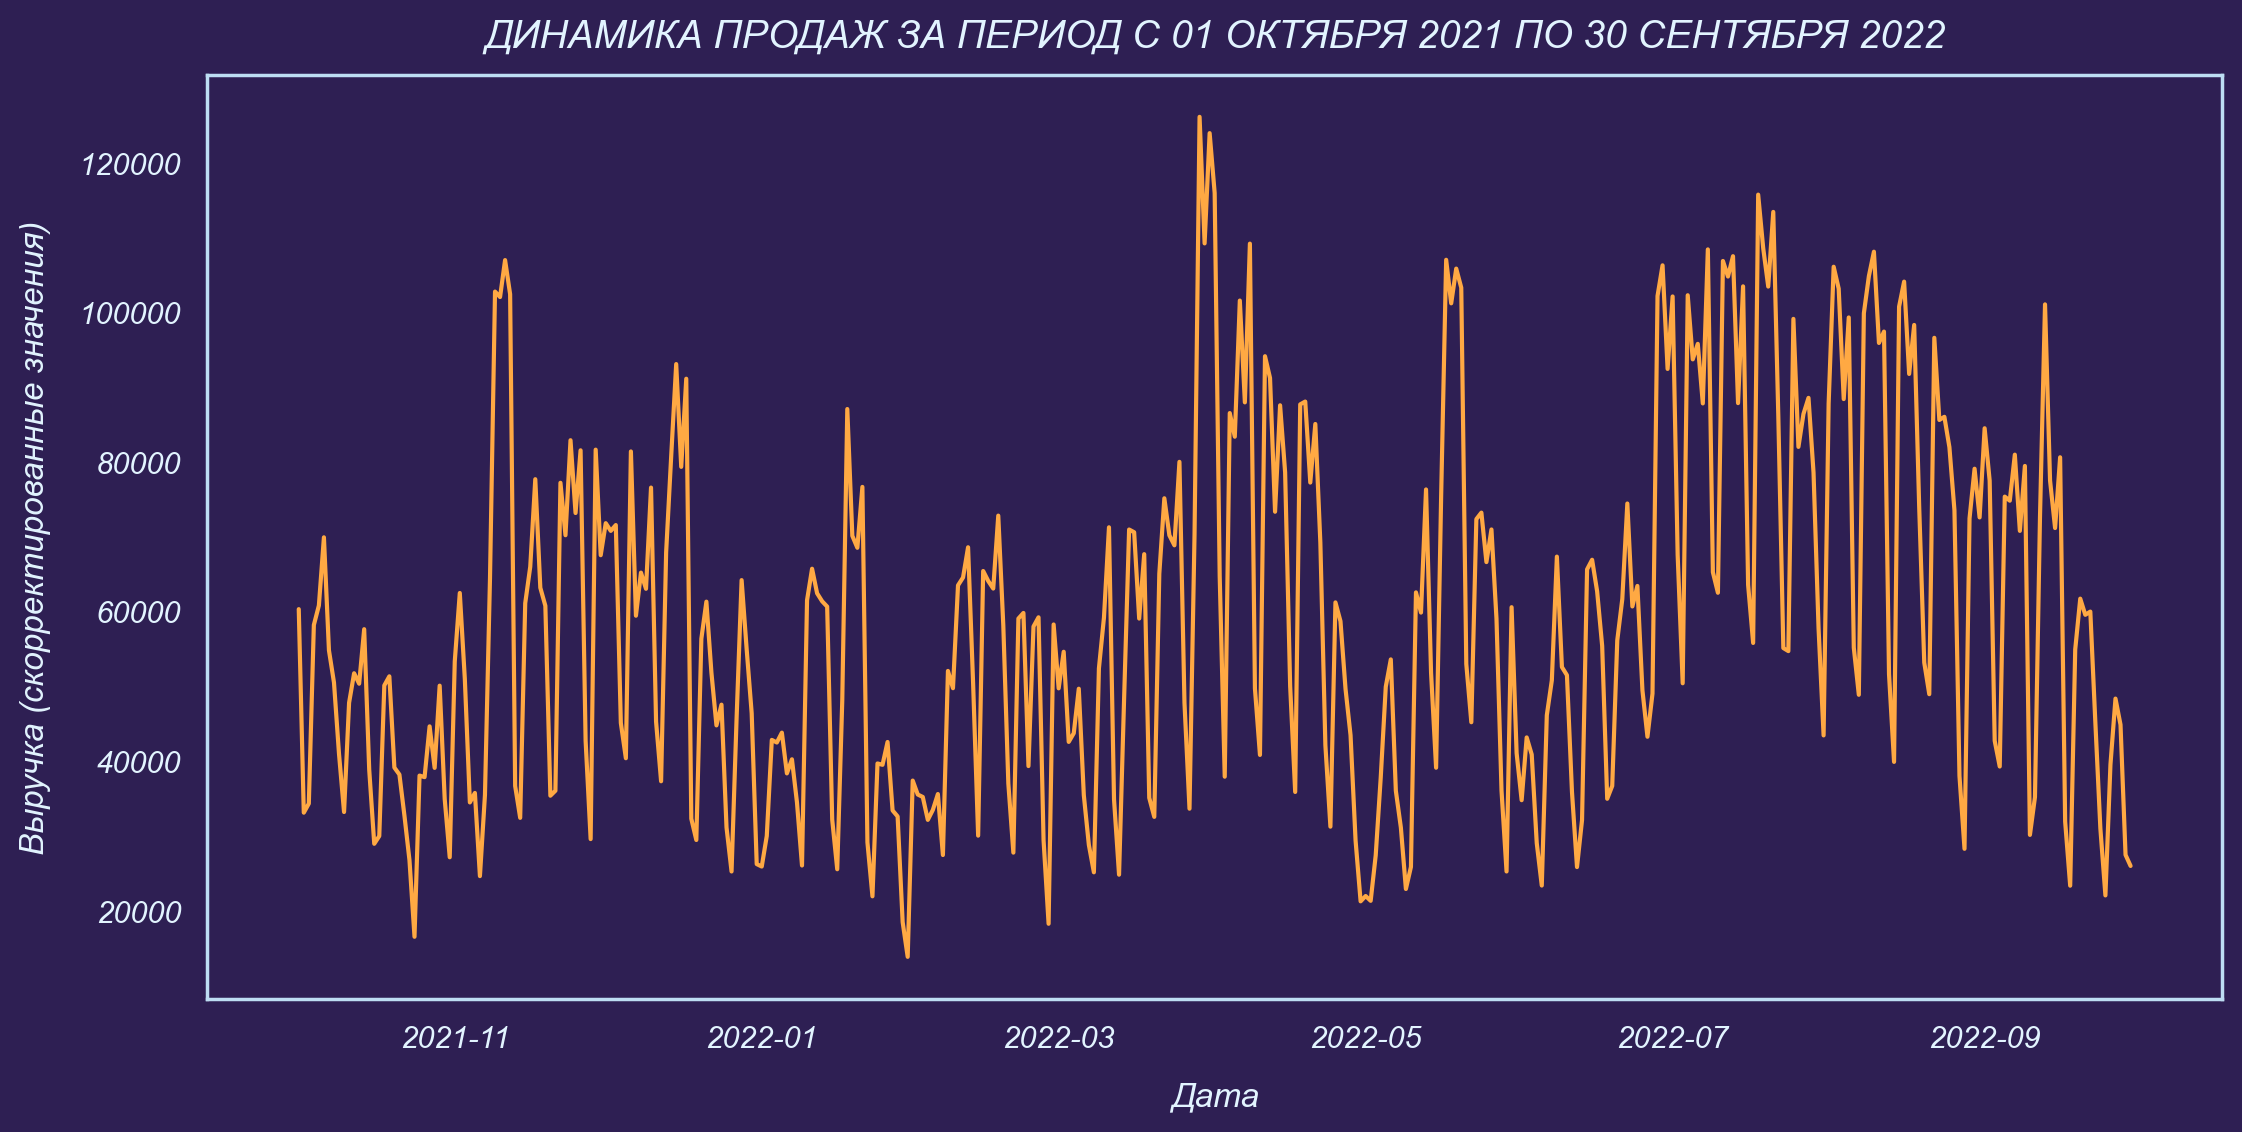

In [26]:
sns.lineplot(data=revenue_per_date, 
             x='purchase_date', 
             y='revenue').set(
     title='ДИНАМИКА ПРОДАЖ ЗА ПЕРИОД С 01 ОКТЯБРЯ 2021 ПО 30 СЕНТЯБРЯ 2022',
     xlabel='Дата',
     ylabel='Выручка (скорректированные значения)')
plt.show()

На графике наблюдаются значительные колебания в пределах даже одного месяца.
Посмотрим на какой-нибудь месяц, чтобы понять их причину. 

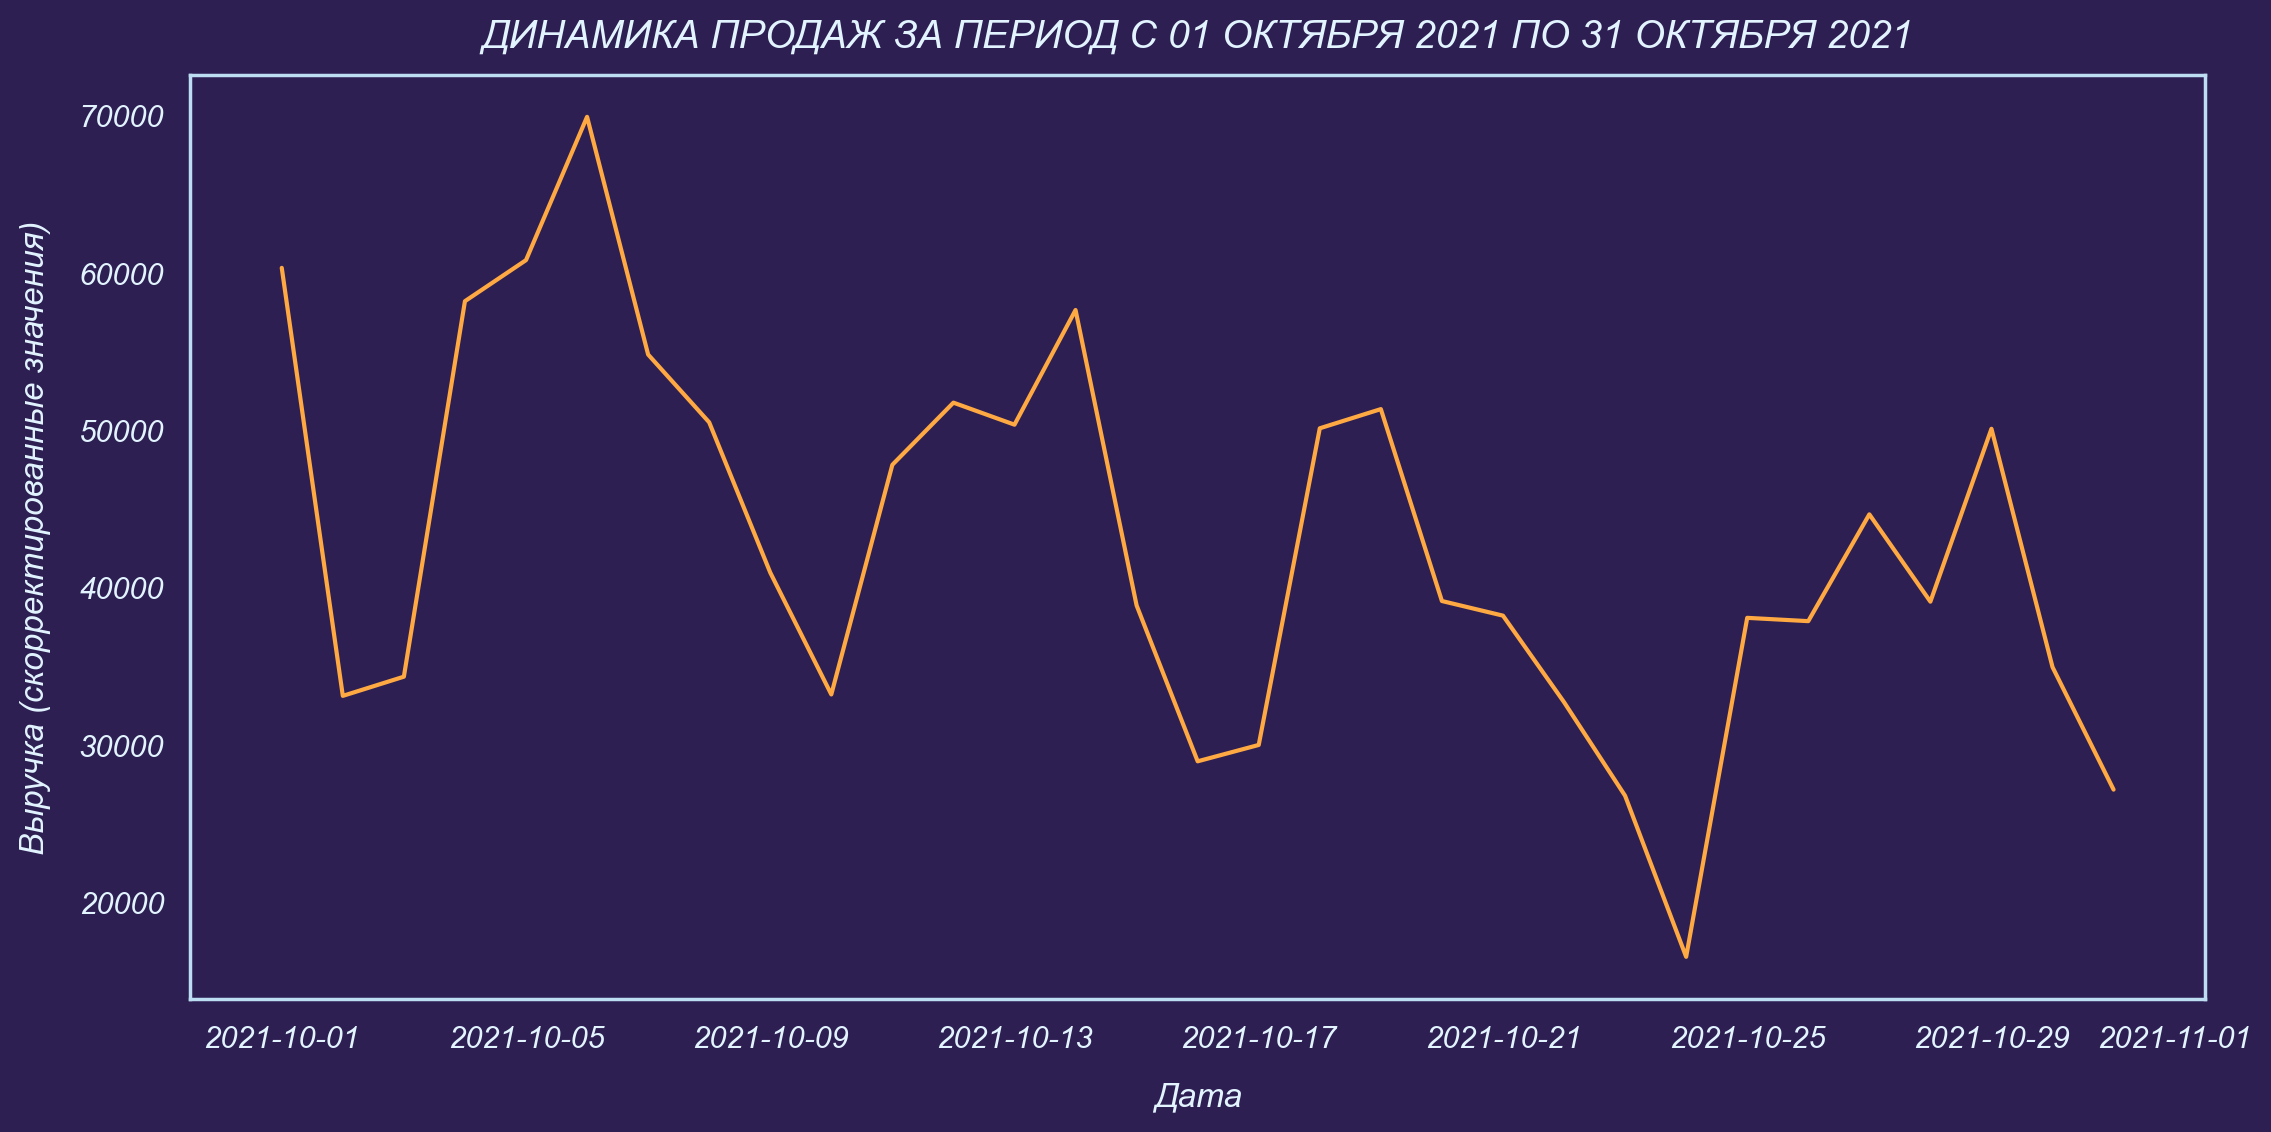

In [27]:
sns.lineplot(data=revenue_per_date[revenue_per_date['purchase_date']<'2021-11-01'], 
             x='purchase_date', 
             y='revenue').set(
     title='ДИНАМИКА ПРОДАЖ ЗА ПЕРИОД С 01 ОКТЯБРЯ 2021 ПО 31 ОКТЯБРЯ 2021',
     xlabel='Дата',
     ylabel='Выручка (скорректированные значения)')
plt.show()

Судя по всему, спад продаж происходит в выходные. Для того, чтобы точно в этом убедиться, построим отчет о продажах по дням недели за весь год.

[Вернуться к навигации](#0)

### Изменение объема продаж по дням недели <a class="anchor" id="12"></a>

In [28]:
weekdays = {'Monday': 'Понедельник', 
            'Tuesday': 'Вторник',
            'Wednesday': 'Среда',
            'Thursday': 'Четверг',
            'Friday': 'Пятница',
            'Saturday': 'Суббота',
            'Sunday': 'Воскресенье'}
df['purchase_weekday'] = df['purchase_date'].dt.day_name().map(weekdays)

In [29]:
# На будущее сразу создадим столбец с днями недели для дат полетов. Можно будет проверить, предпочитают ли люди летать на выходных, или нет.
df['flight_weekday'] = df['flight_date'].dt.day_name().map(weekdays)

In [30]:
# Посмотрим результат
df.head(3)

purchase_date flight_date  adult  revenue airport_from airport_to  local  \
0    2021-12-07  2022-01-11      1      200          MOW        KGD      1   
1    2021-12-31  2022-01-03      1      610          UUS        OVB      1   
2    2021-11-28  2022-01-04      1      390          KGD        MOW      1   

   loyalty  online purchase_weekday flight_weekday  
0        0       1          Вторник        Вторник  
1        0       0          Пятница    Понедельник  
2        1       1      Воскресенье        Вторник

In [31]:
# Просуммируем выручку по дням недели
revenue_per_weekday = df.groupby(by='purchase_weekday')['revenue'].sum().reset_index().sort_values('revenue')

In [32]:
# Добавим столбец с процентными значениями
total_revenue = df['revenue'].sum()
revenue_per_weekday['revenue_perc'] = round(revenue_per_weekday['revenue']/total_revenue*100, 2)

In [33]:
# для восстановления порядка
order_dict = {'Понедельник': 0, 
            'Вторник': 1,
            'Среда': 2 ,
            'Четверг': 3,
            'Пятница': 4,
            'Суббота': 5,
            'Воскресенье': 6}
revenue_per_weekday['order'] = revenue_per_weekday['purchase_weekday'].map(order_dict)

In [34]:
revenue_per_weekday = revenue_per_weekday.sort_values('order')
revenue_per_weekday 

purchase_weekday  revenue  revenue_perc  order
2      Понедельник  3348900         15.50      0
1          Вторник  3657910         16.93      1
4            Среда  3668570         16.98      2
6          Четверг  3512570         16.26      3
3          Пятница  3555190         16.46      4
5          Суббота  2114840          9.79      5
0      Воскресенье  1744390          8.07      6

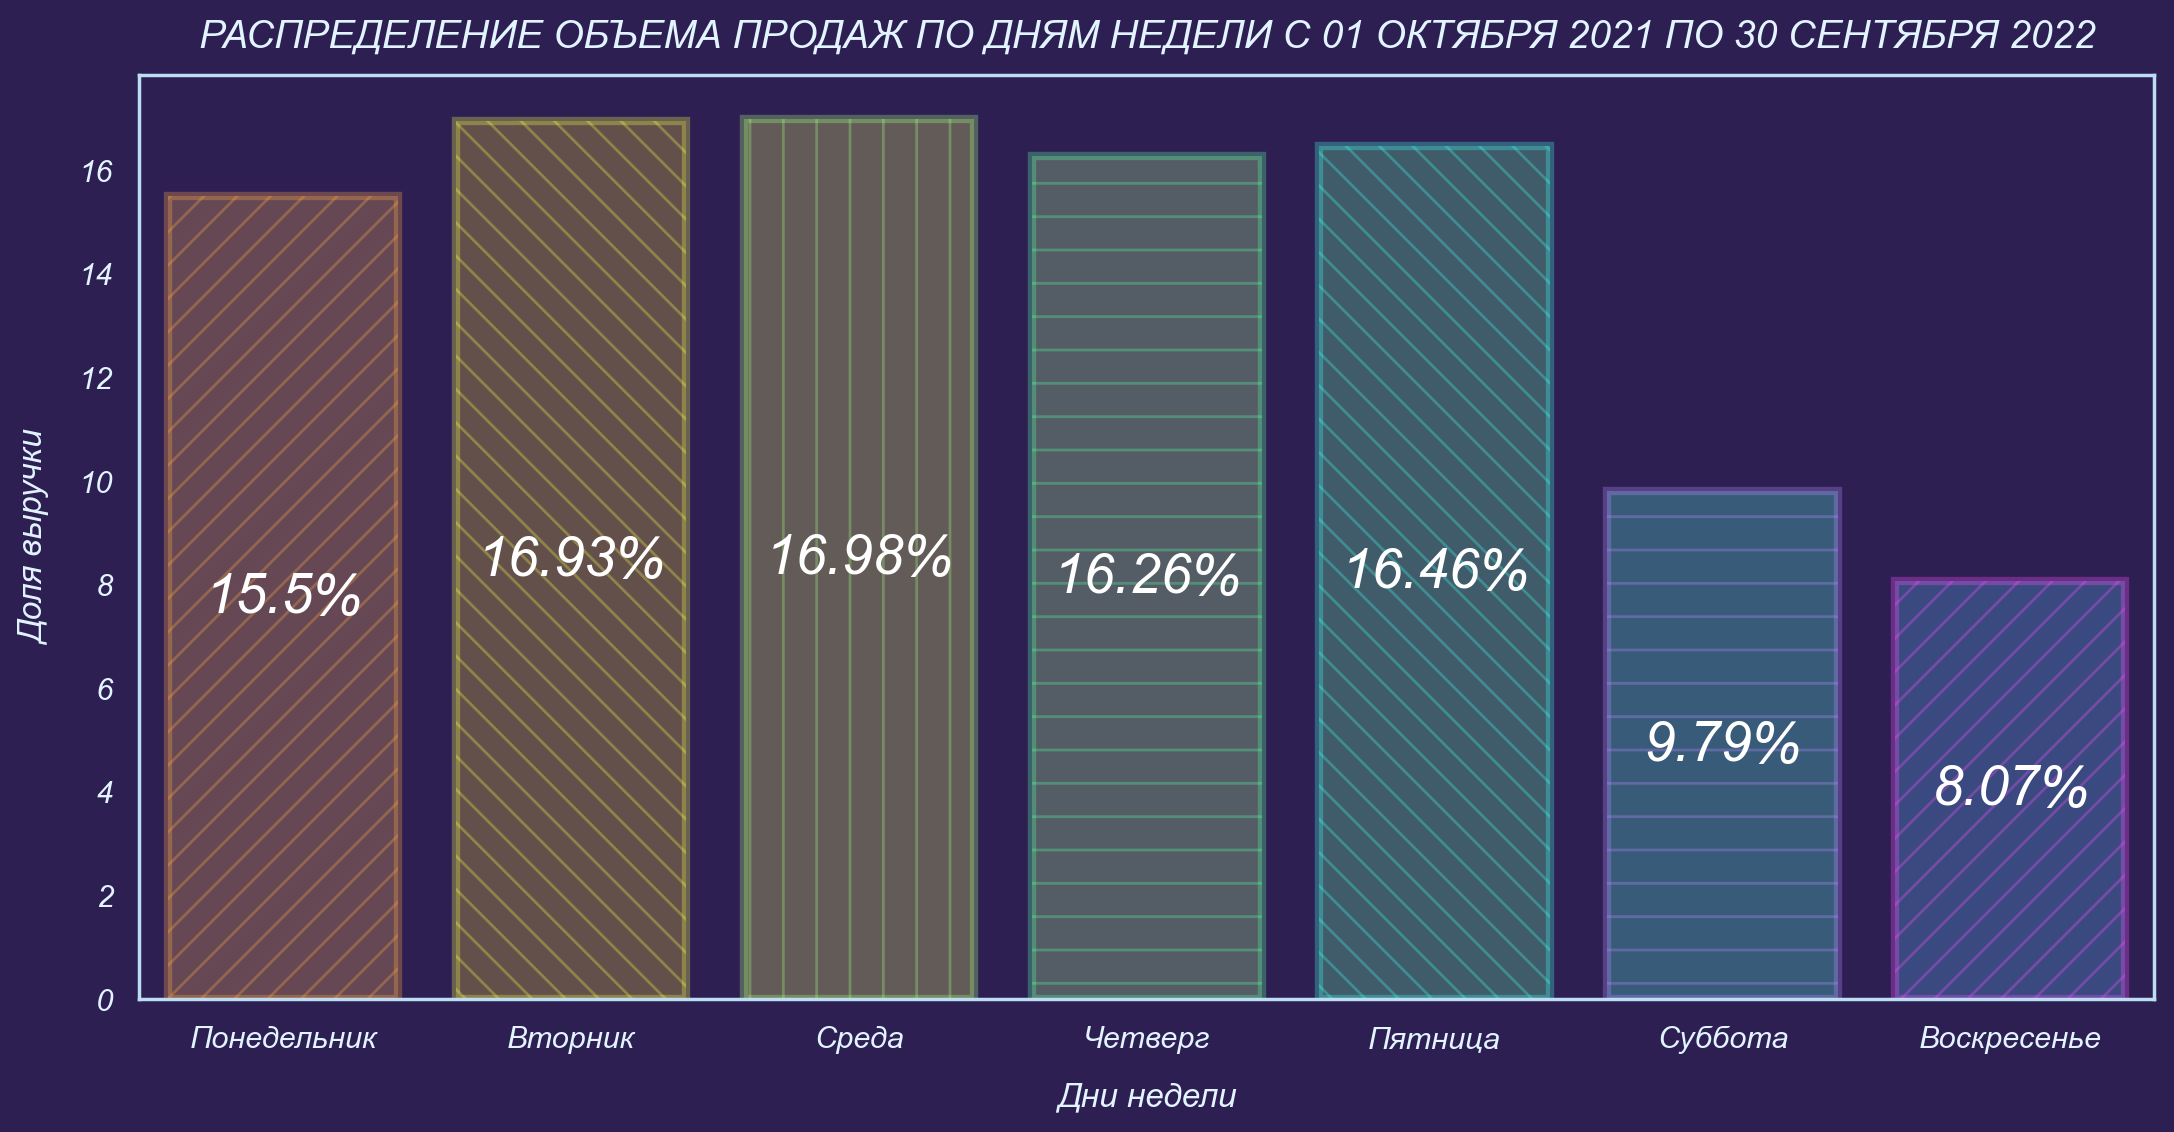

In [35]:
ax = sns.barplot(data=revenue_per_weekday, x='purchase_weekday', y = 'revenue_perc',
            edgecolor=['#ffa943', '#f0ff4c', '#a6ff82', '#55ffa0',
                       '#3dffe8', '#b98eff', '#fb50ff'], 
            linewidth=3,
            hatch = ['//', '\\\\', '|',  '-', 
                     '\\\\', '-', '//'],
            alpha=0.3
           )
ax.set(
                title='РАСПРЕДЕЛЕНИЕ ОБЪЕМА ПРОДАЖ ПО ДНЯМ НЕДЕЛИ С 01 ОКТЯБРЯ 2021 ПО 30 СЕНТЯБРЯ 2022',
                xlabel='Дни недели',
                ylabel='Доля выручки')
ax.bar_label(ax.containers[0], 
             labels=[f'{c}%' for c in revenue_per_weekday['revenue_perc']],
             label_type='center',
             color='w',
             fontsize=20)
plt.show()

Столбчатая диаграмма показывает, что в субботу и воскресенье продажи падают. Этим и обусловлено такое большое количество колебаний на линейном графике. 
Выручка распределена почти что равномерно в будние дни.

Однако, помимо различий между суммой выручки в будние и в выходные дни, на линейном графике видно, что в течение года объем продаж изменялся и по месяцам - в какие-то месяцы выручка была заметно больше, чем в другие. Это подробнее рассмотрим в пункте про сезонность продаж.

[Вернуться к навигации](#0)

### Детализация исследования динамики продаж по типу рейса, по типу покупки, по участию в программе лояльности <a class="anchor" id="13"></a>

In [36]:
revenue_per_date_loyalty = df.groupby(by=['purchase_date', 'loyalty'])['revenue'].sum().reset_index()
revenue_per_date_loyalty.head(3)

purchase_date  loyalty  revenue
0    2021-10-01        0    38160
1    2021-10-01        1    22150
2    2021-10-02        0    21020

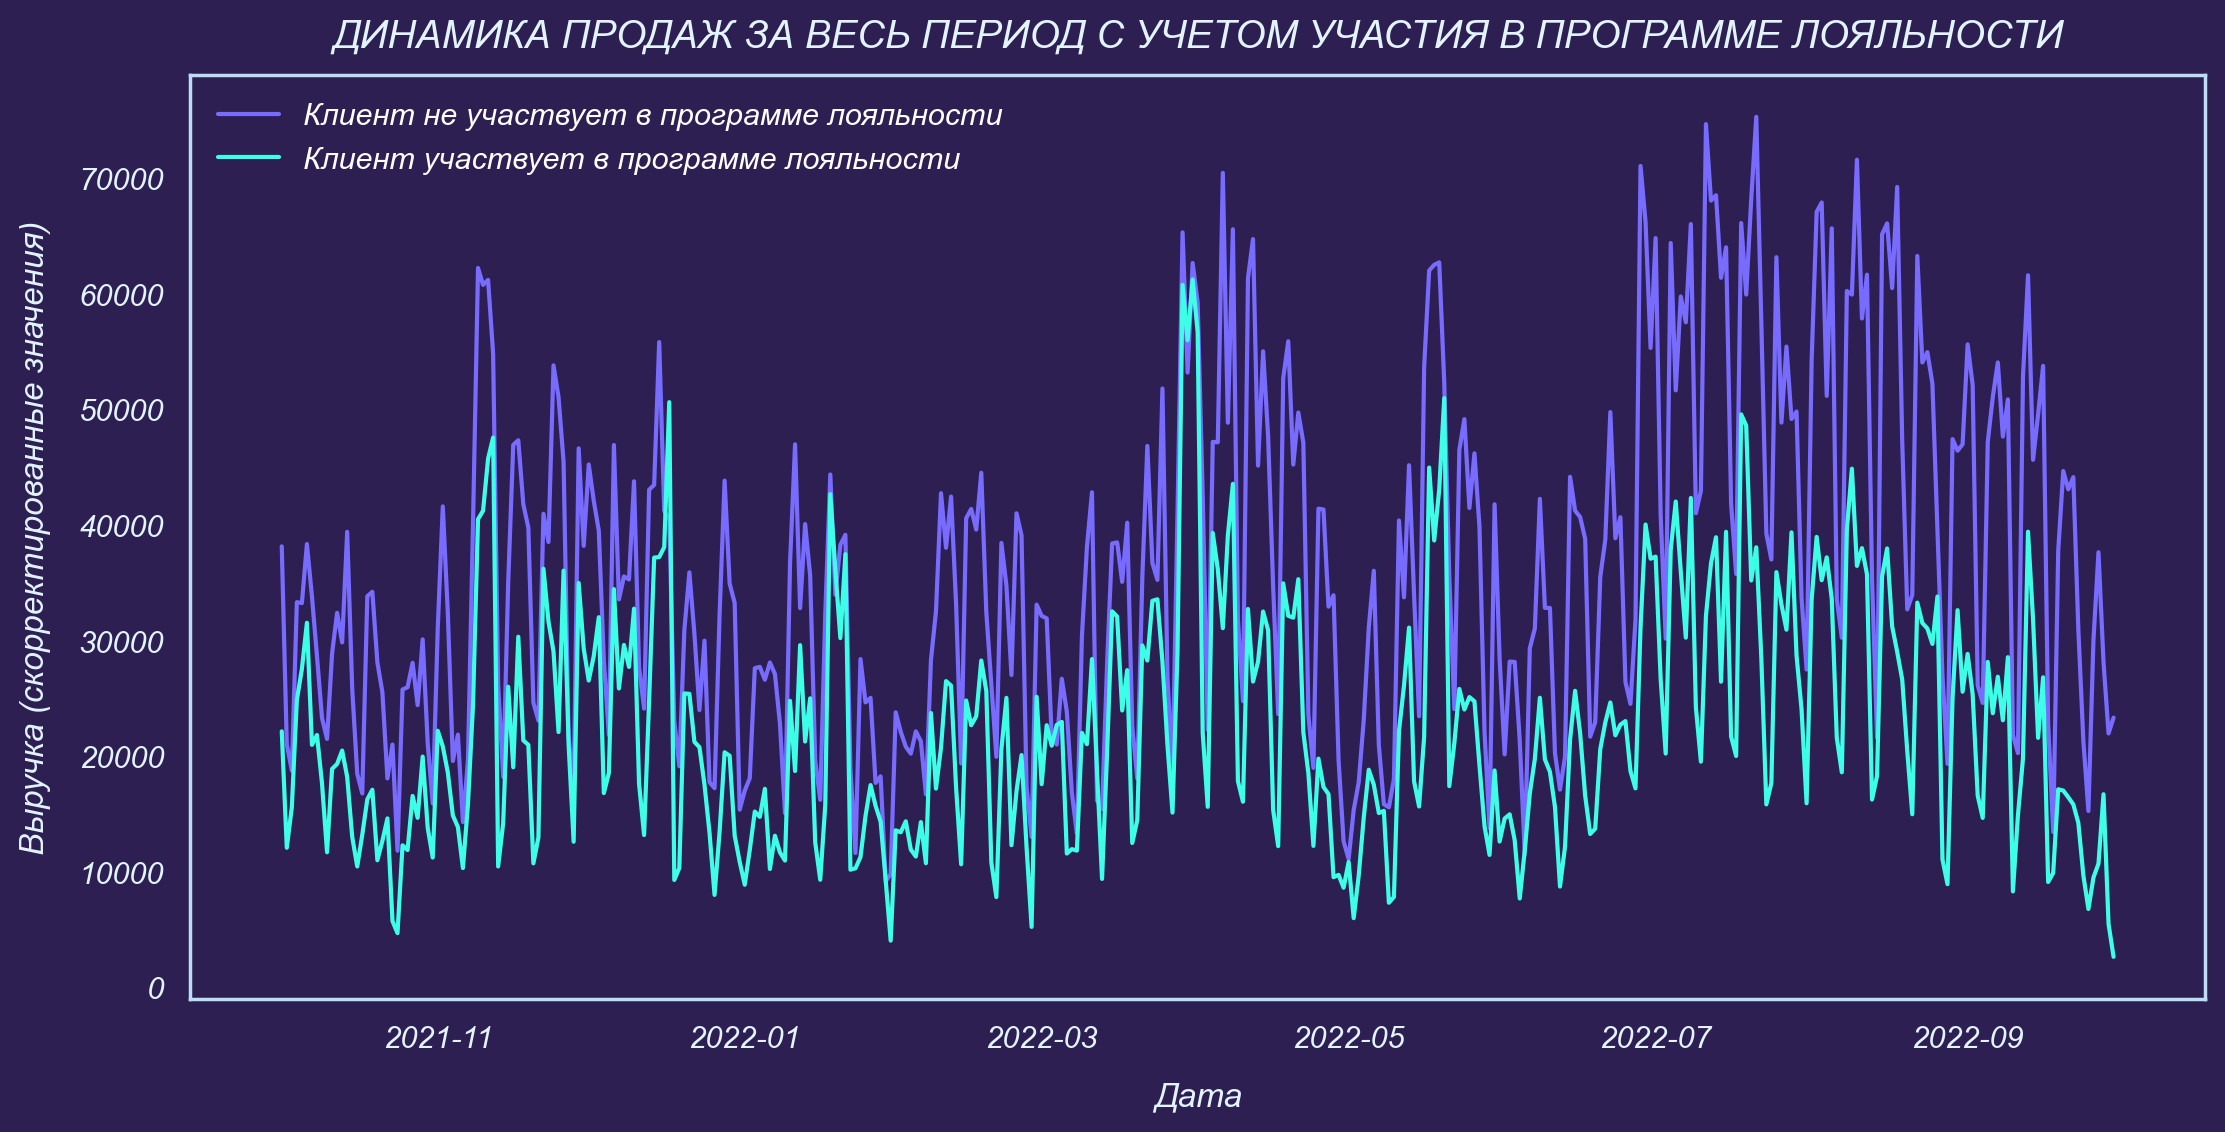

In [37]:
sns.lineplot(data=revenue_per_date_loyalty.query('loyalty==0'), 
             x='purchase_date', y='revenue', 
             label= 'Клиент не участвует в программе лояльности', color=BLUE)
(sns.lineplot(data=revenue_per_date_loyalty.query('loyalty==1'), 
             x='purchase_date', 
             y='revenue', label= 'Клиент участвует в программе лояльности', color=LIGHTBLUE)
.set(title='ДИНАМИКА ПРОДАЖ ЗА ВЕСЬ ПЕРИОД С УЧЕТОМ УЧАСТИЯ В ПРОГРАММЕ ЛОЯЛЬНОСТИ',
     xlabel='Дата',
     ylabel='Выручка (скорректированные значения)'))
plt.legend(title='', 
           loc='upper left',
           facecolor='#2e1f53',
           labelcolor='#ffffff',
           edgecolor= '#2e1f53')
plt.show()

В основном, выручка от продажи билетов клиентам, не участвующим в программе лояльности, превышает выручку от продажи билетов клиентам, участвующим в программе лояльности, кроме нескольких дней в течение года.   

In [38]:
print(round(revenue_per_date_loyalty.query('loyalty==1')['revenue'].mean(), 3),
      round(revenue_per_date_loyalty.query('loyalty==0')['revenue'].mean(),2))

22527.096 36657.48


Средняя выручка от участников программы лояльности ниже, чем от тех, кто не участвует. 

In [39]:
revenue_per_date_local = df.groupby(by=['purchase_date', 'local'])['revenue'].sum().reset_index()
revenue_per_date_local.head(3)

purchase_date  local  revenue
0    2021-10-01      0    14600
1    2021-10-01      1    45710
2    2021-10-02      0     6370

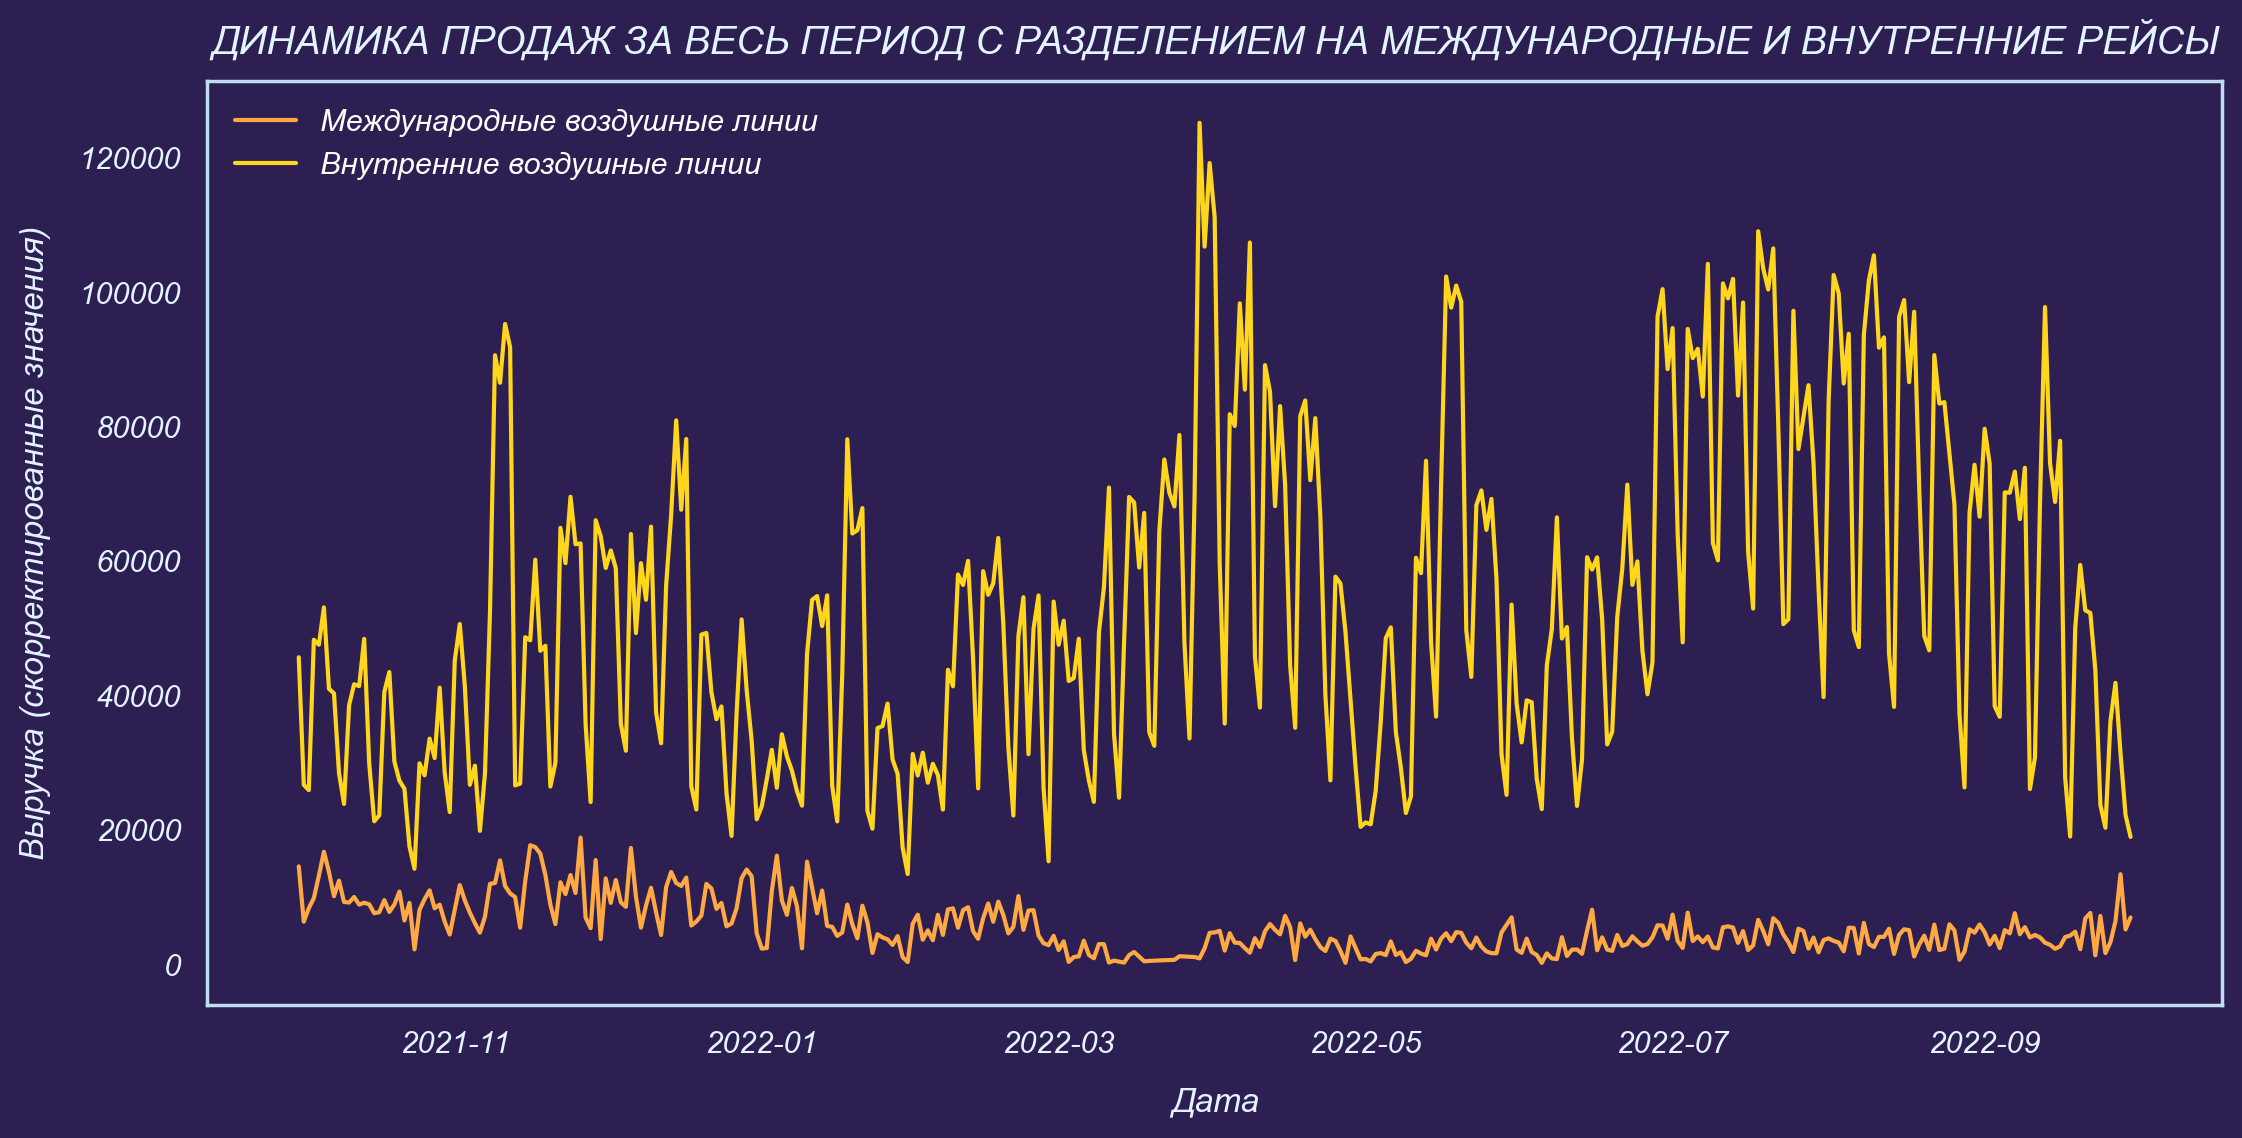

In [40]:
sns.lineplot(data=revenue_per_date_local.query('local==0'), 
             x='purchase_date', y='revenue', 
             label= 'Международные воздушные линии', color=ORANGE)
(sns.lineplot(data=revenue_per_date_local.query('local==1'), 
             x='purchase_date', 
             y='revenue', label= 'Внутренние воздушные линии', color=YELLOW)
.set(title='ДИНАМИКА ПРОДАЖ ЗА ВЕСЬ ПЕРИОД С РАЗДЕЛЕНИЕМ НА МЕЖДУНАРОДНЫЕ И ВНУТРЕННИЕ РЕЙСЫ',
     xlabel='Дата',
     ylabel='Выручка (скорректированные значения)'))
plt.legend(title='', 
           loc='upper left',
           facecolor='#2e1f53',
           labelcolor='#ffffff',
           edgecolor= '#2e1f53')
plt.show()

Выручка от продаж билетов на внутренние рейсы на протяжении всего времени превышает выручку от продаж билетов на международные рейсы.   
На графике заметно, что колебания выручек за день от продажи двух типов билетов схожи: где происходит спад продаж билетов на внутренние рейсы, происходит и спад продаж на международные (за редкими исключениями).

In [41]:
revenue_per_date_online = df.groupby(by=['purchase_date', 'online'])['revenue'].sum().reset_index()
revenue_per_date_online.head(3)

purchase_date  online  revenue
0    2021-10-01       0    31530
1    2021-10-01       1    28780
2    2021-10-02       0    16180

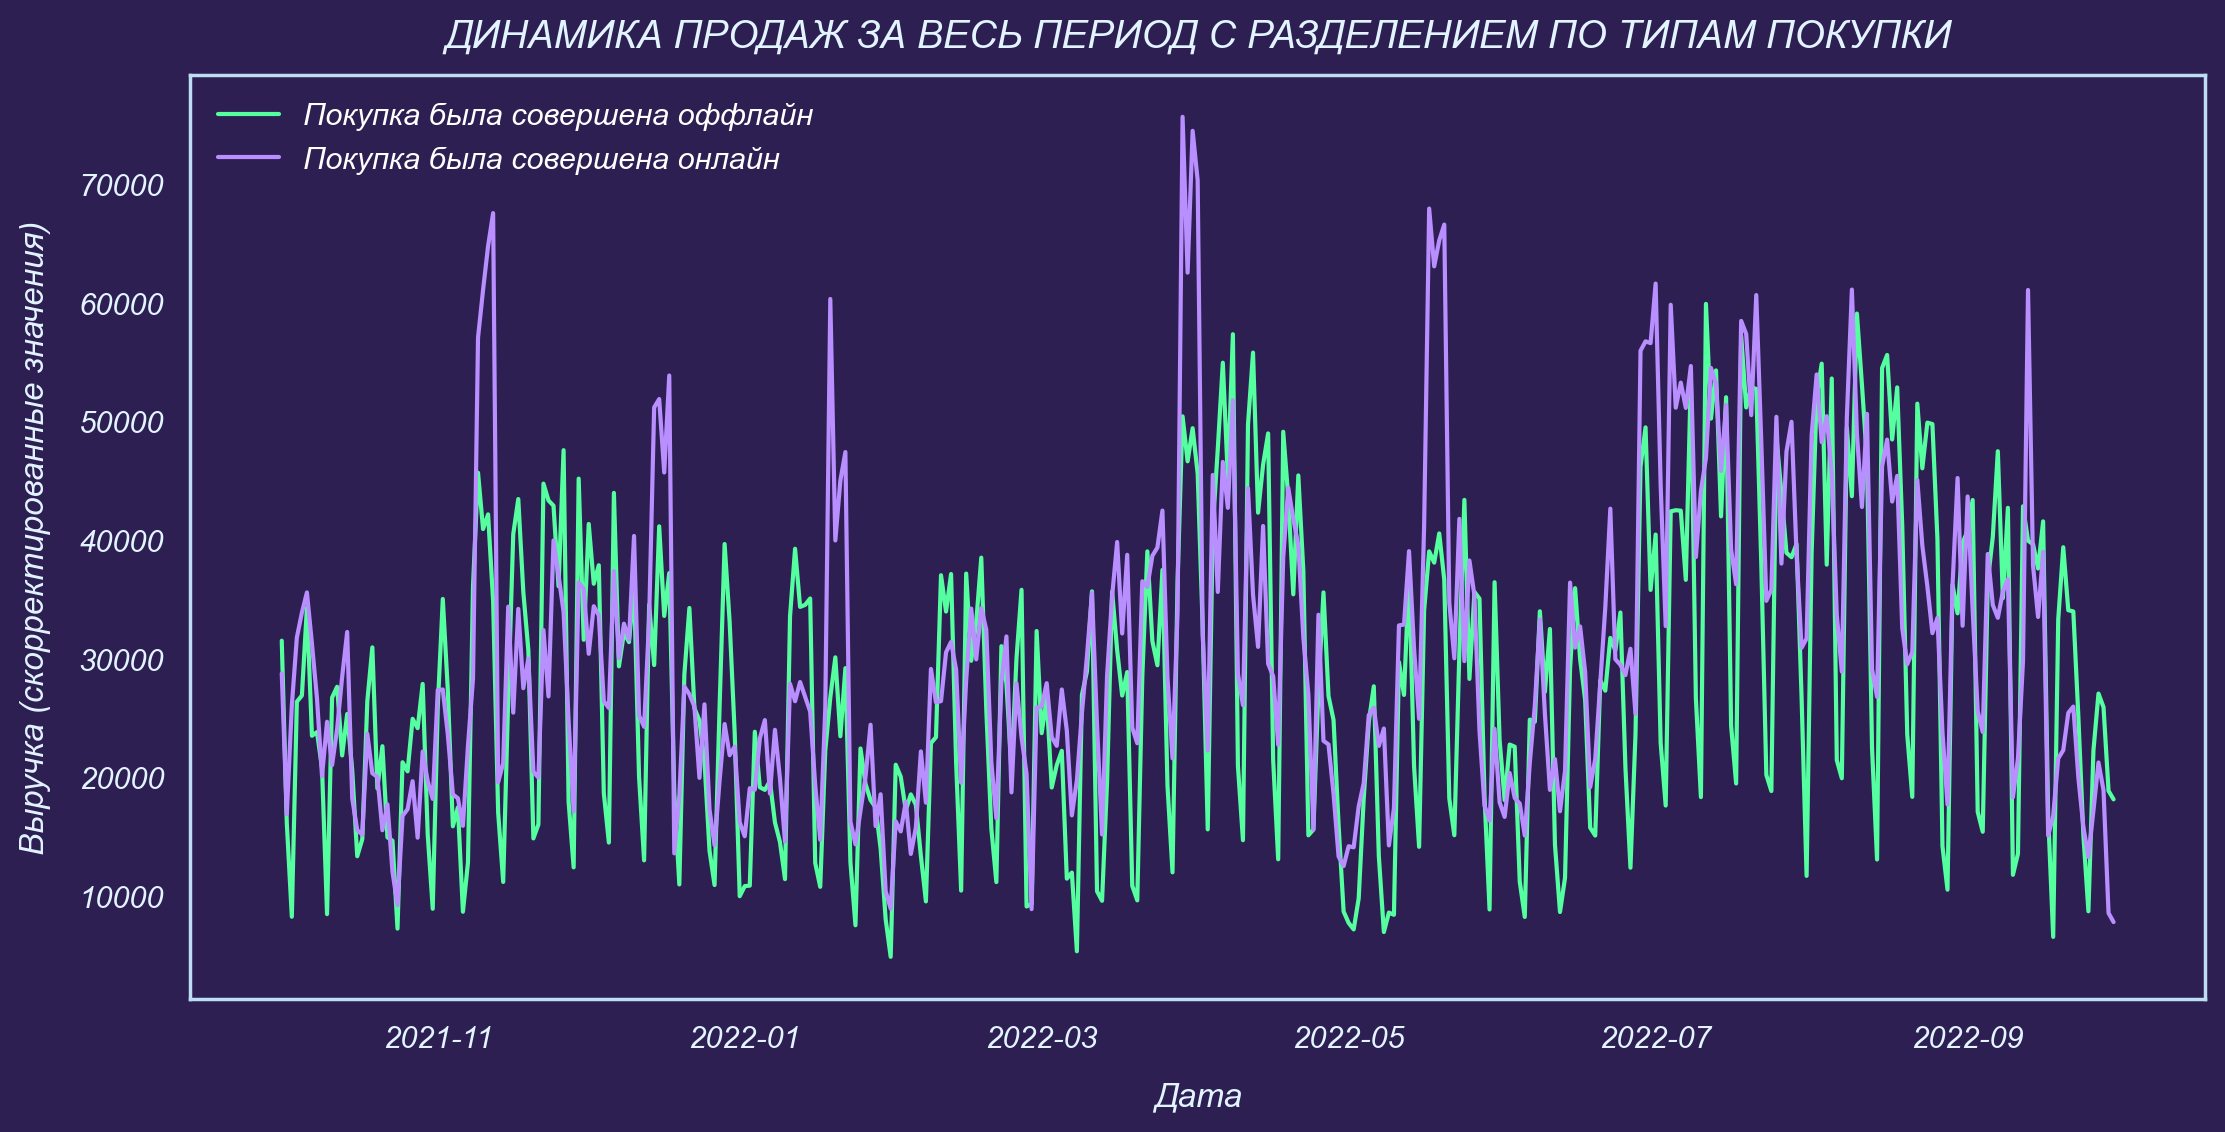

In [42]:
sns.lineplot(data=revenue_per_date_online.query('online==0'), 
             x='purchase_date', y='revenue', 
             label= 'Покупка была совершена оффлайн', color=GREEN)
(sns.lineplot(data=revenue_per_date_online.query('online==1'), 
             x='purchase_date', 
             y='revenue', label= 'Покупка была совершена онлайн', color=LIGHTPURPLE)
.set(title='ДИНАМИКА ПРОДАЖ ЗА ВЕСЬ ПЕРИОД С РАЗДЕЛЕНИЕМ ПО ТИПАМ ПОКУПКИ',
     xlabel='Дата',
     ylabel='Выручка (скорректированные значения)'))
plt.legend(title='', 
           loc='upper left',
           facecolor='#2e1f53',
           labelcolor='#ffffff',
           edgecolor= '#2e1f53')
plt.show()

Если сопоставить информацию с трех графиков выше, то в период между мартом и маем 2022 года, наблюдается скачок выручки, причем:
1. Резко выросло количество покупок совершенных онлайн в этот период;
2. В этот же период наблюдается скачок выручки от клиентов, участвующих в программе лояльности;
3. Вырчка от продажи билетов на внутренние рейсы в этот же период тоже выросла, выручка от билетов на международние рейсы выросла не значительно.
Посмотрим поближе на этот период.

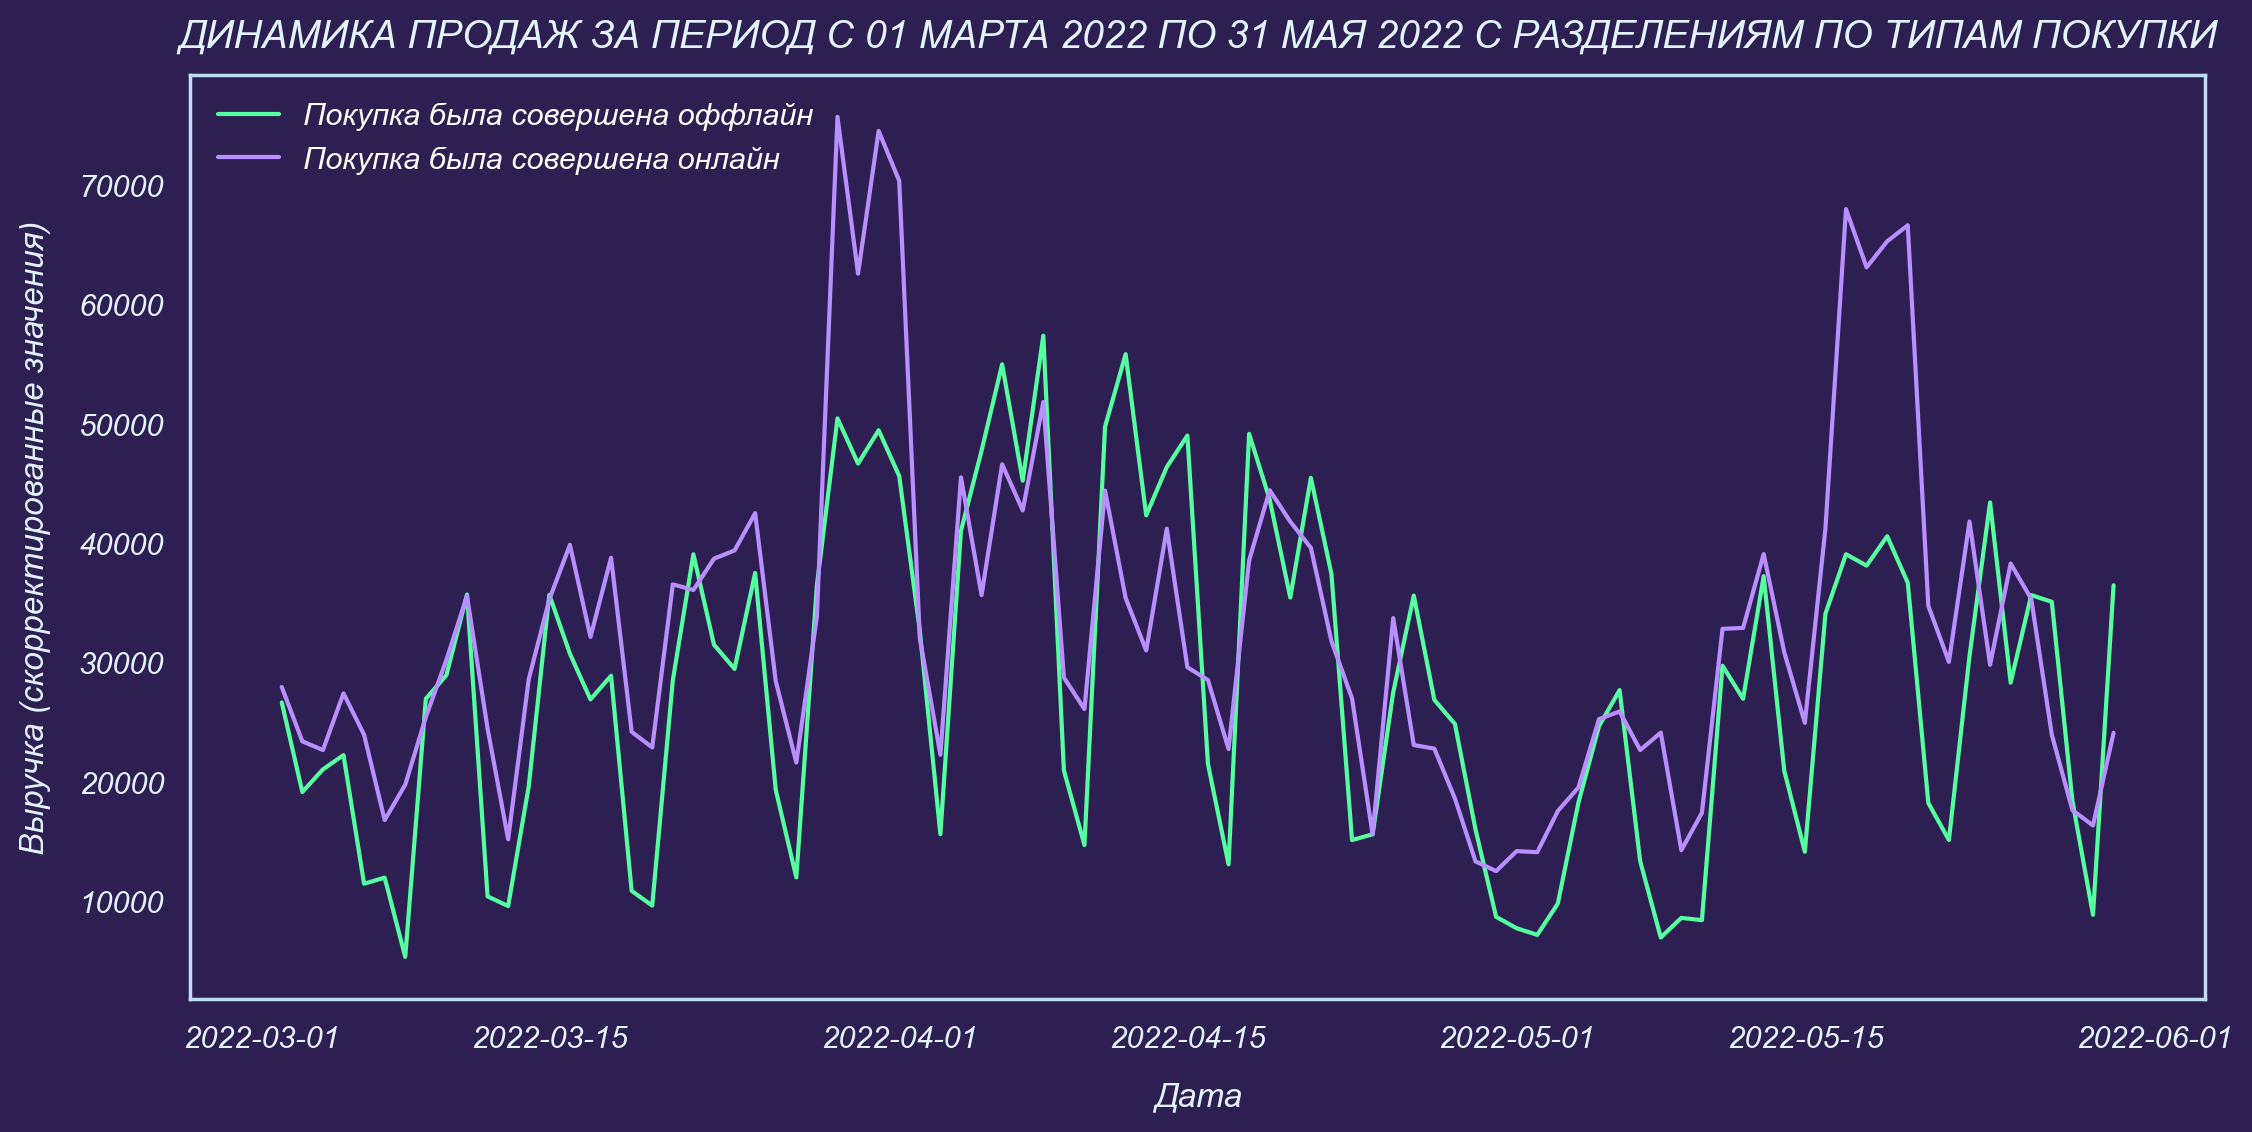

In [43]:
sns.lineplot(data=revenue_per_date_online.query('online==0 & purchase_date > "2022-03-01" & purchase_date < "2022-05-31"'), 
             x='purchase_date', y='revenue', 
             label= 'Покупка была совершена оффлайн', color=GREEN)
(sns.lineplot(data=revenue_per_date_online.query('online==1 & purchase_date > "2022-03-01" & purchase_date < "2022-05-31"'), 
             x='purchase_date', 
             y='revenue', label= 'Покупка была совершена онлайн', color=LIGHTPURPLE)
.set(title='ДИНАМИКА ПРОДАЖ ЗА ПЕРИОД С 01 МАРТА 2022 ПО 31 МАЯ 2022 С РАЗДЕЛЕНИЯМ ПО ТИПАМ ПОКУПКИ',
     xlabel='Дата',
     ylabel='Выручка (скорректированные значения)'))
plt.legend(title='', 
           loc='upper left',
           facecolor='#2e1f53',
           labelcolor='#ffffff',
           edgecolor= '#2e1f53')
plt.show()

Возможно, в начале апреля проводилась какая-то акция для участников программы лояльности, что подстегнуло пользователей присоединяться к программе и совершать больше покупок онлайн.   
Вряд ли такой рост связан с экономическими/политическими причинами, потому что:
1. Не наблюдается большой рост выручки от билетов на международные направления;
2. Есть рост выручки от клиентов, участвующих в программе лояльностии -> при возникновении каких-либо политеческих/экономических событий чаще всего покупка билетов происходит без регистрации в подобных программах.

[Вернуться к навигации](#0)

## Исследование выручки <a class="anchor" id="14"></a>

### Отсечение выбросов <a class="anchor" id="15"></a>

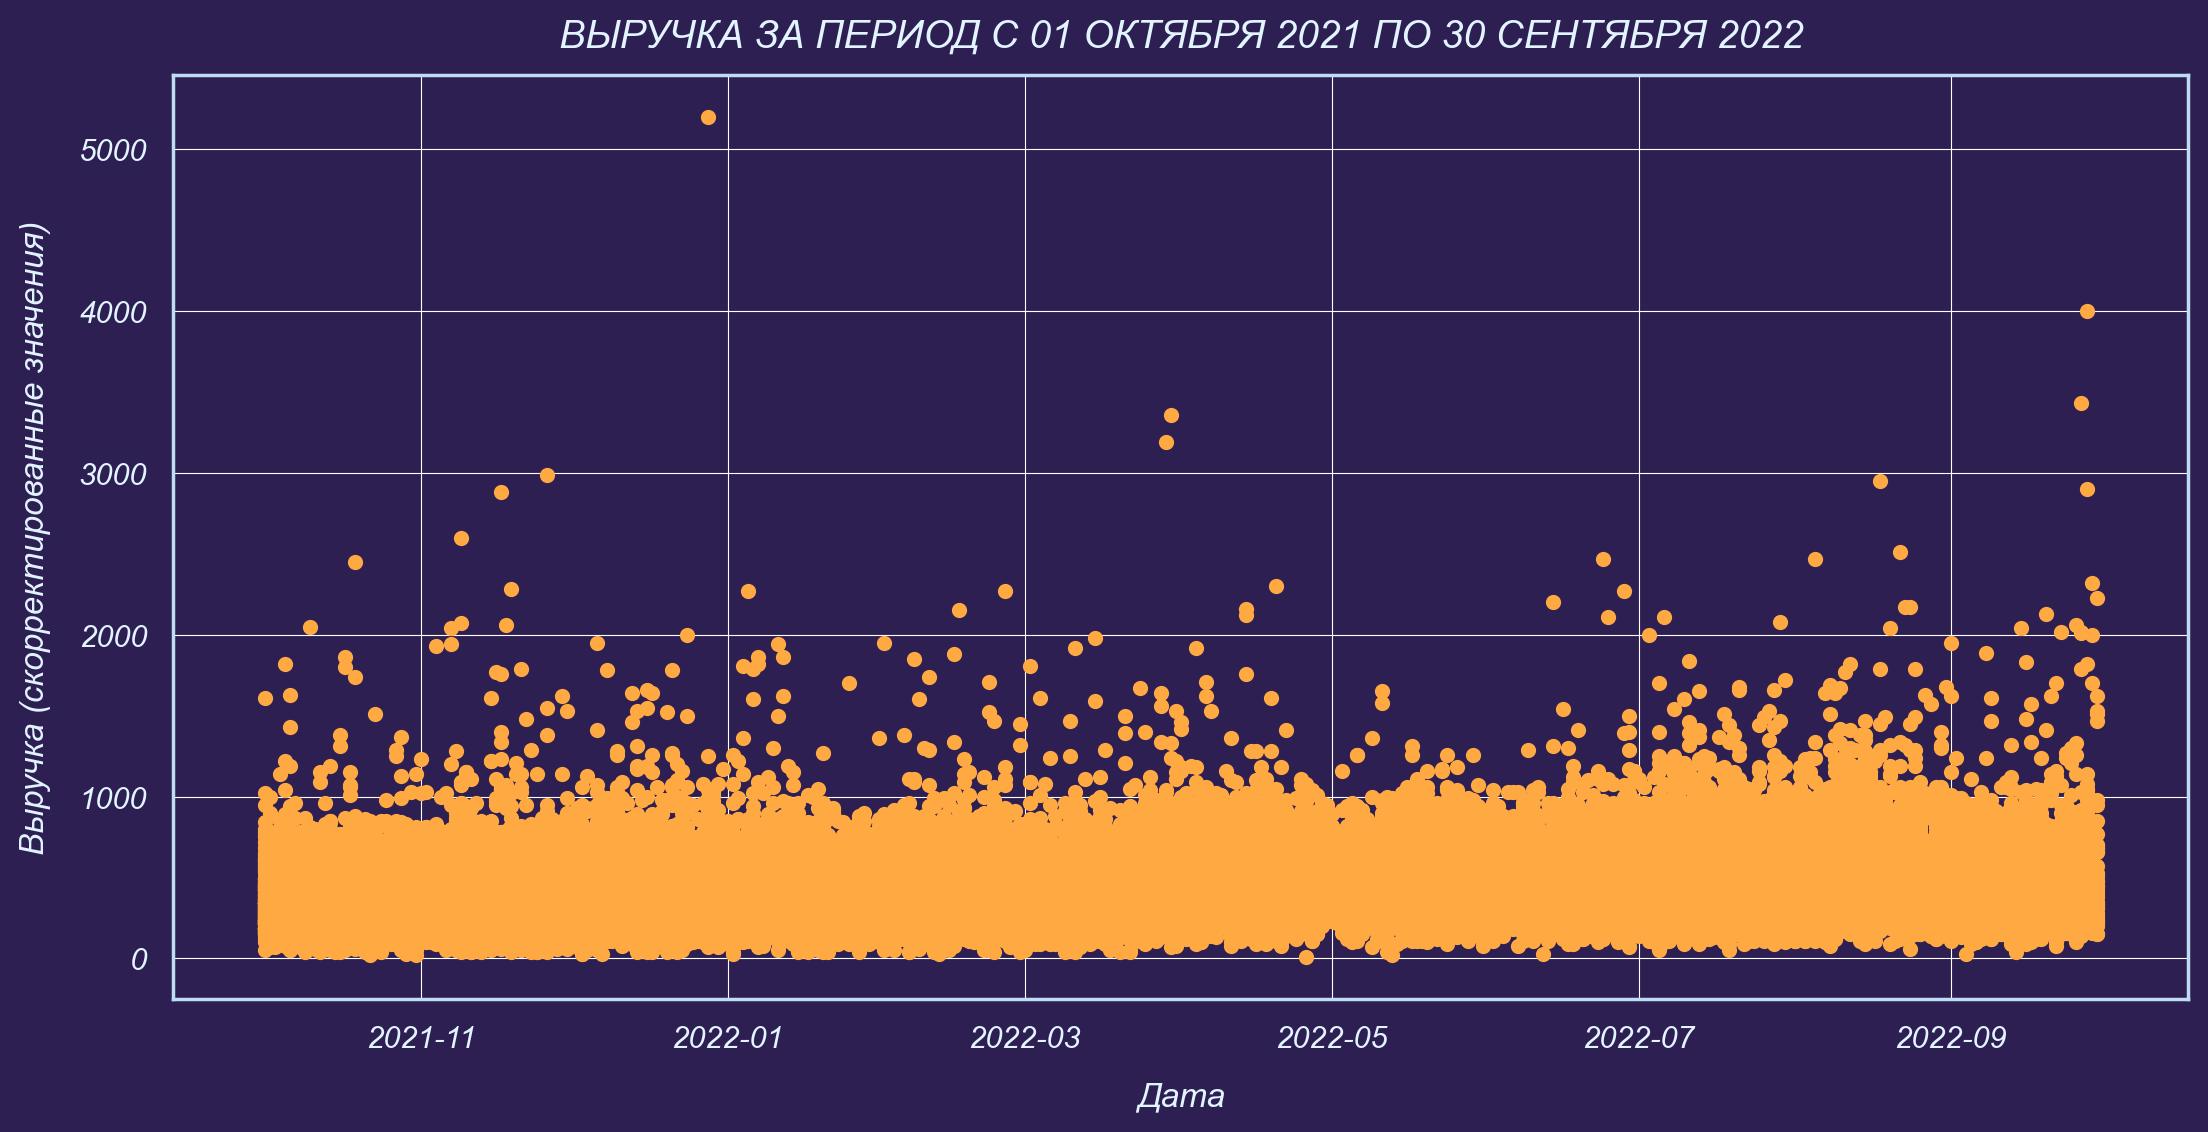

In [44]:
# Построим точечную диаграмму c сеткой
df.plot(kind='scatter',
        x='purchase_date',
        y='revenue',
        title='ВЫРУЧКА ЗА ПЕРИОД С 01 ОКТЯБРЯ 2021 ПО 30 СЕНТЯБРЯ 2022',
        legend=False,
        grid = True,
        xlabel='Дата',
        ylabel='Выручка (cкорректированные значения)'
        )

plt.show()

На точечной диаграмме можно заметить, что большое множество значений лежит в интервале (0; 1000). Скорее всего, все значения, что находятся за пределами этого интервала, будут являться выбросами. Построим ящик с усами, потом будем принимать решения об удалении выбросов.

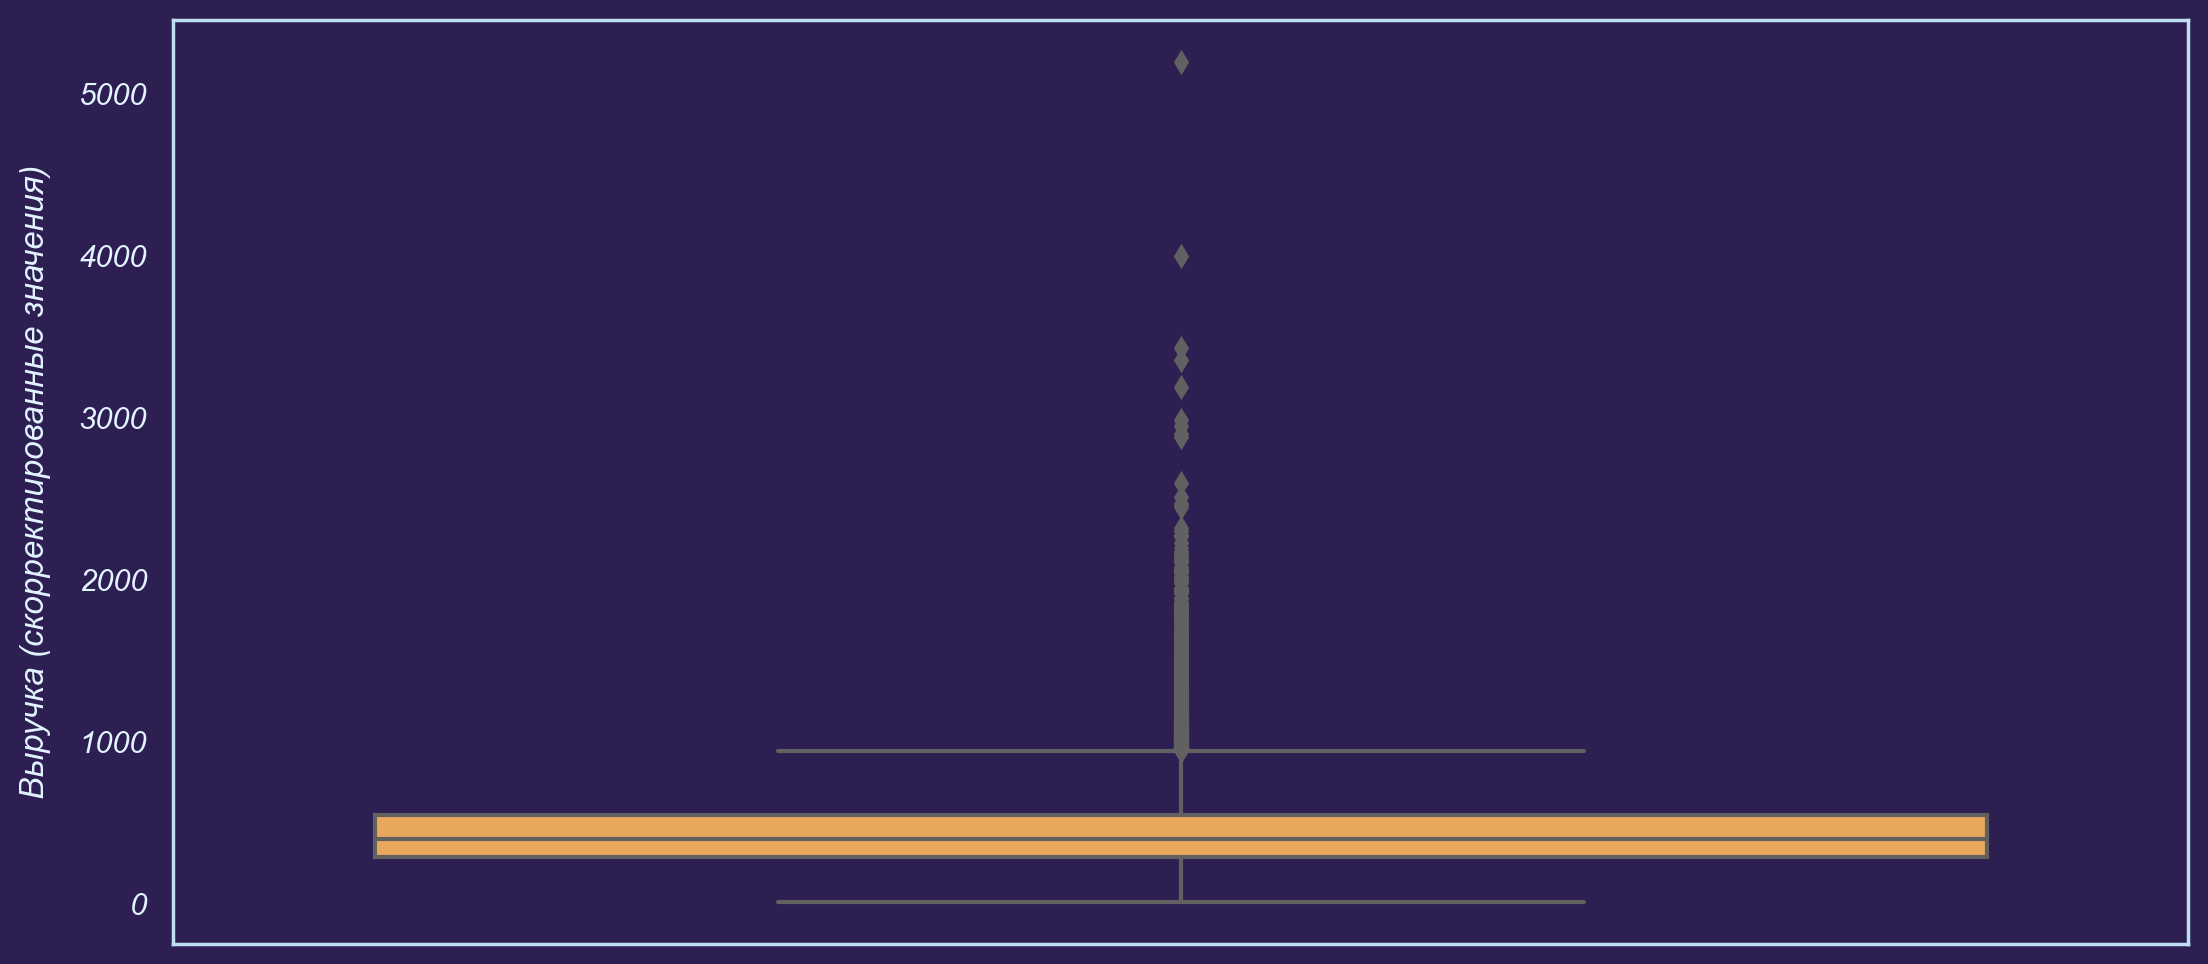

In [45]:
sns.boxplot(data=df, y='revenue').set(ylabel='Выручка (скорректированные значения)')
plt.show()

Посмотрим, сколько всего выбросов содержит столбец с выручкой.

In [46]:
# Найдем межквартильный размах
q3 = np.percentile(df['revenue'], 75)
q1 = np.percentile(df['revenue'], 25)
iqr = q3 - q1
# Отсекать выбросы будем только выбросы "сверху".
edge = q3 + 1.5 * iqr
print(edge)

940.0


In [47]:
# Обернем это в функцию
def find_edge_high(column):
    q3 = np.percentile(column, 75)
    q1 = np.percentile(column, 25)
    iqr = q3 - q1
    return q3 + 1.5 * iqr

In [48]:
print('Количество выбросов составляет', 
      round(df[df['revenue']>940]['revenue'].count() / df['revenue'].count() * 100, 2),
      'процента от общего количества значений.')

Количество выбросов составляет 2.0 процента от общего количества значений.


Так как количество выбросов мало, можем принять решение о том, чтобы отсечь выбросы по найденной границе.

In [49]:
# Исходный датасет нам уже не понадобится, нет смысла хранить два датасета.
df_reduced = df[df['revenue']<= 940].copy()

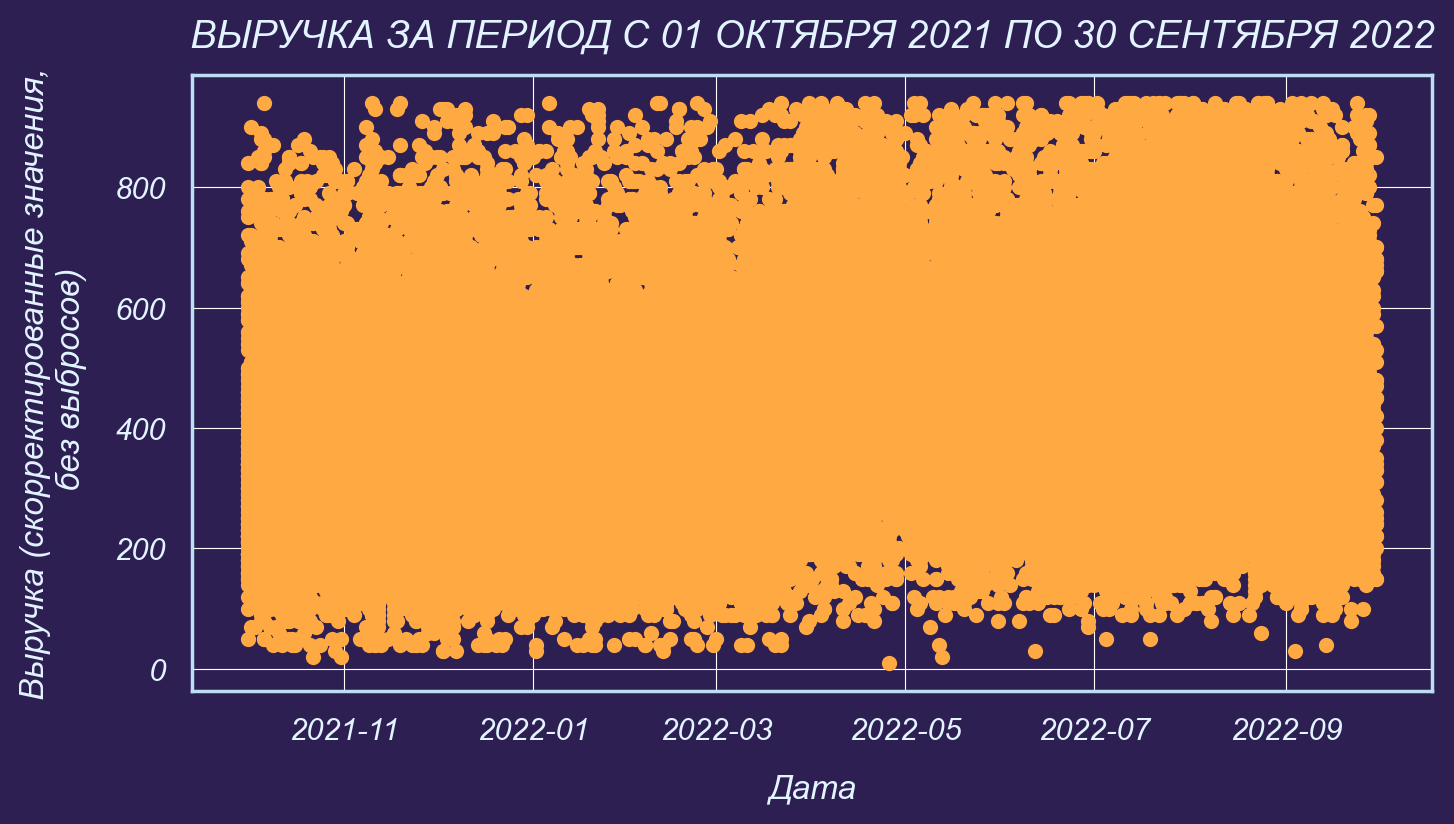

In [50]:
df_reduced.plot(kind='scatter',
          figsize = (8,4),
          x='purchase_date',
          y='revenue',
          title='ВЫРУЧКА ЗА ПЕРИОД С 01 ОКТЯБРЯ 2021 ПО 30 СЕНТЯБРЯ 2022',
          legend=False,
          grid = True,
          xlabel='Дата',
          ylabel='Выручка (cкорректированные значения,\n без выбросов)'
          )

plt.show()

[Вернуться к навигации](#0)

### Распределение выручки <a class="anchor" id="16"></a>

Посмотрим на основные параметры распределения выручки за весь период.

In [51]:
df_reduced['revenue'].describe()

count    48375.000000
mean       421.941085
std        178.547873
min         10.000000
25%        280.000000
50%        400.000000
75%        540.000000
max        940.000000
Name: revenue, dtype: float64

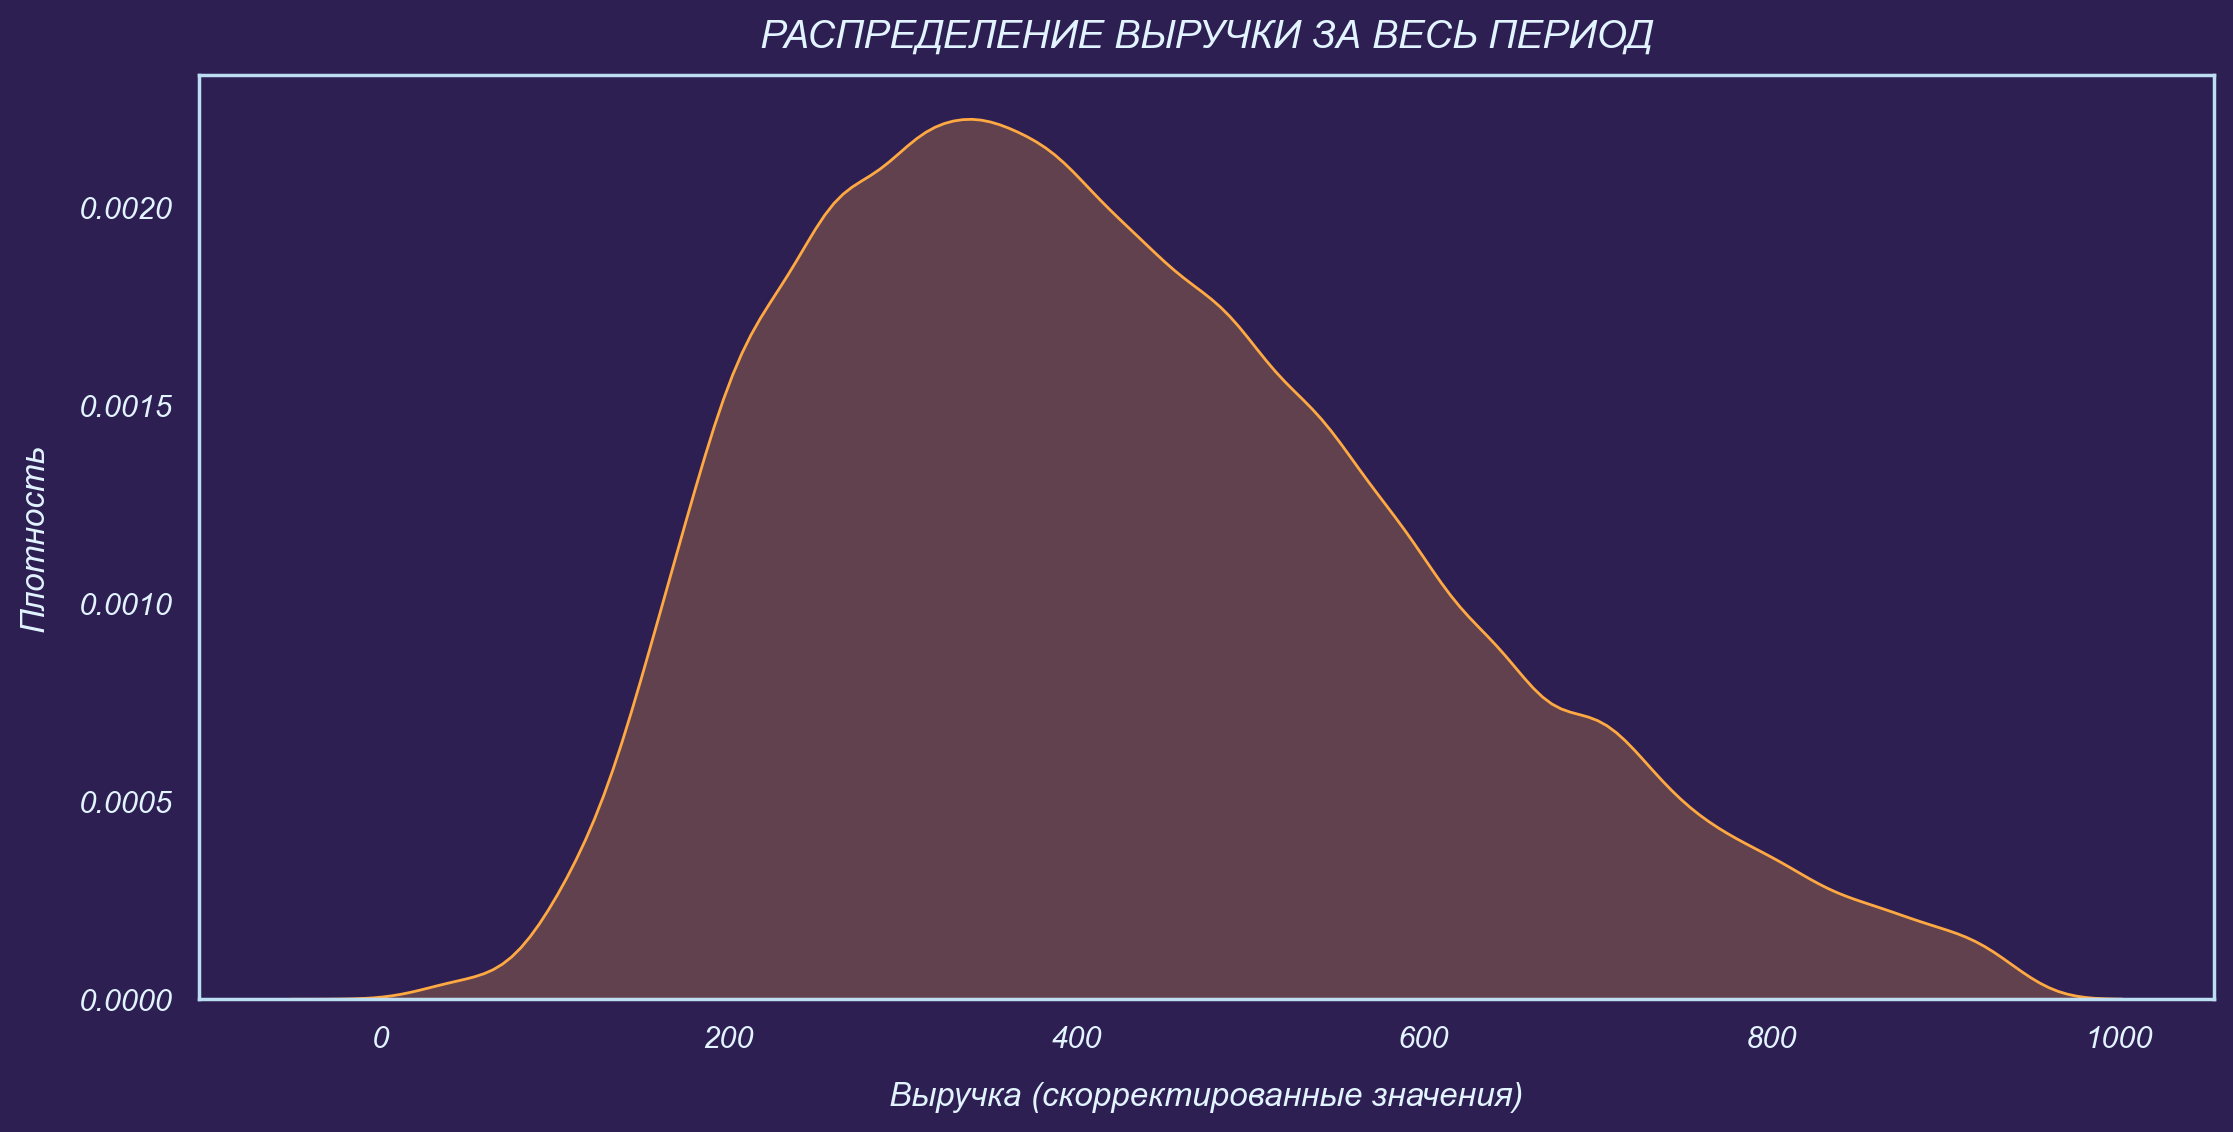

In [52]:
sns.kdeplot(data=df_reduced['revenue'],
            fill=True).set(
     title='РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ЗА ВЕСЬ ПЕРИОД',
     xlabel='Выручка (скорректированные значения)',
     ylabel='Плотность')
plt.show()

Распределение не похоже на нормальное, т.к. имеет явно асимметричную форму. 
Можем посмотреть, соответствует ли распределение выручки какому-то другому распределению

[Вернуться к навигации](#0)

### Проверка на соответствие теоретическим распределениям <a class="anchor" id="17"></a>

In [53]:
# длинный список почти всех распределений из модуля scipy.stats
dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']

In [54]:
len(dist_names)

78

In [55]:
# были отобраны распределения, визуально напоминающие распределение выручки из нашего датасета
# т.к. ни одно из них не подтвердилось, было решено проводить тест уже по всему длинному списку
dist_names_short = ['beta', 'betaprime', 'burr', 'erlang', 'exponweib', 
              'f', 'fisk', 'gamma', 'genextreme', 'gengamma', 
              'gumbel_r', 'invweibull', 'ksone', 'kstwobign', 'maxwell',
              'mielke', 'ncf', 'powerlognorm', 'rayleigh', 'rice']

In [56]:
# Проверяем соответсвие распределения наших данных и распределений из списка (теоретические распределения)
def get_best_distribution(data, dist_list):
    dist_names = dist_list
    
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        
        # определим параметры распределения
        param = dist.fit(data)

        # проводим тест Колмогорова-Смирнова
        # H0 = выборка соответствует теоретическому распределению
        # H1 = выборка не соответствует теоретическому распределению
        # alpha = 0.01
        try:
            result = st.kstest(data, dist_name, args=param)
        except RuntimeWarning:
            print('Была ошибка')
            break
        pvalue = result.pvalue
        if pvalue > 0.01:
            print('\n\nПроверили', dist_name, 'p-value =', pvalue, end='\n')
        else:
            # для экономии места пишем в строку
            print('Проверили', dist_name, end=';  ')

In [57]:
# Выполняется долго, но для того чтобы посмотреть результаты, можно раскомментировать
# get_best_distribution(df_reduced['revenue'], dist_names)

В результате всех проверок p-value получились < alpha, следовательно в результате всех проверок нужно было отклонить H0. 
Не получилось найти теоретическое распределение, соответствующее распределению выручки в датасете, без каких-то дополнительных преобразований в данных.

[Вернуться к навигации](#0)

### Преобразование данных для приведения к нормальному распределению <a class="anchor" id="18"></a>

In [58]:
df_test = df_reduced.query('revenue > 50').copy()
df_test = df_test.loc[:, ['revenue']]
df_test.columns = ['revenue']
cut = len(df) - len(df_test)
cut_perc = round(cut/len(df) * 100, 4)
print(f'Отброшено {cut} значений, это {cut_perc}% от общего количества')

Отброшено 1076 значений, это 2.1798% от общего количества


In [59]:
df_test['revenue_new'] = np.log10(df_test['revenue']+51)

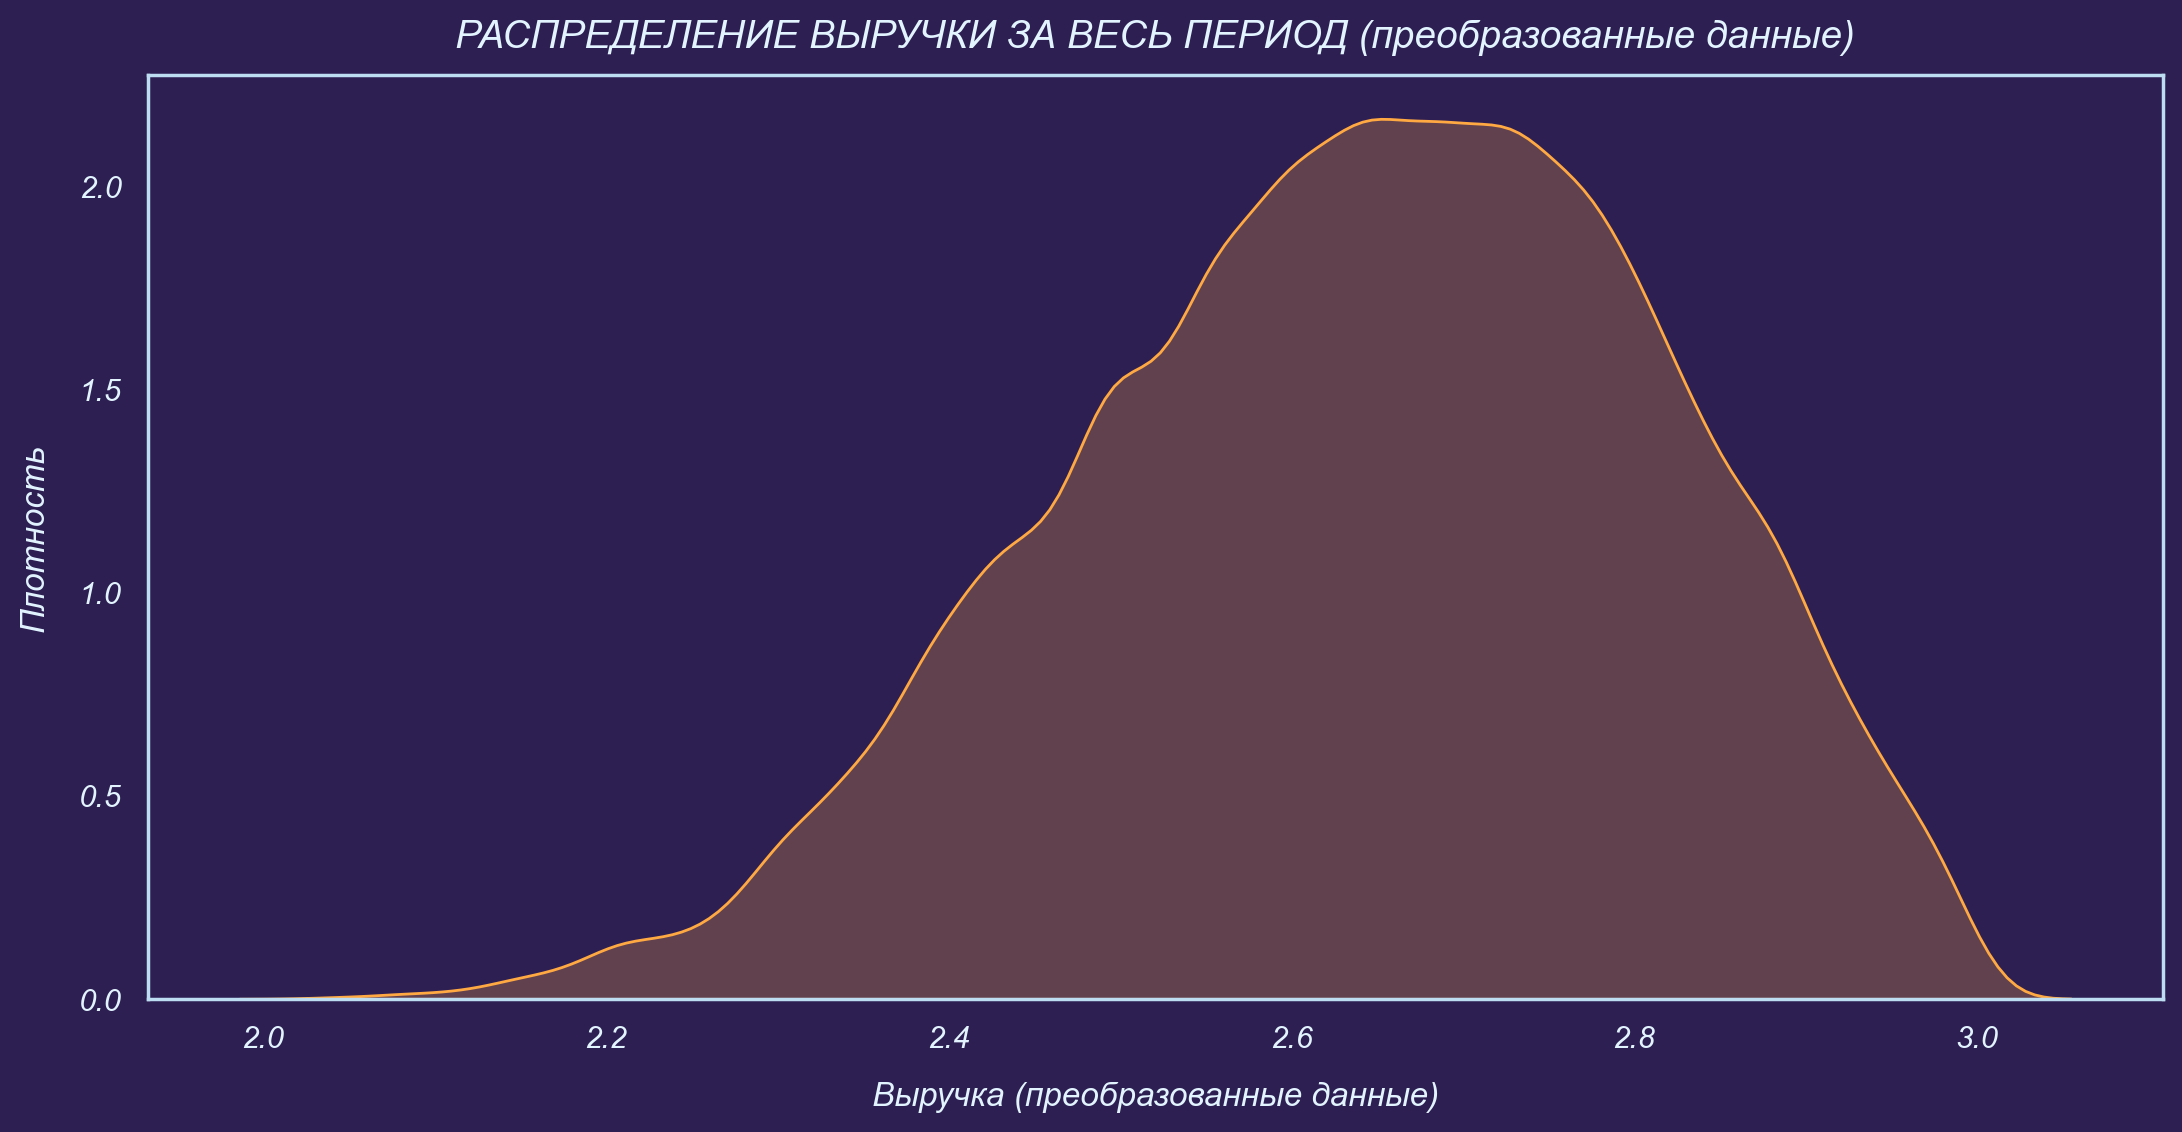

In [60]:
sns.kdeplot(data=df_test['revenue_new'],
            fill=True).set(
     title='РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ЗА ВЕСЬ ПЕРИОД (преобразованные данные)',
     xlabel='Выручка (преобразованные данные)',
     ylabel='Плотность')
plt.show()

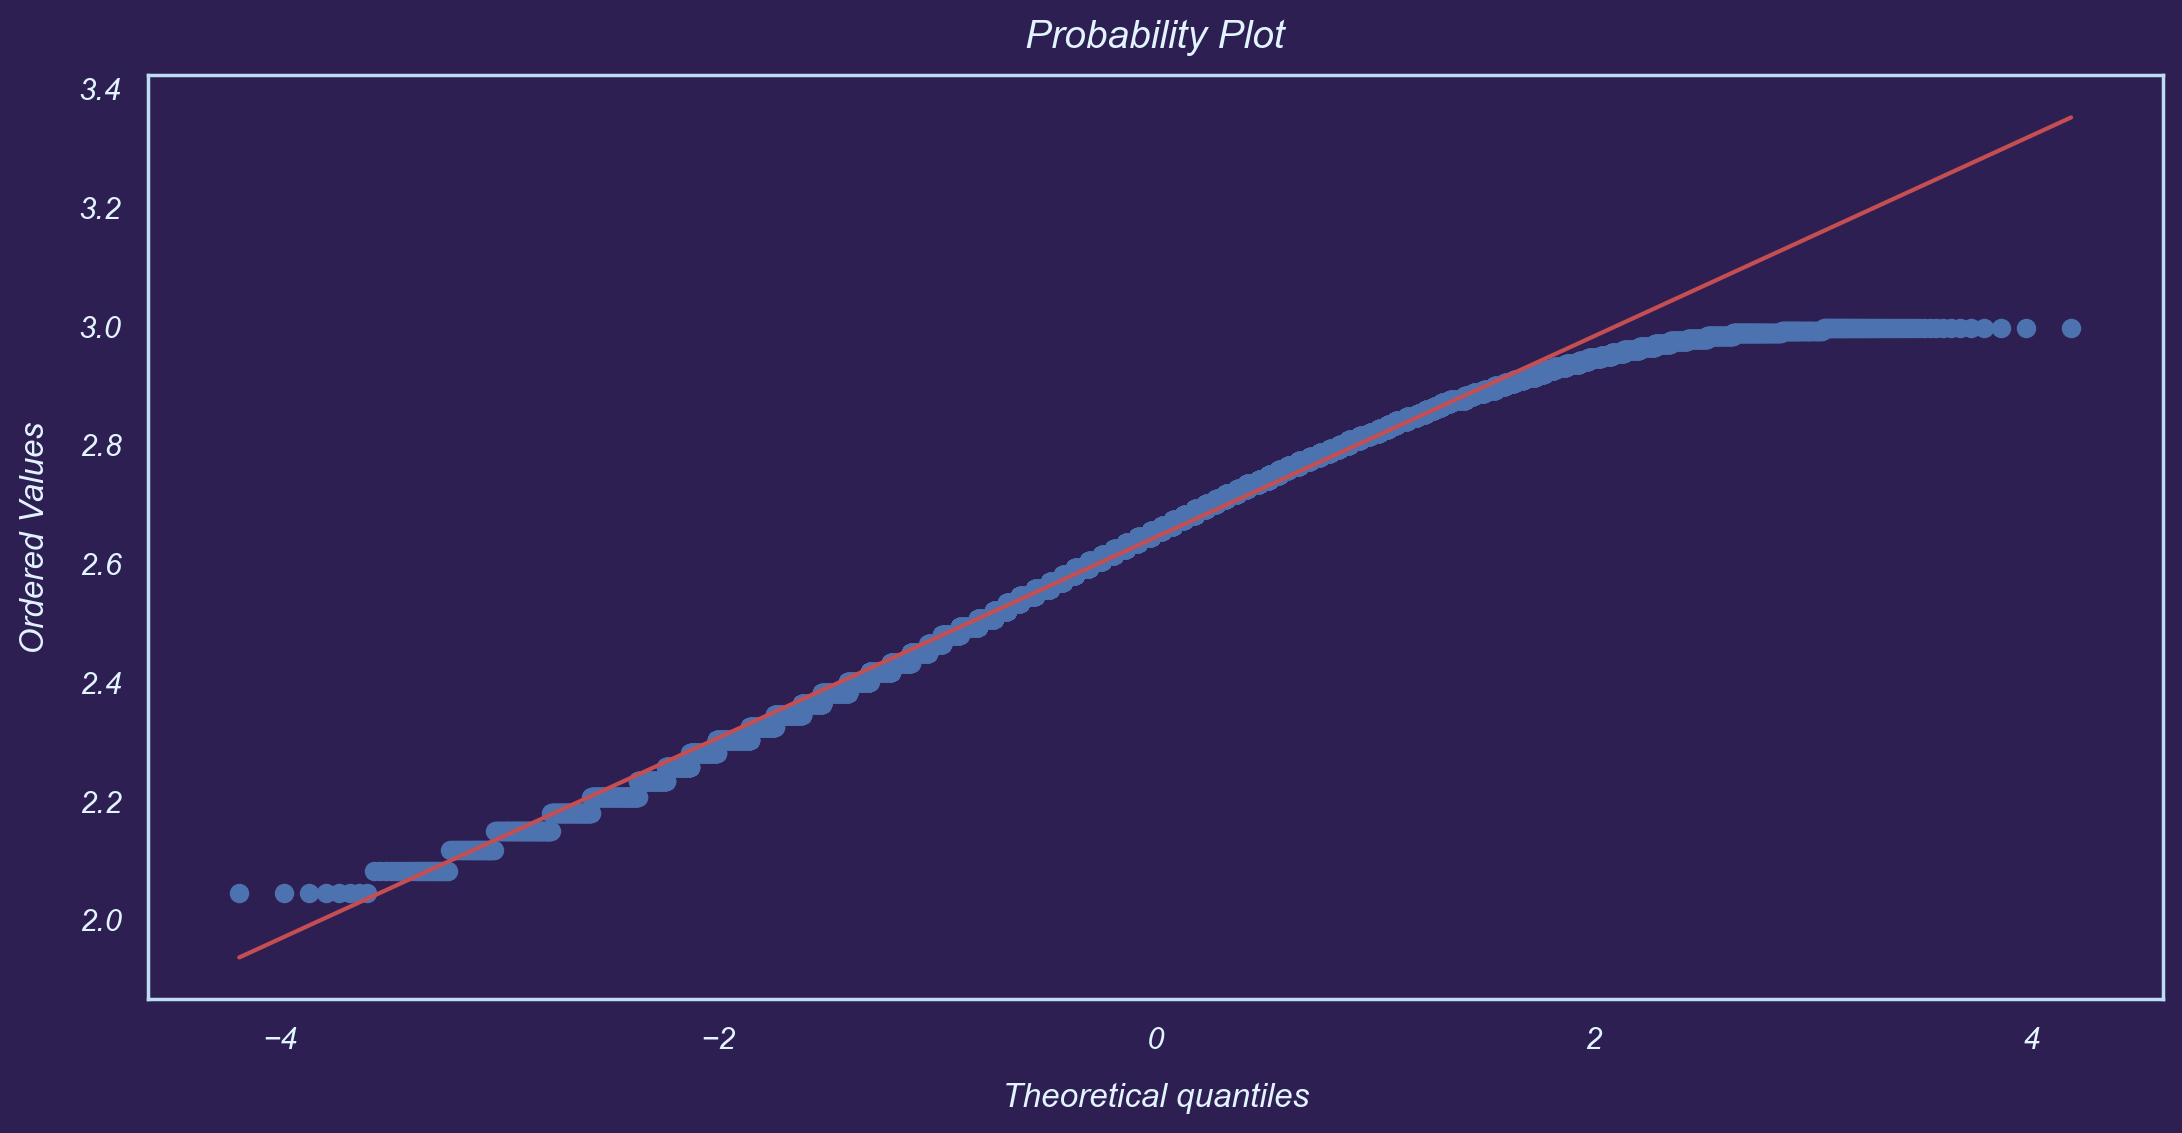

In [61]:
st.probplot(df_test['revenue_new'], dist='norm', plot=plt)
plt.show()

Привести данные к нормальному распределению не получилось. 

[Вернуться к навигации](#0)

## Исследование сезонности продаж <a class="anchor" id="19"></a>

### Подготовка к исследованию сезонности

In [62]:
months = {1: 'Январь',
         2: 'Февраль',
         3: 'Март',
         4: 'Апрель',
         5: 'Май',
         6: 'Июнь',
         7: 'Июль',
         8: 'Август',
         9: 'Сентябрь',
         10: 'Октябрь',
         11: 'Ноябрь',
         12: 'Декабрь'}

# Словарь пока не используется
df['purchase_month'] = df['purchase_date'].dt.month
df['flight_month'] = df['flight_date'].dt.month

In [63]:
seasons = {1: 'Зима',
         2: 'Зима',
         3: 'Весна',
         4: 'Весна',
         5: 'Весна',
         6: 'Лето',
         7: 'Лето',
         8: 'Лето',
         9: 'Осень',
         10: 'Осень',
         11: 'Осень',
         12: 'Зима'}

In [64]:
# Для начала заведем отдельный столбец (столбцы) для указания сезона.
df['purchase_season'] = df['purchase_month'].map(seasons)
df['flight_season'] = df['flight_month'].map(seasons)
df.head(3)

purchase_date flight_date  adult  revenue airport_from airport_to  local  \
0    2021-12-07  2022-01-11      1      200          MOW        KGD      1   
1    2021-12-31  2022-01-03      1      610          UUS        OVB      1   
2    2021-11-28  2022-01-04      1      390          KGD        MOW      1   

   loyalty  online purchase_weekday flight_weekday  purchase_month  \
0        0       1          Вторник        Вторник              12   
1        0       0          Пятница    Понедельник              12   
2        1       1      Воскресенье        Вторник              11   

   flight_month purchase_season flight_season  
0             1            Зима          Зима  
1             1            Зима          Зима  
2             1           Осень          Зима

### Столбчатая диаграмма выручки по сезонам <a class="anchor" id="20"></a>

In [65]:
revenue_per_season = df.groupby(by='purchase_season')['revenue'].sum().reset_index().sort_values('revenue')
revenue_per_season

purchase_season  revenue
1            Зима  4457410
3           Осень  4848410
0           Весна  5572360
2            Лето  6724190

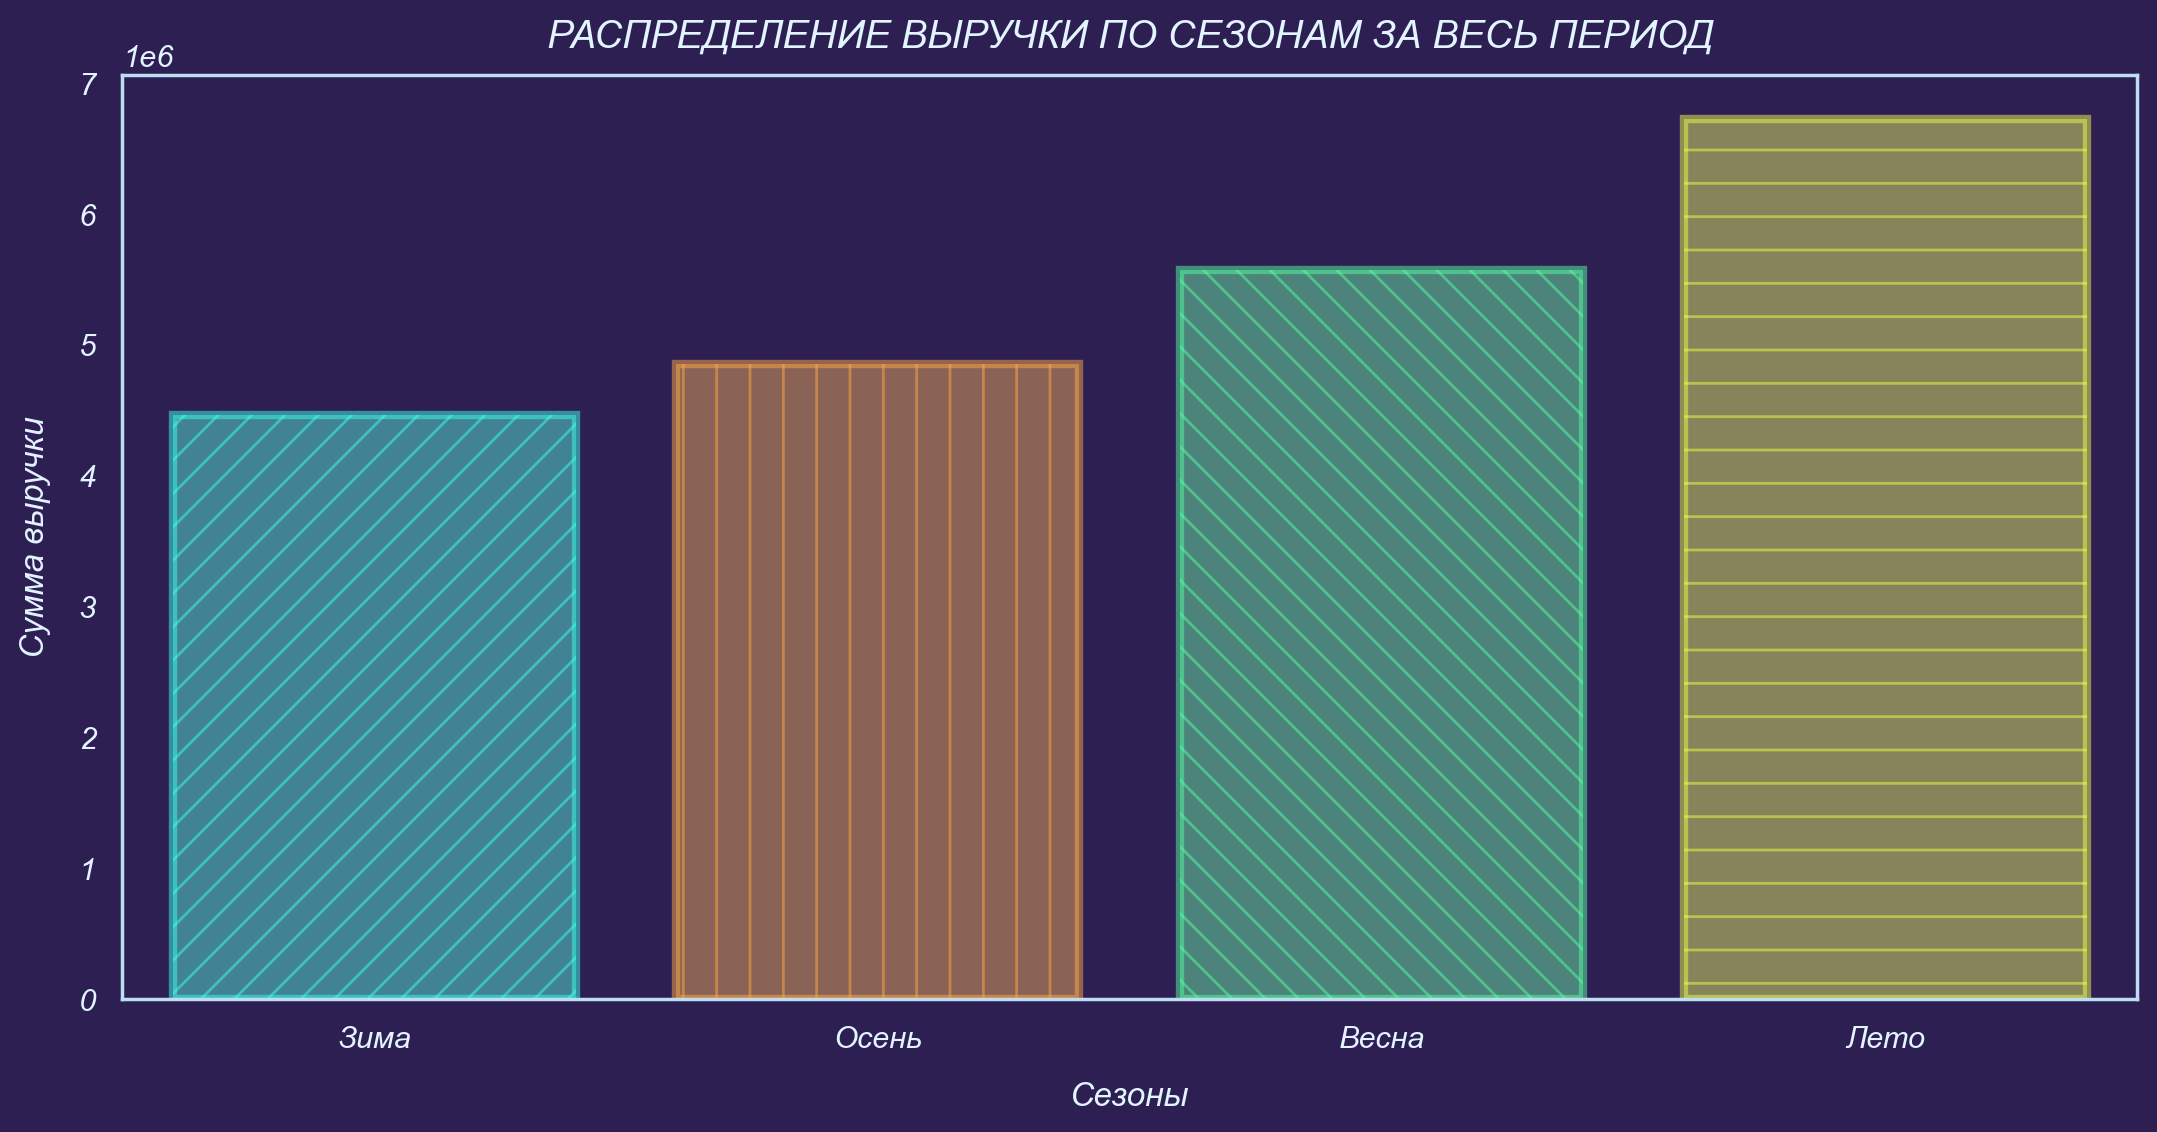

In [66]:
sns.barplot(data=revenue_per_season, x='purchase_season', y = 'revenue', 
            edgecolor=['#3dffe8', '#ffa943', '#55ffa0', '#f0ff4c'], 
            linewidth=3,
            hatch = ['//', '|', '\\\\',  '-'],
            palette = ['#3dffe8', '#ffa943', '#55ffa0', '#f0ff4c'],
            alpha=0.5
           ).set(
            title='РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО СЕЗОНАМ ЗА ВЕСЬ ПЕРИОД',
            xlabel='Сезоны',
            ylabel='Сумма выручки')

plt.show()

Судя по столбчатой диаграмме, присутсвуют различие в объеме выручки в зависимости от сезона.    
Посмотрим на различия в выручке осенью и зимой.

[Вернуться к навигации](#0)

### Проверка различий между выручкой осенью и зимой <a class="anchor" id="21"></a>

#### Проверка на нормальность распределения

In [67]:
# Подготовим данные для обоих сезонов
df_autumn = df[df['purchase_season']=='Осень']
edge = find_edge_high(df_autumn['revenue'])
df_autumn = df_autumn[df_autumn['revenue'] <= edge]

df_winter = df[df['purchase_season']=='Зима']
edge = find_edge_high(df_winter['revenue'])
df_winter = df_winter[df_winter['revenue'] <= edge]

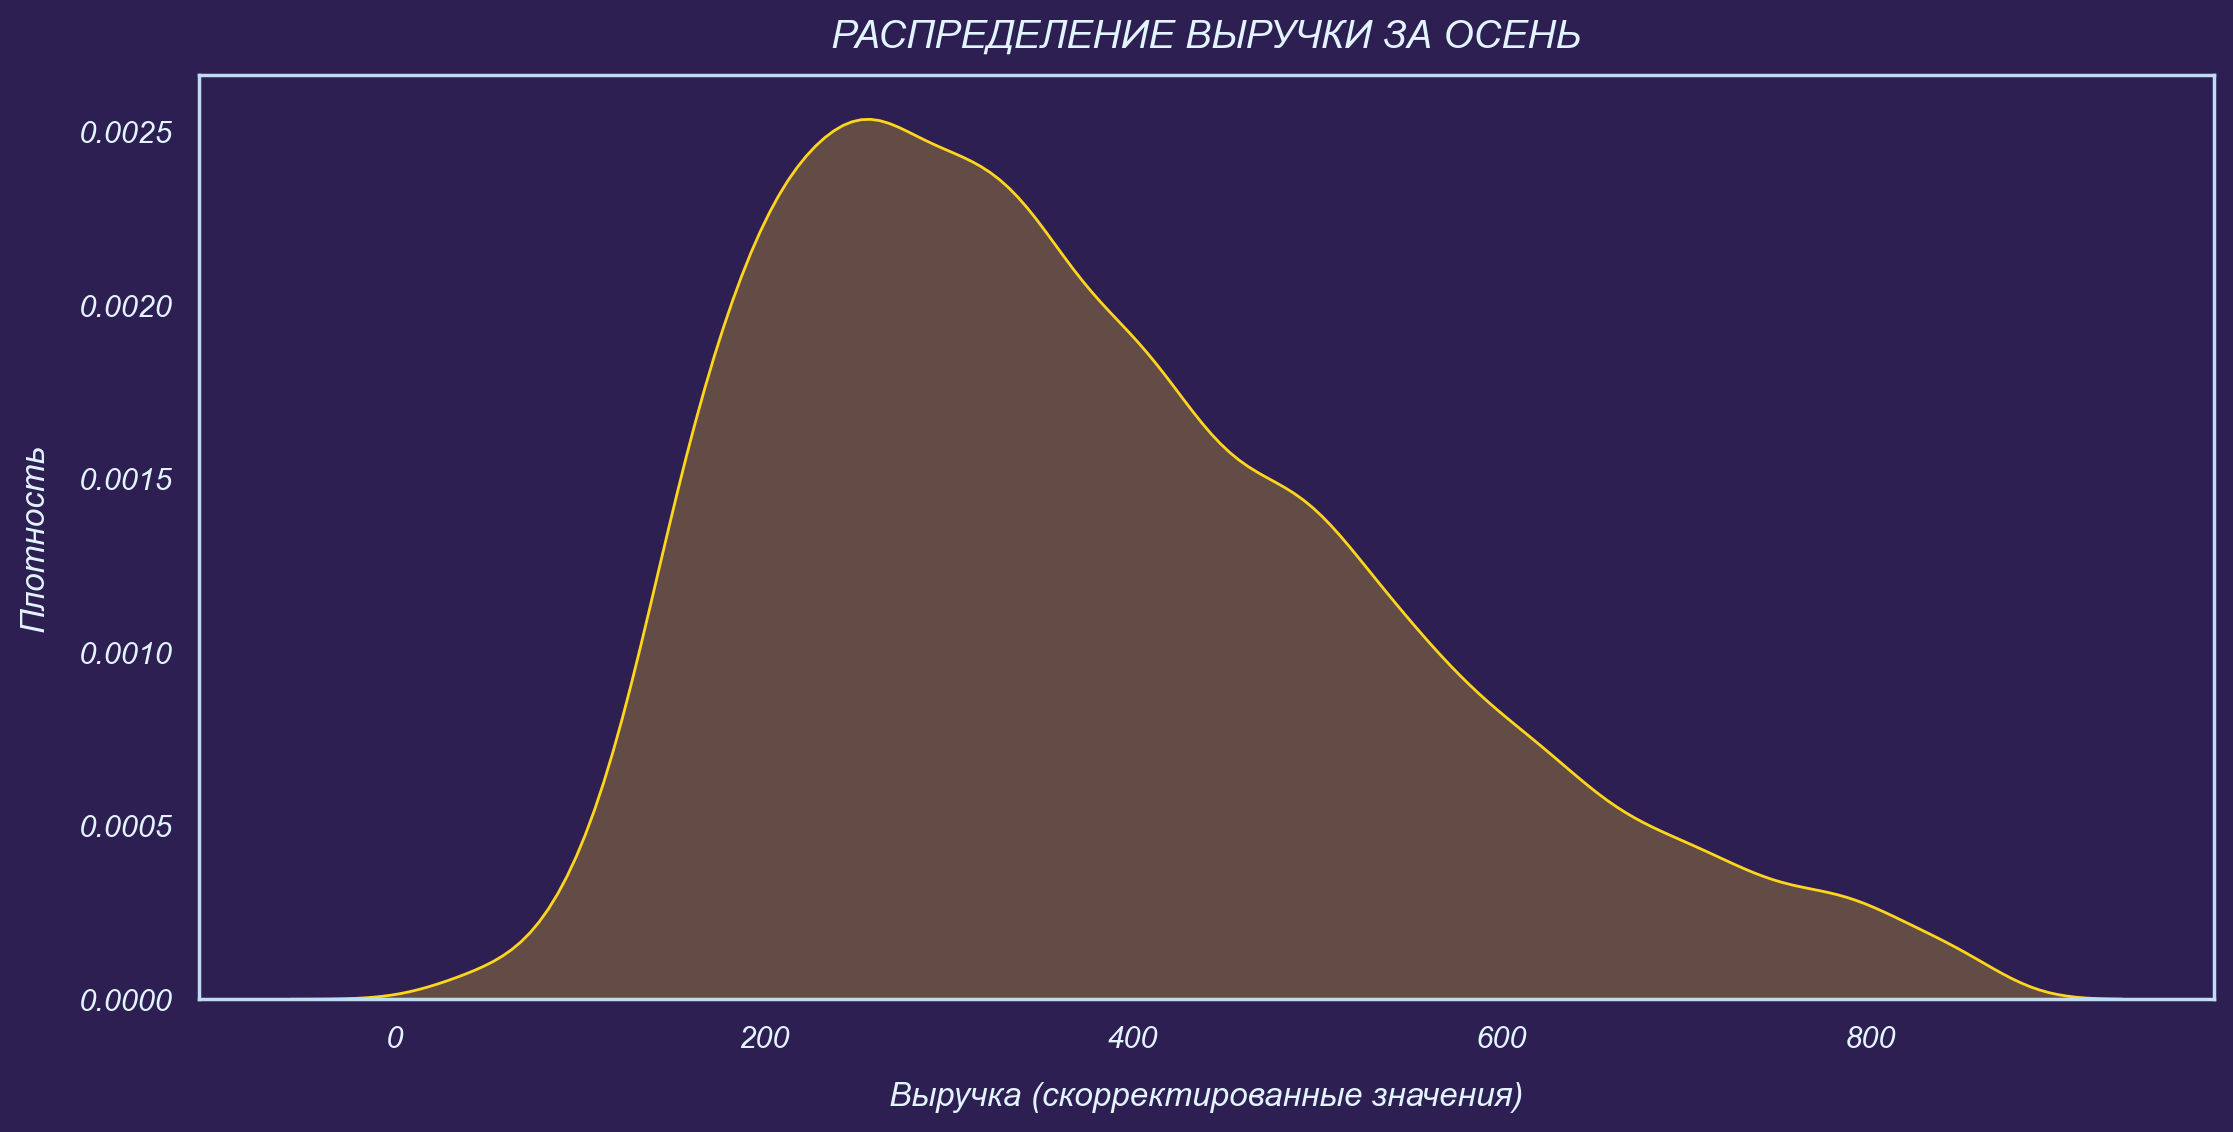

In [68]:
# Посмотрим, как распределены данные
sns.kdeplot(data=df_autumn['revenue'],
            fill=True, color=YELLOW).set(
     title='РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ЗА ОСЕНЬ',
     xlabel='Выручка (скорректированные значения)',
     ylabel='Плотность')
plt.show()

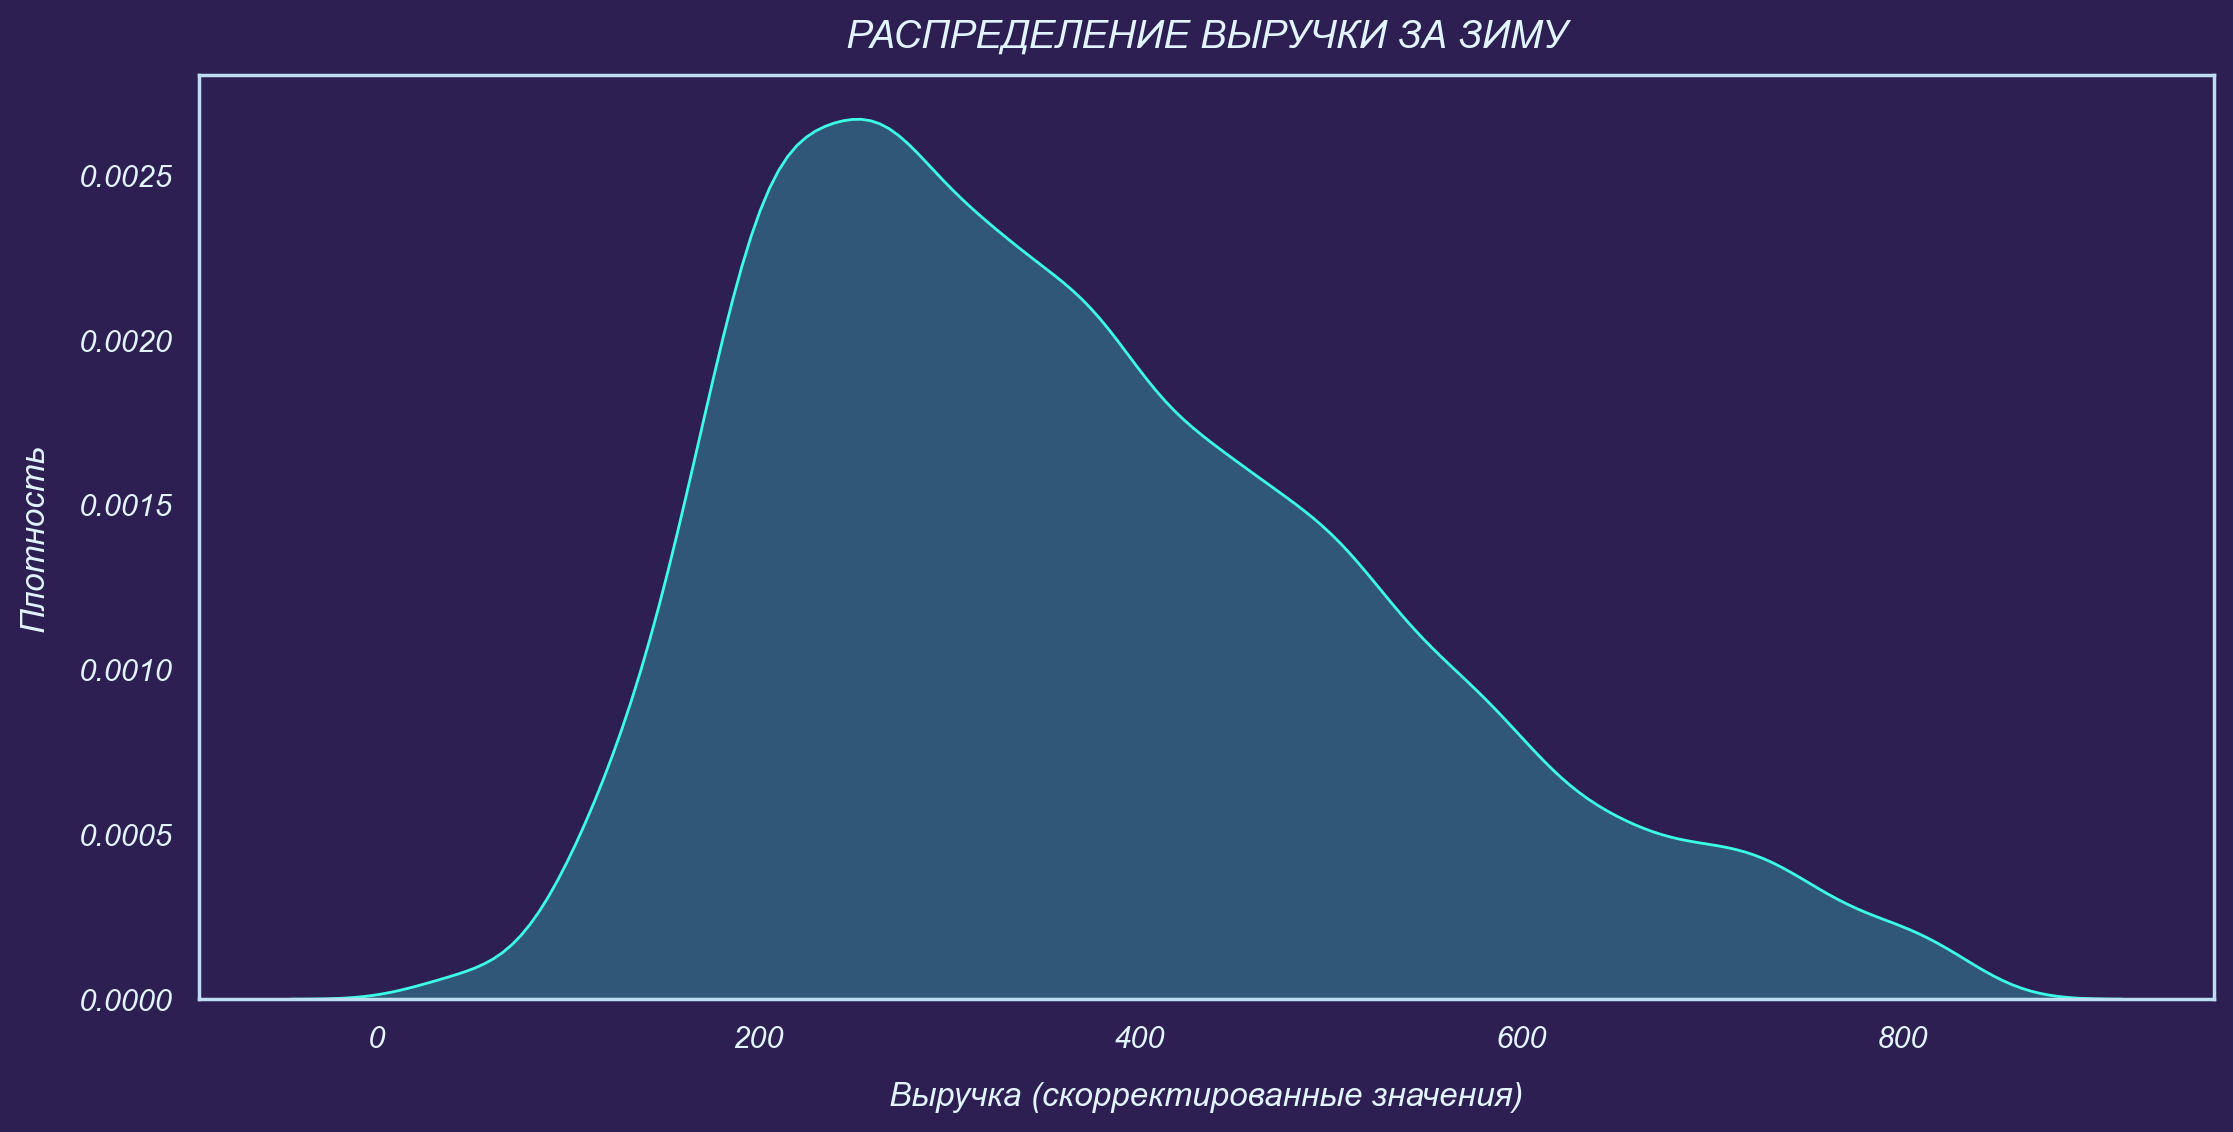

In [69]:
sns.kdeplot(data=df_winter['revenue'],
            fill=True, color=LIGHTBLUE).set(
     title='РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ЗА ЗИМУ',
     xlabel='Выручка (скорректированные значения)',
     ylabel='Плотность')
plt.show()

Уже очеивдно, что выборки не распределены нормально, поэтому нельзя провести t-test. Но можно провести непараметрический тест Манна-Уитни.

#### Тест Манна-Уитни

1. H0 = между выборками нет различия, т.е. распределение выручки за осень соответствует распределению выручки за зиму;     
H1 = между выборками есть различия.
2. Уровень статистической значимости: alpha = 0.05    
При p-value < alpha отвергаем H0.

In [70]:
df_autumn = df[df['purchase_season']=='Осень']
df_winter = df[df['purchase_season']=='Зима']

In [71]:
result = st.mannwhitneyu(df_autumn['revenue'], df_winter['revenue'], use_continuity=False)
print(round(result.pvalue, 5), result.statistic)
print('Отвергаем Н0' if result.pvalue < 0.05 else 'Нет оснований отвергнуть H0')

0.28904 72736568.5
Нет оснований отвергнуть H0


#### Тест Манна-Уитни вручную

In [72]:
# Проведем тест Манна-Уитни вручную ради интереса
# Сделаем отдельную таблицу для расчетов
mw_test_df = df[df['purchase_season'].isin(('Осень', 'Зима'))][['revenue', 'purchase_season']].sort_values('revenue')

# Проставим ранги для всех строк
# mw_test_df['rank'] = np.arange(1, len(mw_test_df)+1)

# Значения могут оказаться одинаковыми, поэтому просто проставить числа от 1 до N нельзя, оказывается.

mw_test_df['rank'] = st.rankdata(mw_test_df['revenue'])
mw_test_df.tail(5)

revenue purchase_season     rank
19297     2900           Осень  24038.0
901       2990           Осень  24039.0
19265     3430           Осень  24040.0
19311     4000           Осень  24041.0
26741     5200            Зима  24042.0

In [73]:
# Посчитаем сумму в каждой группе
s1 = mw_test_df[mw_test_df['purchase_season']=='Осень']['rank'].sum()
n1 = mw_test_df[mw_test_df['purchase_season']=='Осень']['rank'].count()
s2 = mw_test_df[mw_test_df['purchase_season']=='Зима']['rank'].sum()
n2 = mw_test_df[mw_test_df['purchase_season']=='Зима']['rank'].count()
print('Количество значений в каждой группе:', n1, n2)
print('Значение сумм рангов по группам:', s1, s2)

Количество значений в каждой группе: 12435 11607
Значение сумм рангов по группам: 150057398.5 138963504.5


In [74]:
# Считаем U-статистику
u1 = n1 * n2 + (n1 * n1 + n1) / 2 - s1
u2 = n1 * n2 + (n2 * n2 + n2) / 2 - s2
print(u1, u2)
# В scipy.stats.mannwhitneyu из U1, U2 выбирают максимум, поэтому значения получились разными
u = u1 if u1 <= u2 else u2
print('Значение U-статистики =', u)

71596476.5 72736568.5
Значение U-статистики = 71596476.5


In [75]:
# Считаем Z-value
mu = n1 * n2 / 2
sigma = (n1 * n2 * (n1 + n2 + 1) / 12) ** (0.5)
z = (u - mu) / sigma
print('Z-значение =', round(z, 5))

Z-значение = -1.06004


Так как у нас были одинаковые значения (а следовательно, одинаковые ранги), для подсчета σ следовало бы использовать другую формулу.    
В scipy.stats.mannwhitneyu есть корректировка значения σ при наличии одинаковых рангов.     
(https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/_mannwhitneyu.py#L107)

![](sigma_computation.png)

In [76]:
# Находим p-value
def f(x):
    return (1/(2*pi)**(1/2))*e**(-(x**2)/2)

pvalue = quad(f, abs(z), inf)[0] * 2
print('P-value =', round(pvalue, 5))

P-value = 0.28913


Полученное p-value отличается от того, что получилось при использовании scipy.stats.mannwhitneyu, причины уже были озвучены выше.
Даже при подсчете "вручную" p-value получился больше 0.05, следовательно нулевую гипотезу мы отвергнуть не можем.

#### Вывод

U-критерий Манна-Уитни показал, что нельзя опровергнуть гипотезу о том, что между выборками (выручка за осень и выручка за зиму) есть различия в распределении. Таким образом, пока что мы не можем говорить о существенных различиях между выручкой осенью и зимой.

[Вернуться к навигации](#0)

### Различие между выручкой по месяцам <a class="anchor" id="22"></a>

#### Столбчатая диаграмма распределения выручки по месяцам + детализация по возрасту

In [77]:
revenue_per_month= df.groupby(by=['purchase_month'])['revenue'].sum().reset_index().sort_values('purchase_month')
revenue_per_month.columns = ['month', 'revenue']
revenue_per_month.head(3)

month  revenue
0      1  1352390
1      2  1347770
2      3  1826430

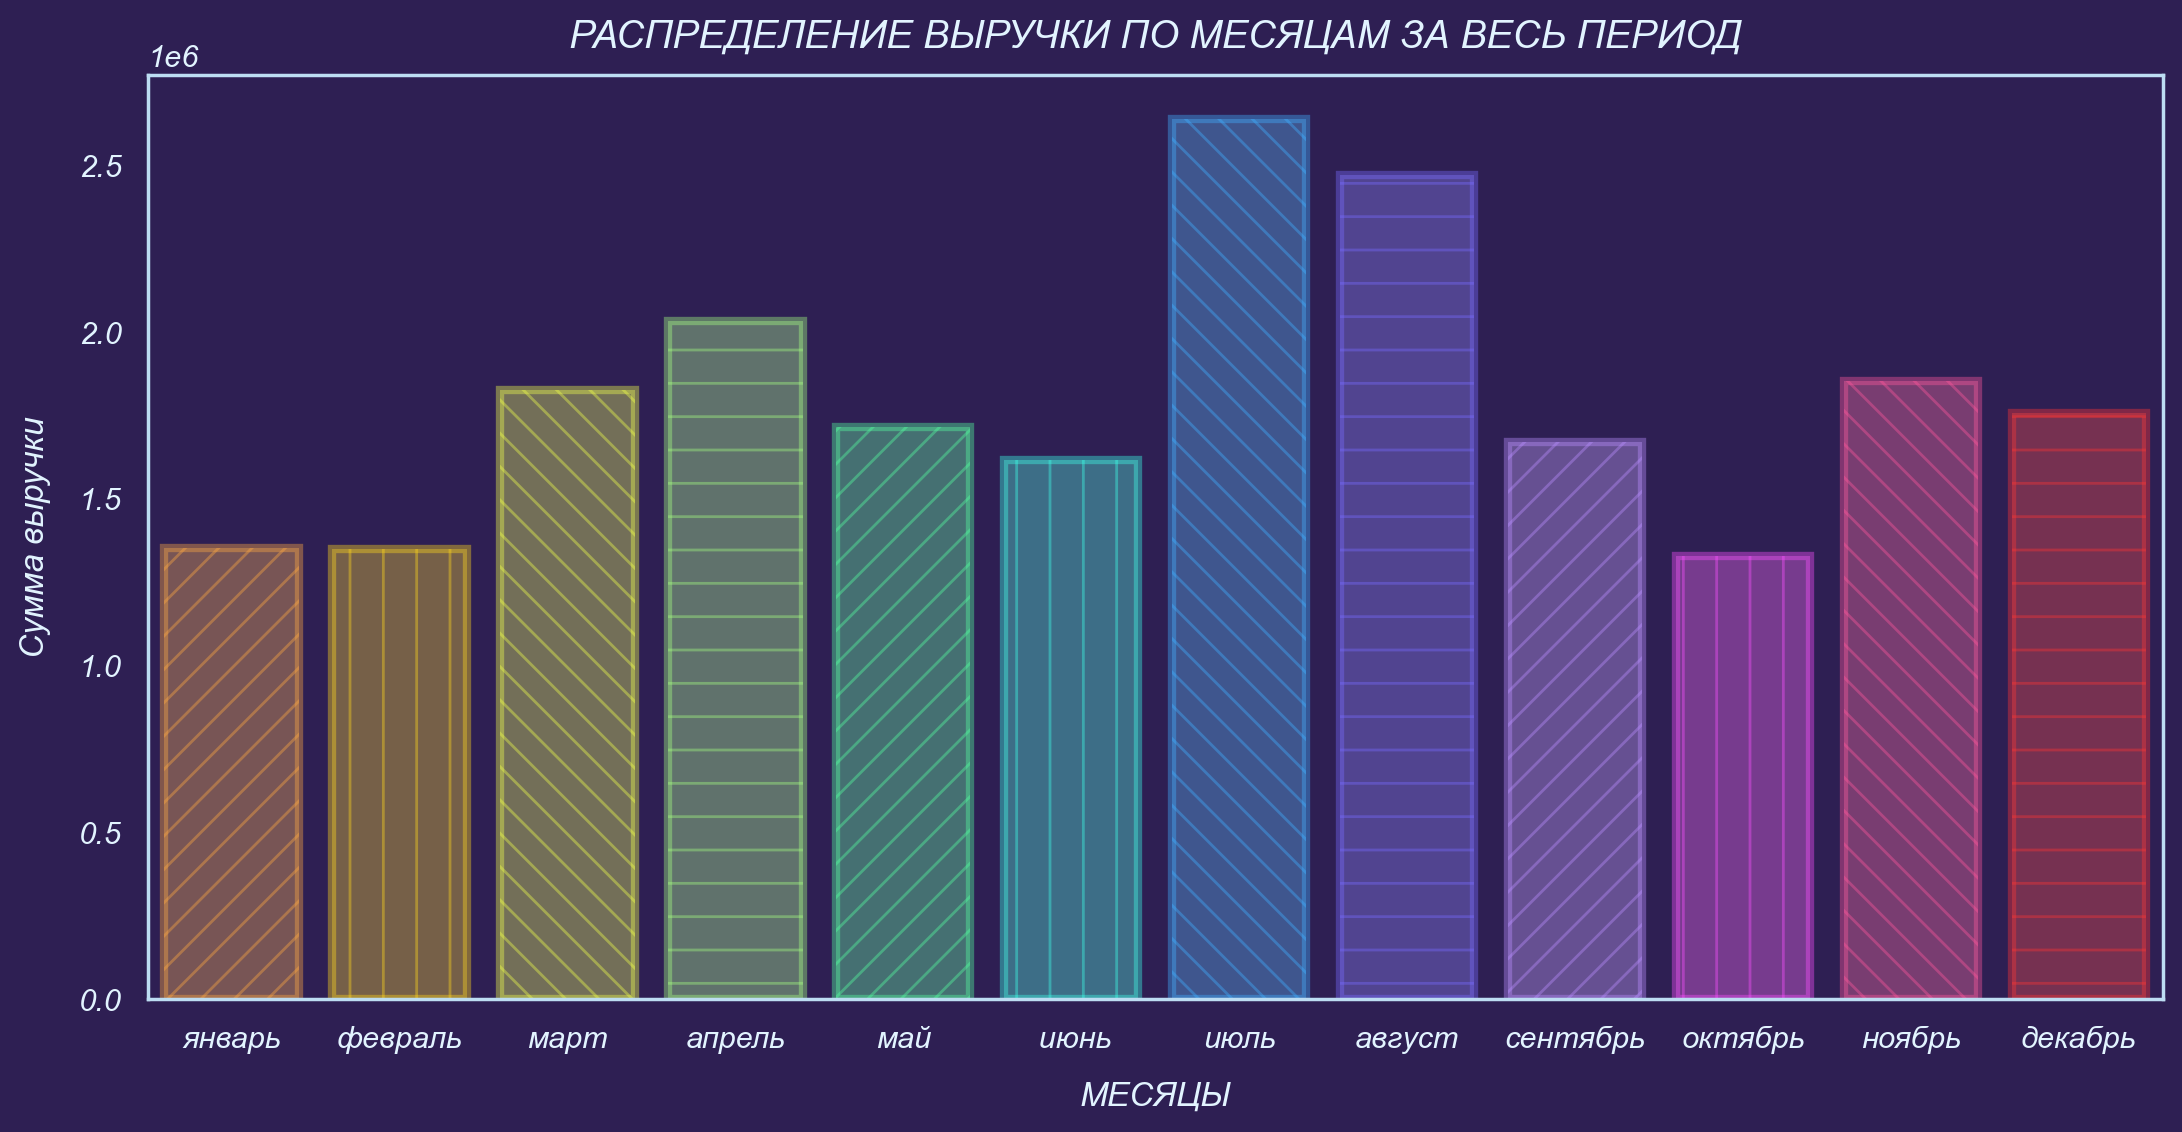

In [78]:
sns.barplot(data=revenue_per_month, x='month', y = 'revenue', 
            edgecolor=(['#ffa943', '#ffd61c', '#f0ff4c', '#a6ff82',
                       '#55ffa0', '#3dffe8', '#41afff', '#786cff',
                       '#b98eff', '#fb50ff', '#ff579d', '#fc3535']), 
            linewidth=3,
            hatch = ['//', '|', '\\\\',  '-',
                    '//', '|', '\\\\',  '-',
                    '//', '|', '\\\\',  '-'],
            alpha=0.4
           ).set(
            title='РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО МЕСЯЦАМ ЗА ВЕСЬ ПЕРИОД',
            xlabel='МЕСЯЦЫ',
            ylabel='Сумма выручки')
plt.xticks(range(0, 12), labels = ['январь', 'февраль', 'март', 'апрель', 'май', ' июнь', 
                   'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])

plt.show()

Наблюдается рост в марте 2022 года, возможно, вызванный политическими/экономическими событиями в стране.    
Самая большая выручка приходится на июль и август, эти месяцы почти каждый год становятся временем, когда россияне летают больше всего (наример: https://www.rbc.ru/economics/01/07/2024/667e99f29a7947145a2be512). Интересно посмотреть, рост выручки в эти месяцы в нашем датасете обусловлен увеличением числа покупок или увеличением стоимости покупок. 

In [79]:
revenue_per_month_adult = df.groupby(by=['purchase_month', 'adult'])['revenue'].sum().reset_index().sort_values('purchase_month')
revenue_per_month_adult.head(3)

purchase_month  adult  revenue
0               1     -1      960
1               1      0    69390
2               1      1  1282040

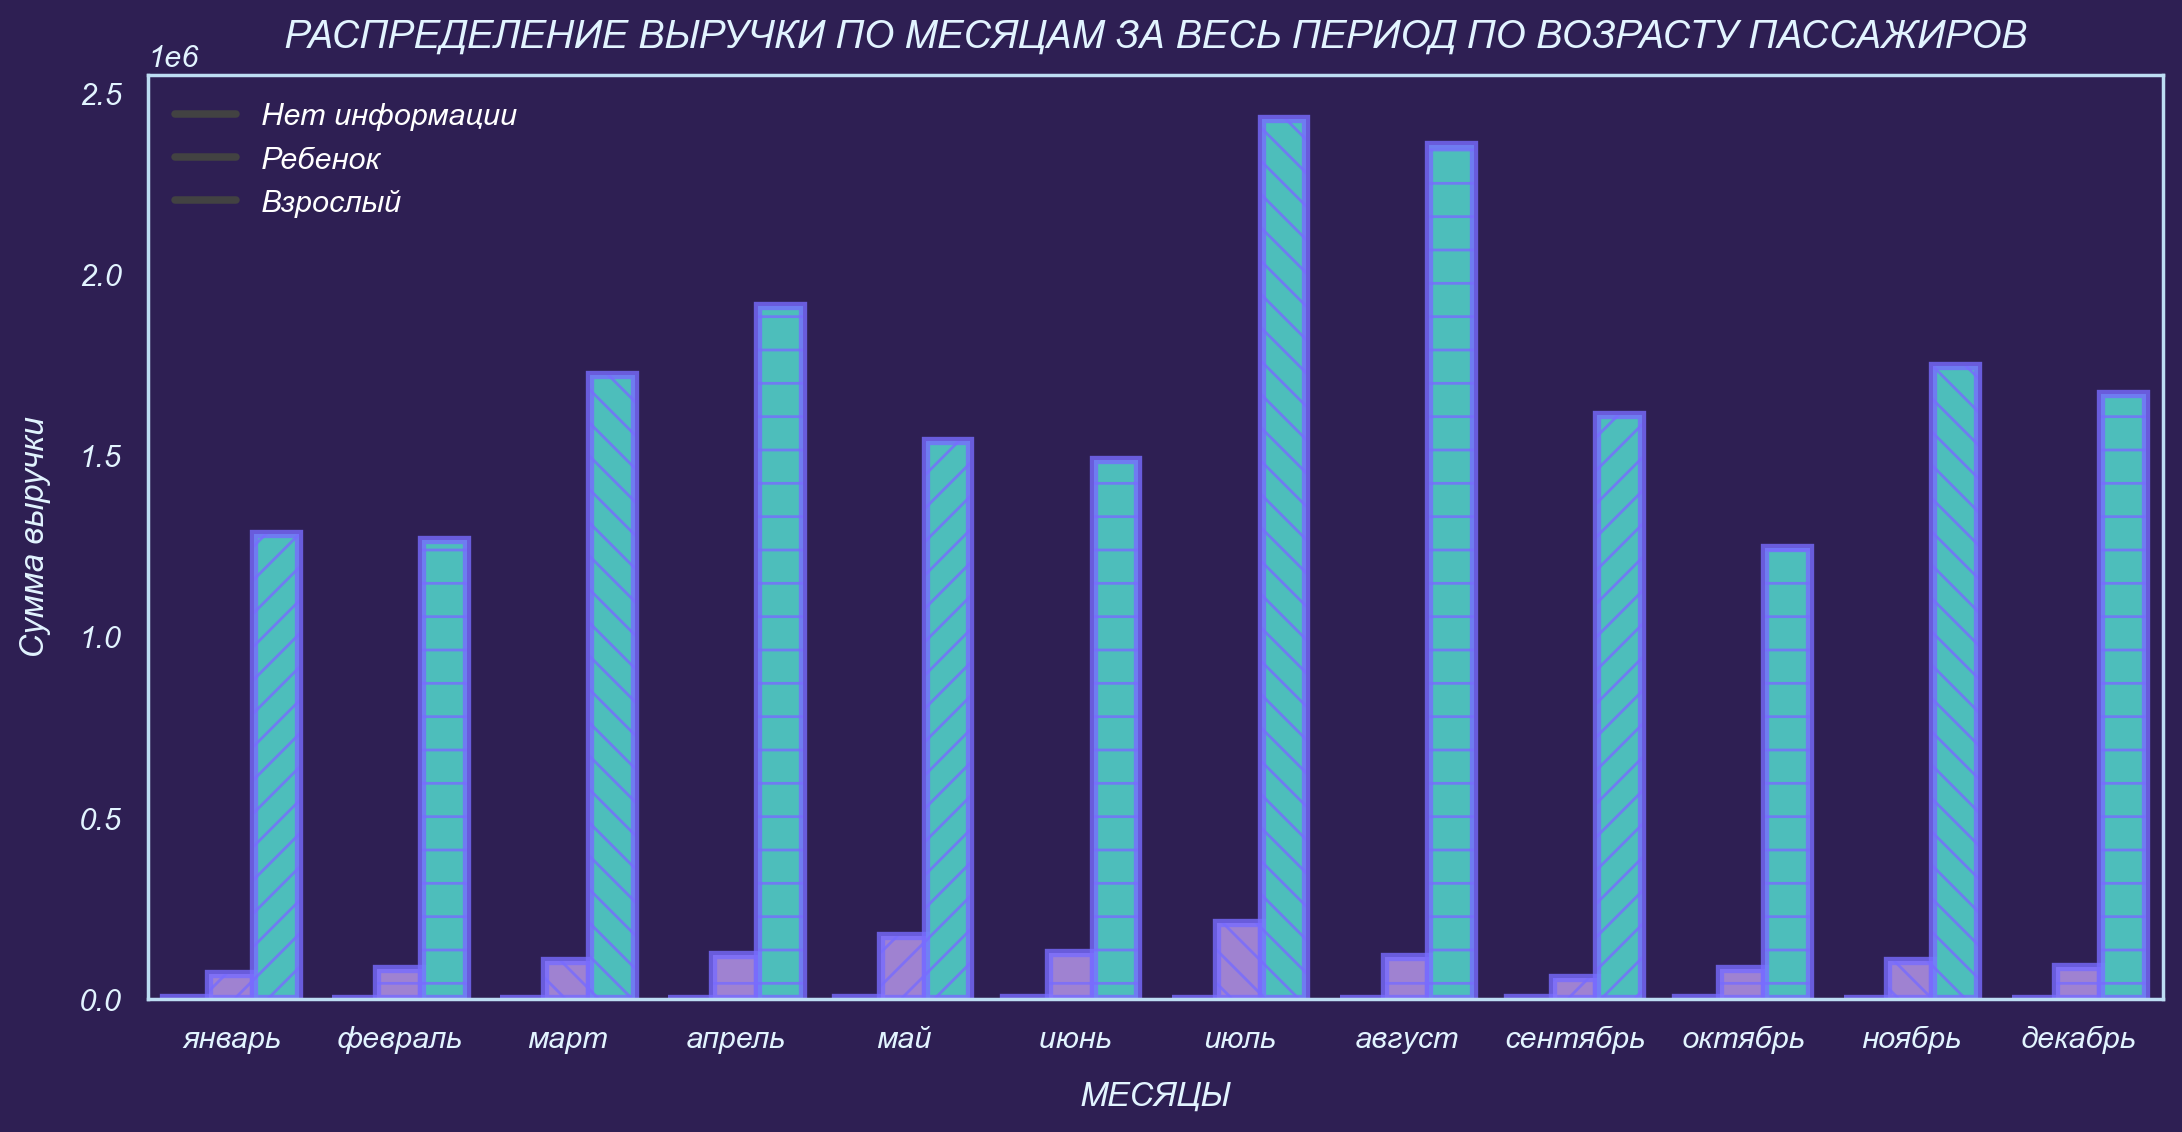

In [80]:
sns.barplot(data=revenue_per_month_adult, x='purchase_month', y = 'revenue', hue='adult',
            edgecolor=(BLUE), 
            linewidth=3,
            hatch = ['//', '-', '\\\\',  '-',
                    '//', '-', '\\\\',  '-',
                    '//', '-', '\\\\',  '-'],
            palette=[YELLOW, LIGHTPURPLE, LIGHTBLUE],
            alpha=0.8,
           ).set(
            title='РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО МЕСЯЦАМ ЗА ВЕСЬ ПЕРИОД ПО ВОЗРАСТУ ПАССАЖИРОВ',
            xlabel='МЕСЯЦЫ',
            ylabel='Сумма выручки')
plt.xticks(range(0, 12), labels = ['январь', 'февраль', 'март', 'апрель', 'май', ' июнь', 
                   'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.legend(labels=['Нет информации', 'Ребенок', 'Взрослый'],
           loc='upper left',
           facecolor='#2e1f53',
           labelcolor='#ffffff',
           edgecolor= '#2e1f53')

plt.show()

Диаграмма показывает, что первый период роста выручки от продажи билетов, пришедшийся на март-апрель 2020 года, практически не проявляется для детской категории пассажиров. А вот период роста в июле-августе так же можно заметить на диаграмме выручки от детских билетов. Вместе с этим в сентябре количество выручки от детских билетов снижается (так же как и выручка от взрослых билетов), возможно, для детских билетов причиной является окончание школьных каникул.

[Вернуться к навигации](#0)

#### Столбчатая диаграмма распределения выручки и числа покупок по месяцам

In [81]:
purchases_per_month = df.groupby(by='purchase_month')['revenue'].count().reset_index().sort_values('purchase_month')
purchases_per_month.columns = ['month', 'count']

In [82]:
# Перейдем к процентам для того, чтобы оба показателя можно было указать на одной диаграмме
total = purchases_per_month['count'].sum()
purchases_per_month['perc'] = round(purchases_per_month['count'] / total * 100, 3)
purchases_per_month['type'] = 'Выручка'

total = revenue_per_month['revenue'].sum()
revenue_per_month['perc'] = round(revenue_per_month['revenue'] / total * 100, 3)
revenue_per_month['type'] = 'Покупки'

In [83]:
new_df = pd.concat([revenue_per_month[['month', 'perc', 'type']], purchases_per_month[['month', 'perc', 'type']]], axis=0)

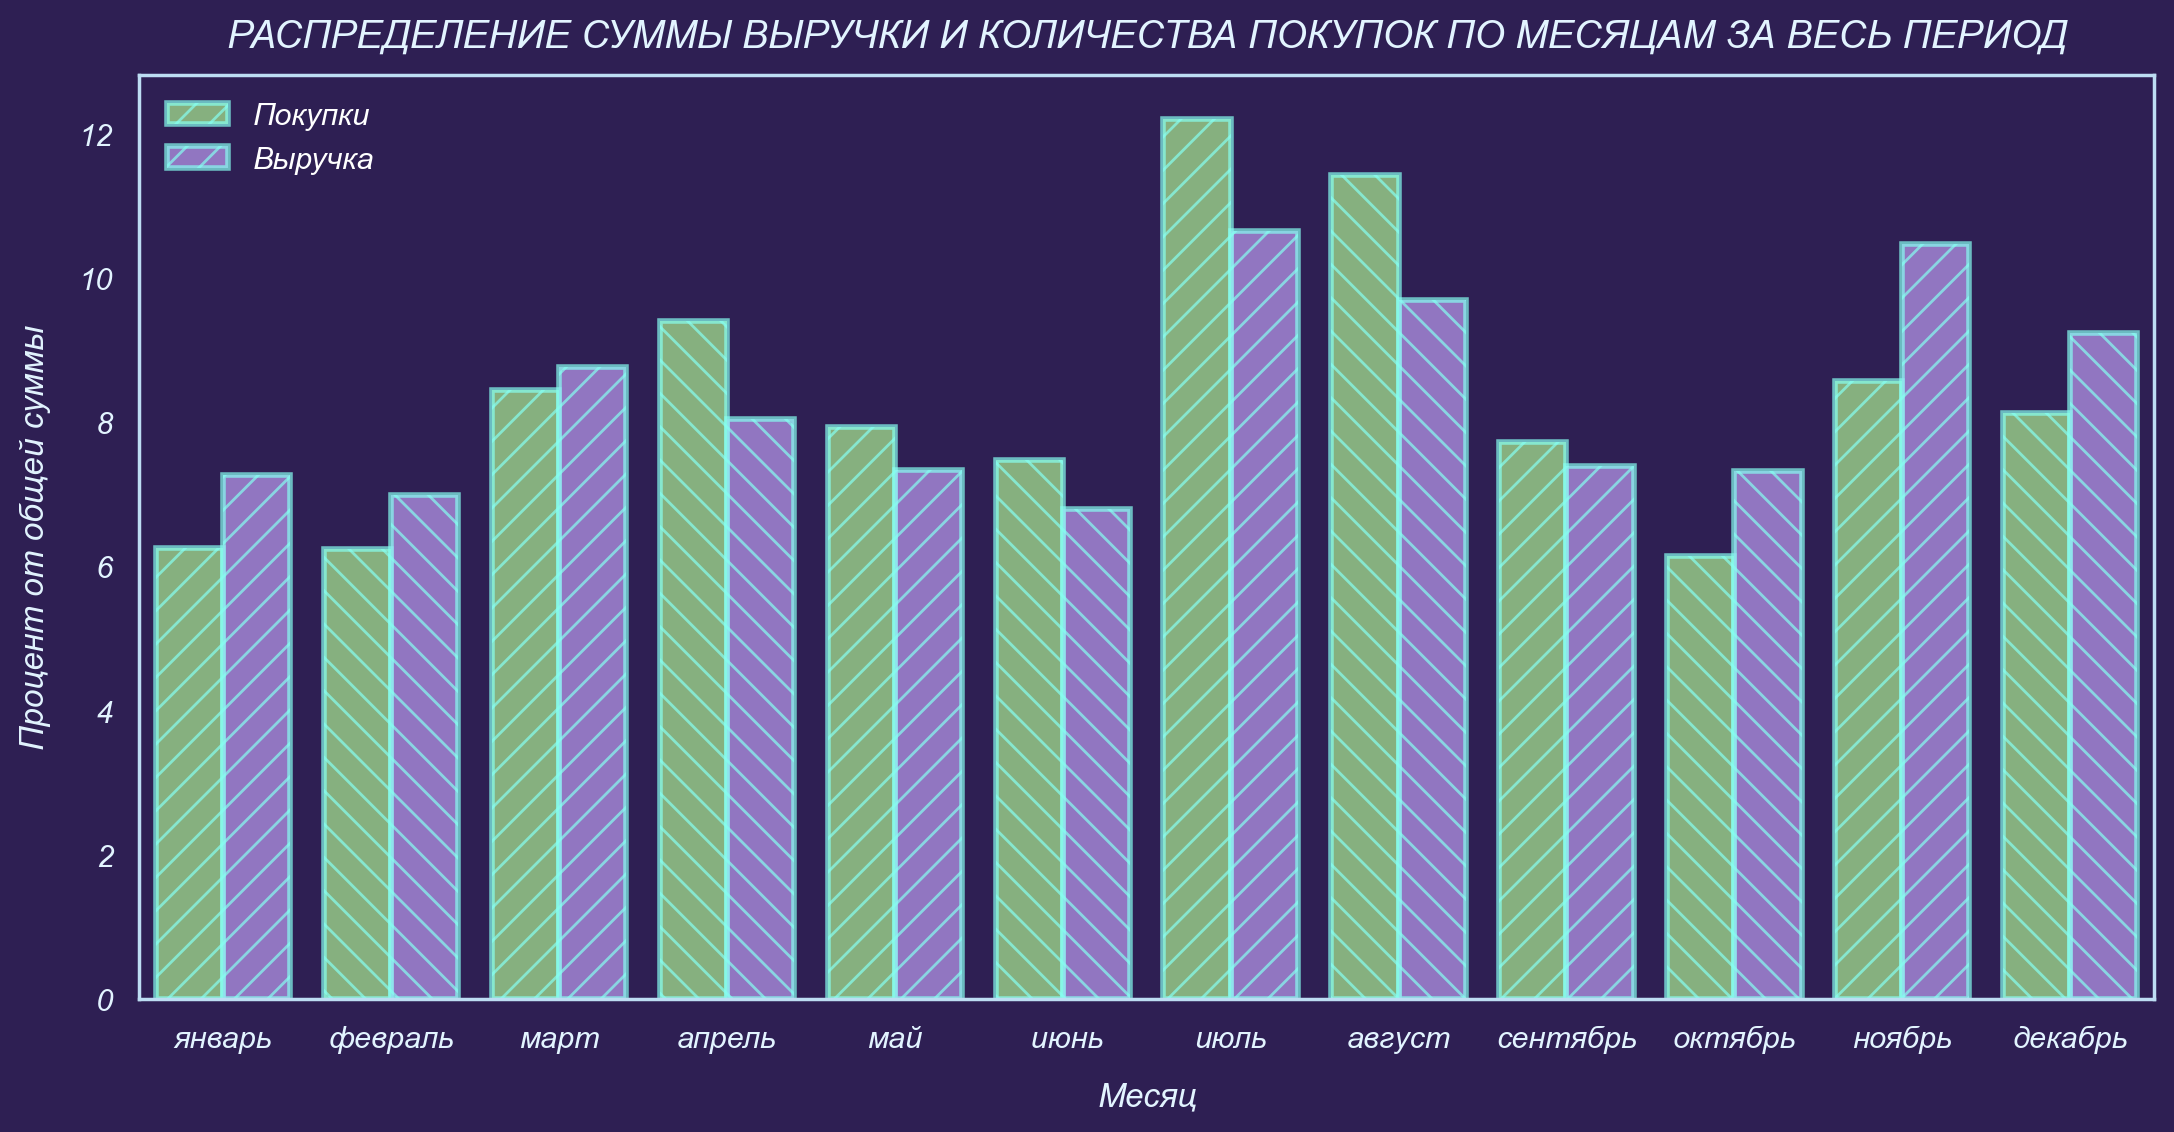

In [84]:
ax = sns.barplot(data=new_df, 
            x='month', y='perc', hue='type', errorbar=None,
            linewidth=2,
            edgecolor='#86fff1',
            hatch = ['//', '\\\\', '//',  '\\\\',
                     '//', '\\\\', '//',  '\\\\',
                     '//', '\\\\', '//',  '\\\\'],
            palette = (['#a6ff82', '#b98eff']),
            alpha = 0.7)
ax.set(title='РАСПРЕДЕЛЕНИЕ СУММЫ ВЫРУЧКИ И КОЛИЧЕСТВА ПОКУПОК ПО МЕСЯЦАМ ЗА ВЕСЬ ПЕРИОД',
       xlabel='Месяц',
       ylabel='Процент от общей суммы')
plt.xticks(range(0, 12), labels = ['январь', 'февраль', 'март', 'апрель', 'май', ' июнь', 
                   'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.legend(title='', 
           loc='upper left',
           facecolor='#2e1f53',
           labelcolor='#ffffff',
           edgecolor= '#2e1f53')

plt.show()

Диаграмма выше демонстрирует, что не всегда рост выручки совпадает с ростом количества заказов. Например, объем выручки в июле и ноябре примерно одинаков, а число покупок в июле значительно больше числа покупок в ноябре. В общих чертах, конечно, оба показателя совпадают по направлению роста (спада). Но важно то, что изменения в выручке зависят не только от изменения количества покупок за месяц, иначе бы графики совпадали бы почти полностью.       

Стоит отметить, что посмотреть действительно ли выручка зависит только от количества покупок можно еще вычислив среднюю стоимость одной покупки за каждый месяц. Если средняя стоимость в разные месяцы меняется незначительно, то рост/спад выручки за определенный месяц почти полностью обусловлен ростом/спадом количества совершенных в этом месяце покупок.    
В нашем случае на объем выручки за месяц значительно влияют и другие факторы.

[Вернуться к навигации](#0)

#### Анализ корреляция выручки и числа покупок

Т.к. данные не имеют нормального распределения, будем использовать коэффициент корреляции Спирмена.

In [85]:
corr_result = pd.DataFrame(data=[revenue_per_month['revenue'], purchases_per_month['count']]).transpose().corr(method='spearman')
corr_result.columns = ['Выручка', 'Число покупок']
corr_result.index = ['Выручка', 'Число покупок']
corr_result

Выручка  Число покупок
Выручка        1.000000       0.867133
Число покупок  0.867133       1.000000

Полученный коэффициент 0,79021 показывает высокую силу связи между объемом выручки за месяц и числом покупок за месяц.    

[Вернуться к навигации](#0)

## Выручка от билетов, купленных за разное время до даты отлета <a class="anchor" id="23"></a>

### Разделение на группы, проверка распределения выручки в группах на нормальность <a class="anchor" id="24"></a>

In [86]:
# Добавим столбец с разницей между датой покупки и датой полета
df['gap'] = (df['flight_date'] - df['purchase_date']).dt.days

In [87]:
# Посмотрим подробнее на получившийся столбец
df['gap'].describe()

count    49362.000000
mean        20.921093
std         30.819986
min          0.000000
25%          3.000000
50%          9.000000
75%         25.000000
max        317.000000
Name: gap, dtype: float64

Максимум дней = 317, при этом 75% всех значений < 25. Т.е. основная масса значений сконцентрирована на маленьком интервале, но при этом встречаются очень большие значения, превышающие среднее значение более чем в 10 раз. Если мы будем строить распределение данных, мы увидим скошенное распределение с длинным хвостом.

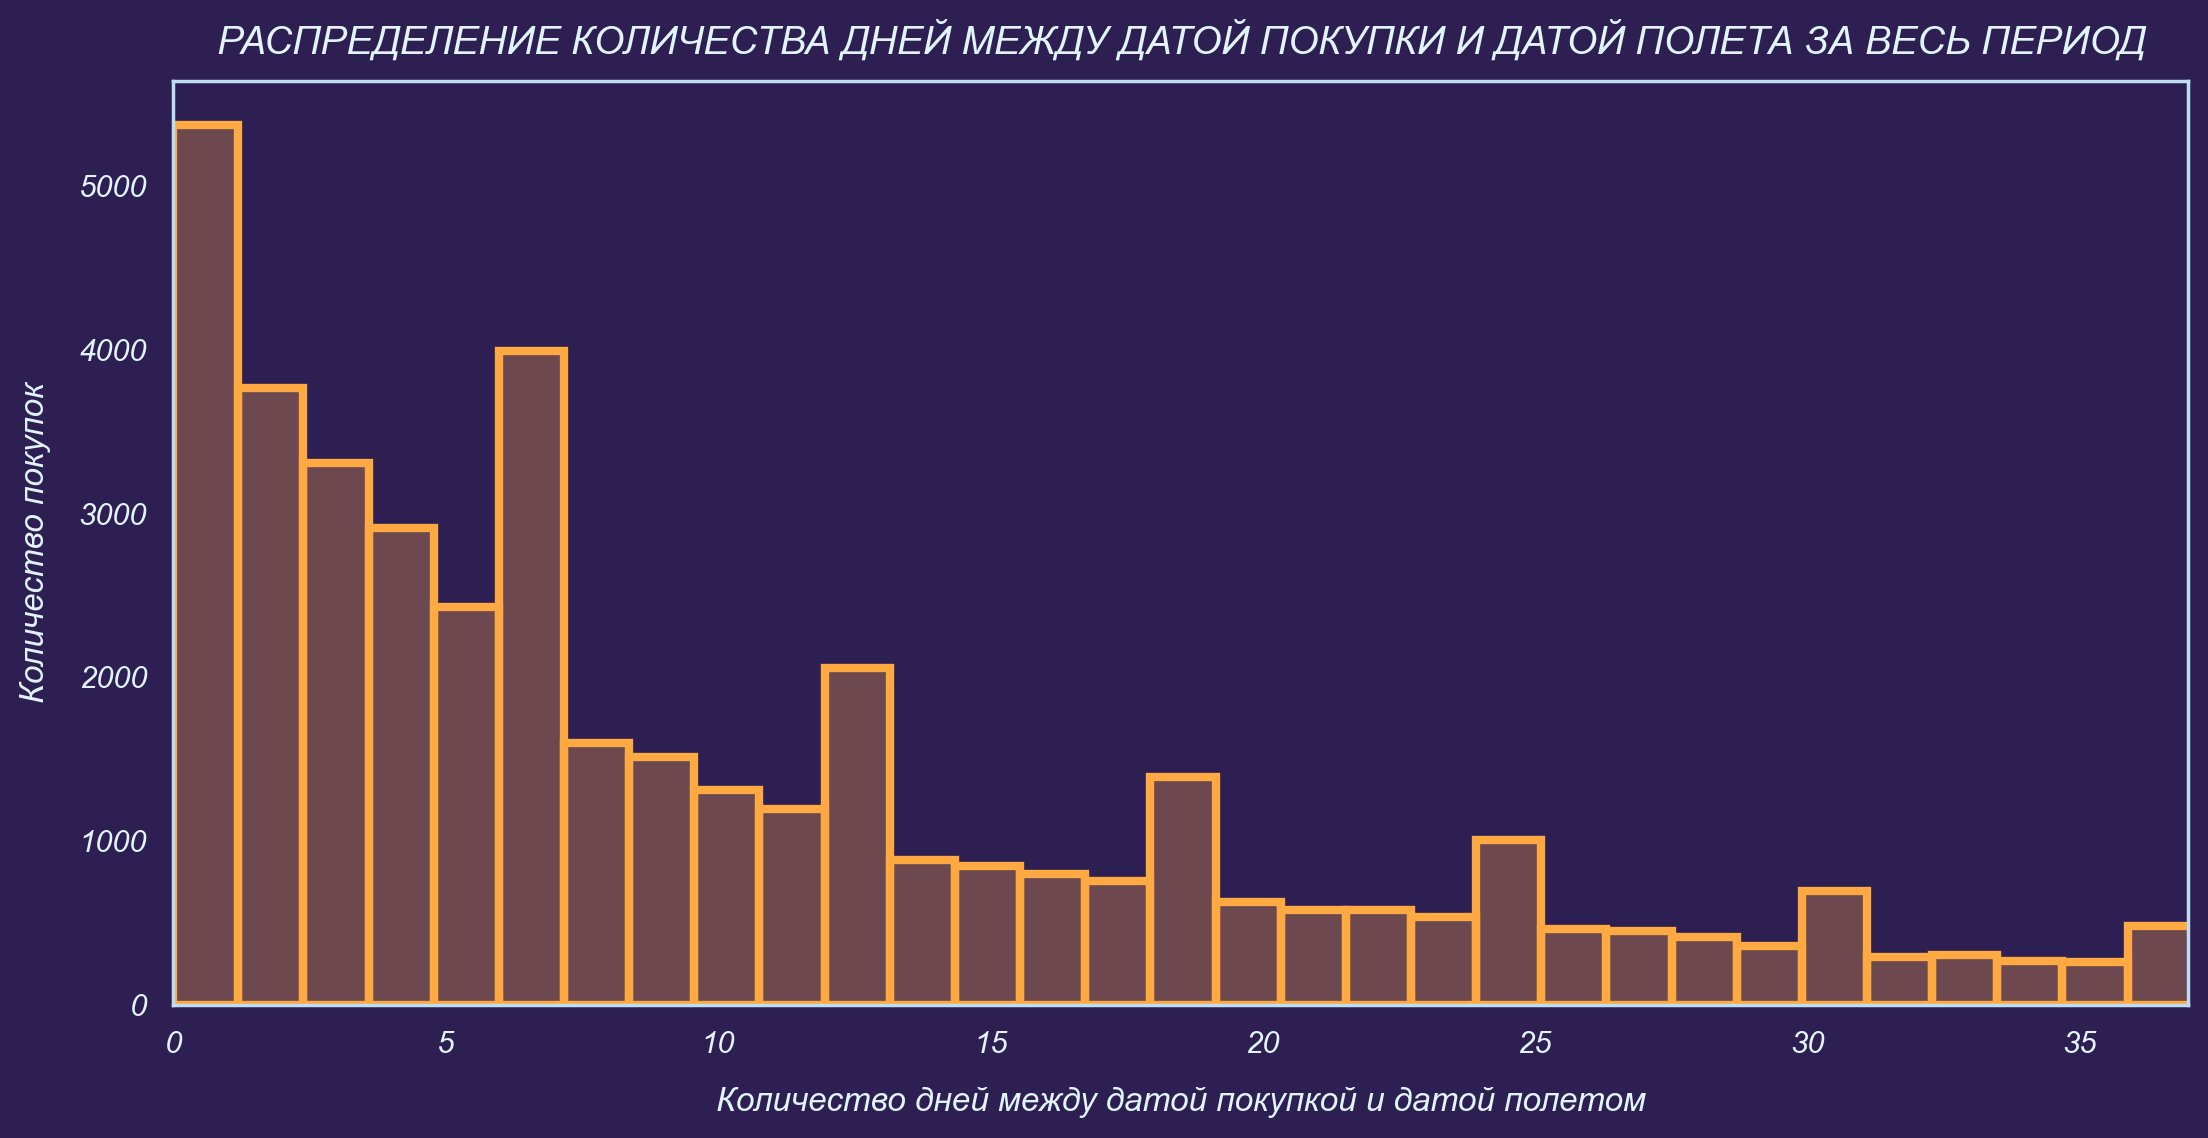

In [88]:
# Укоротим хвост и построим гистограмму  
sns.histplot(data=df['gap'], 
            fill=True,
            linewidth=3,
            edgecolor='#ffa943',
            alpha=0.3).set(
     title='РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ДНЕЙ МЕЖДУ ДАТОЙ ПОКУПКИ И ДАТОЙ ПОЛЕТА ЗА ВЕСЬ ПЕРИОД',
     xlabel='Количество дней между датой покупкой и датой полетом',
     ylabel='Количество покупок',
     xlim = (0, 37))
plt.show()

Так как дальше мы будем анализировать выручку по группам, удалять выбросы не будем - лучше запишем их в отдельную группу и будем их тоже рассматривать отдельно. В том числе по причине того, что нас интересует выручка от продажи билетов и тем клиентам, кто осуществил покупку за очень большой срок до полета.

In [89]:
# в первую группу попадут выбросы
e3 = find_edge_high(df['gap'])
# оставшиееся данные поделим на три группы примерно одного размера
e2 = np.percentile(df[df['gap']<e3]['gap'], 65)
e1 = np.percentile(df[df['gap']<e3]['gap'], 35)
print(e1, e2, e3)

5.0 13.0 58.0


In [90]:
# Группа выбросов
extreme_long = df.query(f'gap > {e3}')[['revenue', 'gap']].copy()
# Группа 3
long = df.query(f'gap <= {e3} & gap > {e2}')[['revenue', 'gap']].copy()
# Группа 2
medium = df.query(f'gap <= {e2} & gap > {e1}')[['revenue', 'gap']].copy()
# Группа 1
short = df.query(f'gap <= {e1}')[['revenue', 'gap']].copy()

Посмотрим на среднюю стоимость билета в каждой группе. Почему не смотрим общую выручку по группам? Потому что в группы попало разное количество данных.

In [91]:
print(f'Средняя стоимость билета в группе с наименьшим числом дней между покупкой и полетом = {round(short["revenue"].mean(), 3)}')
print(f'Средняя стоимость билета в группе со средним числом дней между покупкой и полетом = {round(medium["revenue"].mean(), 3)}')
print(f'Средняя стоимость билета в группе с наибольшим числом дней между покупкой и полетом = {round(long["revenue"].mean(), 3)}')
print(f'Средняя стоимость билета в группе выбросов = {round(extreme_long["revenue"].mean(), 3)}')

Средняя стоимость билета в группе с наименьшим числом дней между покупкой и полетом = 432.749
Средняя стоимость билета в группе со средним числом дней между покупкой и полетом = 439.084
Средняя стоимость билета в группе с наибольшим числом дней между покупкой и полетом = 436.191
Средняя стоимость билета в группе выбросов = 458.304


Нужно помнить, что речь идет о скорректированном значении стоимости билета.   
В данном случае между средними значениями групп есть разница, проверим есть ли разница между группами с помощью статистических критериев. 

Посмотрим, как распределены данные во всех группах.

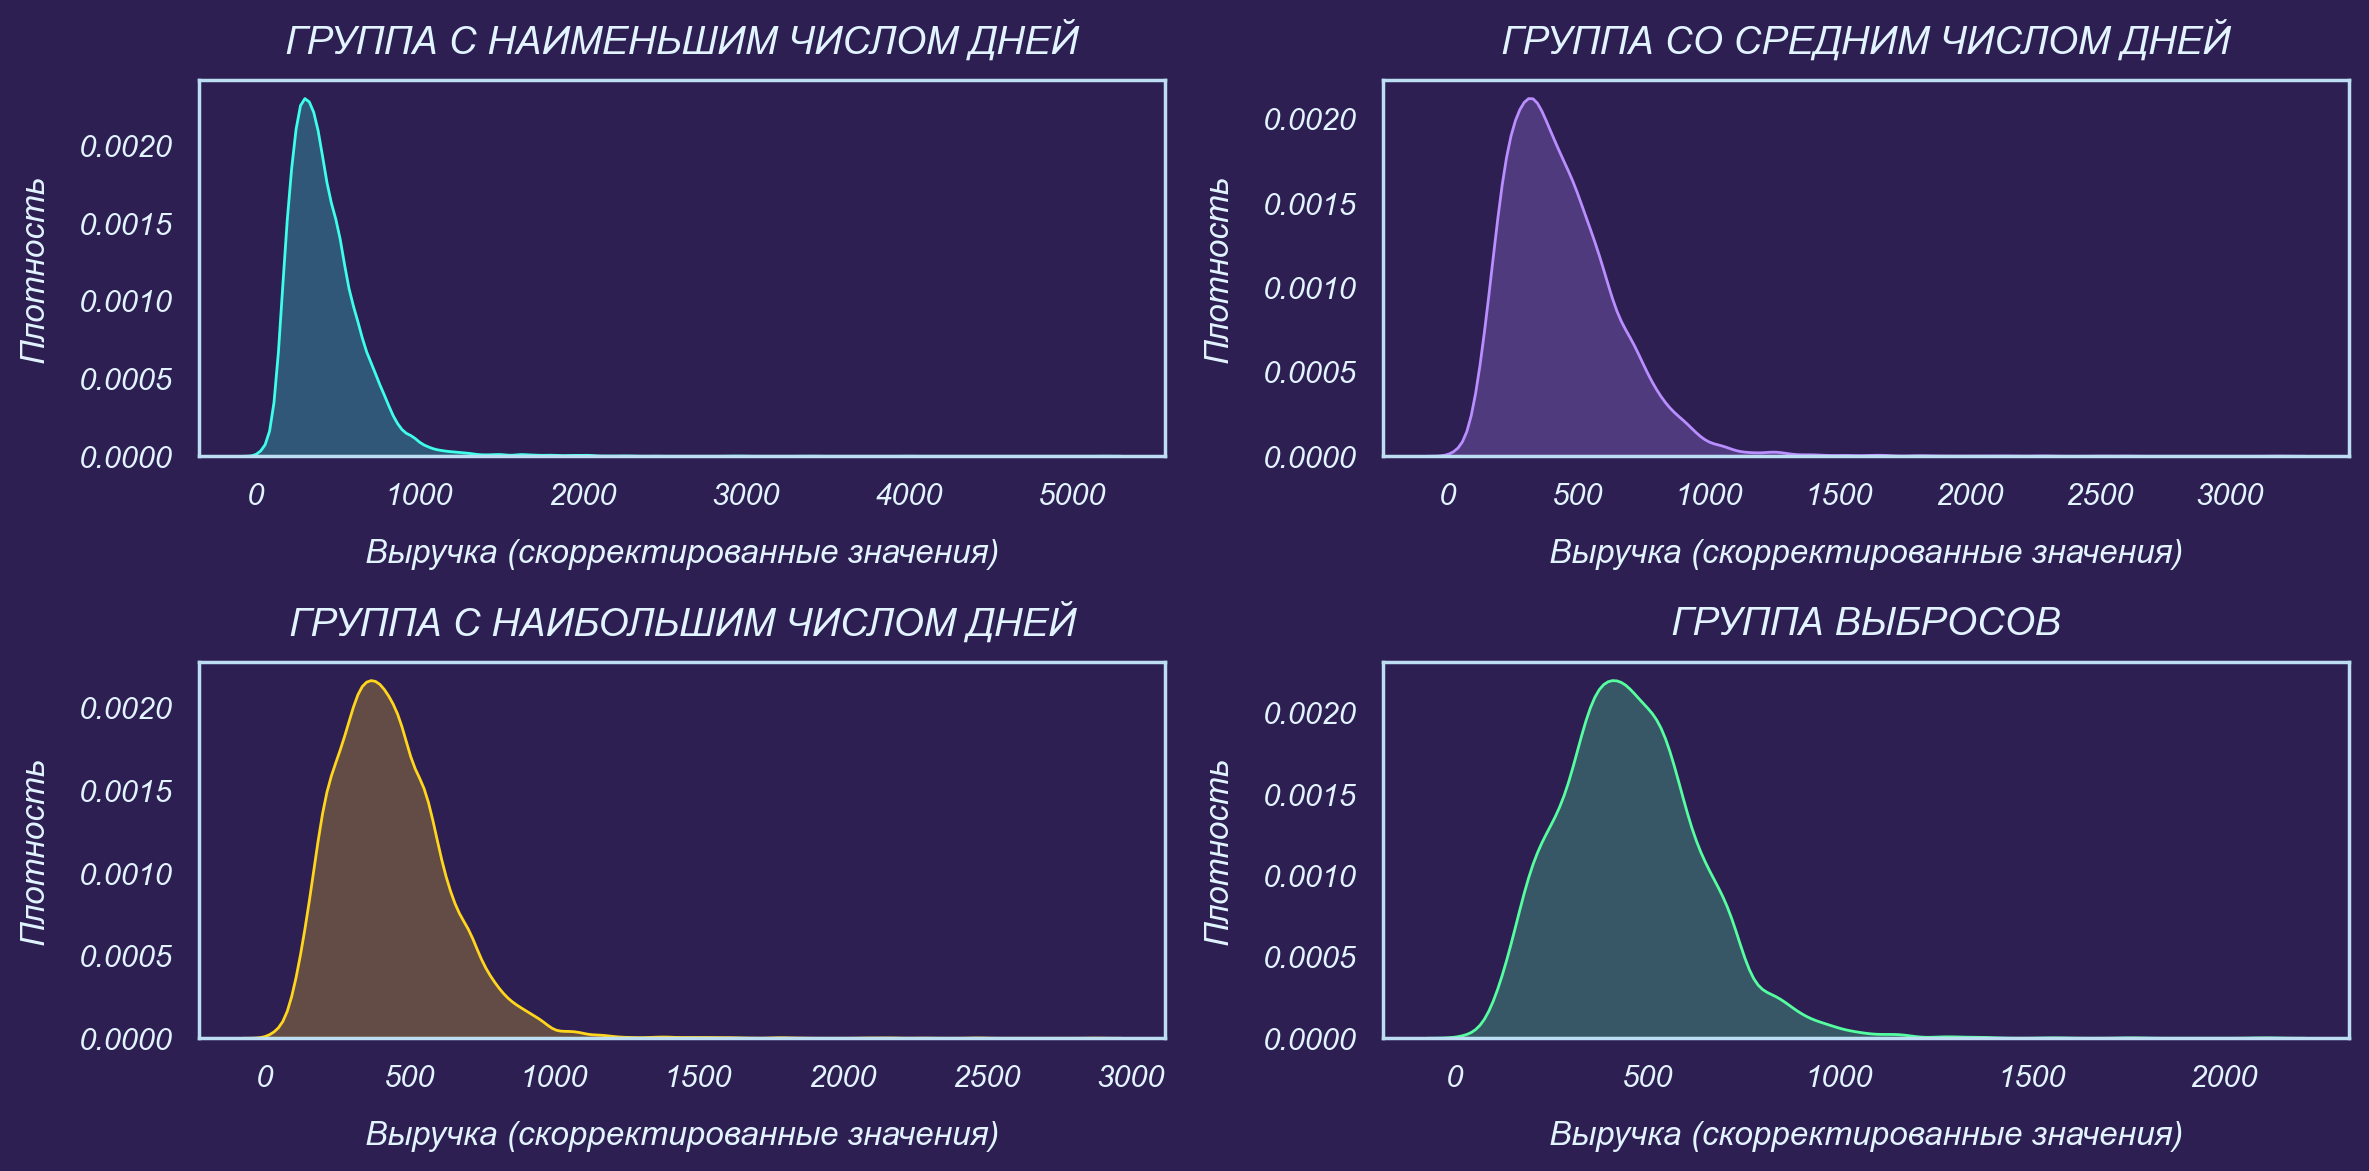

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.kdeplot(data=short['revenue'], fill=True, ax=axes[0, 0], color='#3dffe8').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[0, 0].set_title('ГРУППА С НАИМЕНЬШИМ ЧИСЛОМ ДНЕЙ')

sns.kdeplot(data=medium['revenue'], fill=True, ax=axes[0, 1], color='#b98eff').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[0, 1].set_title('ГРУППА СО СРЕДНИМ ЧИСЛОМ ДНЕЙ')

sns.kdeplot(data=long['revenue'], fill=True, ax=axes[1, 0], color='#ffd61c').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[1, 0].set_title('ГРУППА С НАИБОЛЬШИМ ЧИСЛОМ ДНЕЙ')

sns.kdeplot(data=extreme_long['revenue'], fill=True, ax=axes[1, 1], color='#55ffa0').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[1, 1].set_title('ГРУППА ВЫБРОСОВ')

plt.tight_layout()
plt.show()

Во всех группах выручка не имеет нормального распределения, во всех группах график плотности асимметричен.      
Используем преобразование Бокса-Кокса.

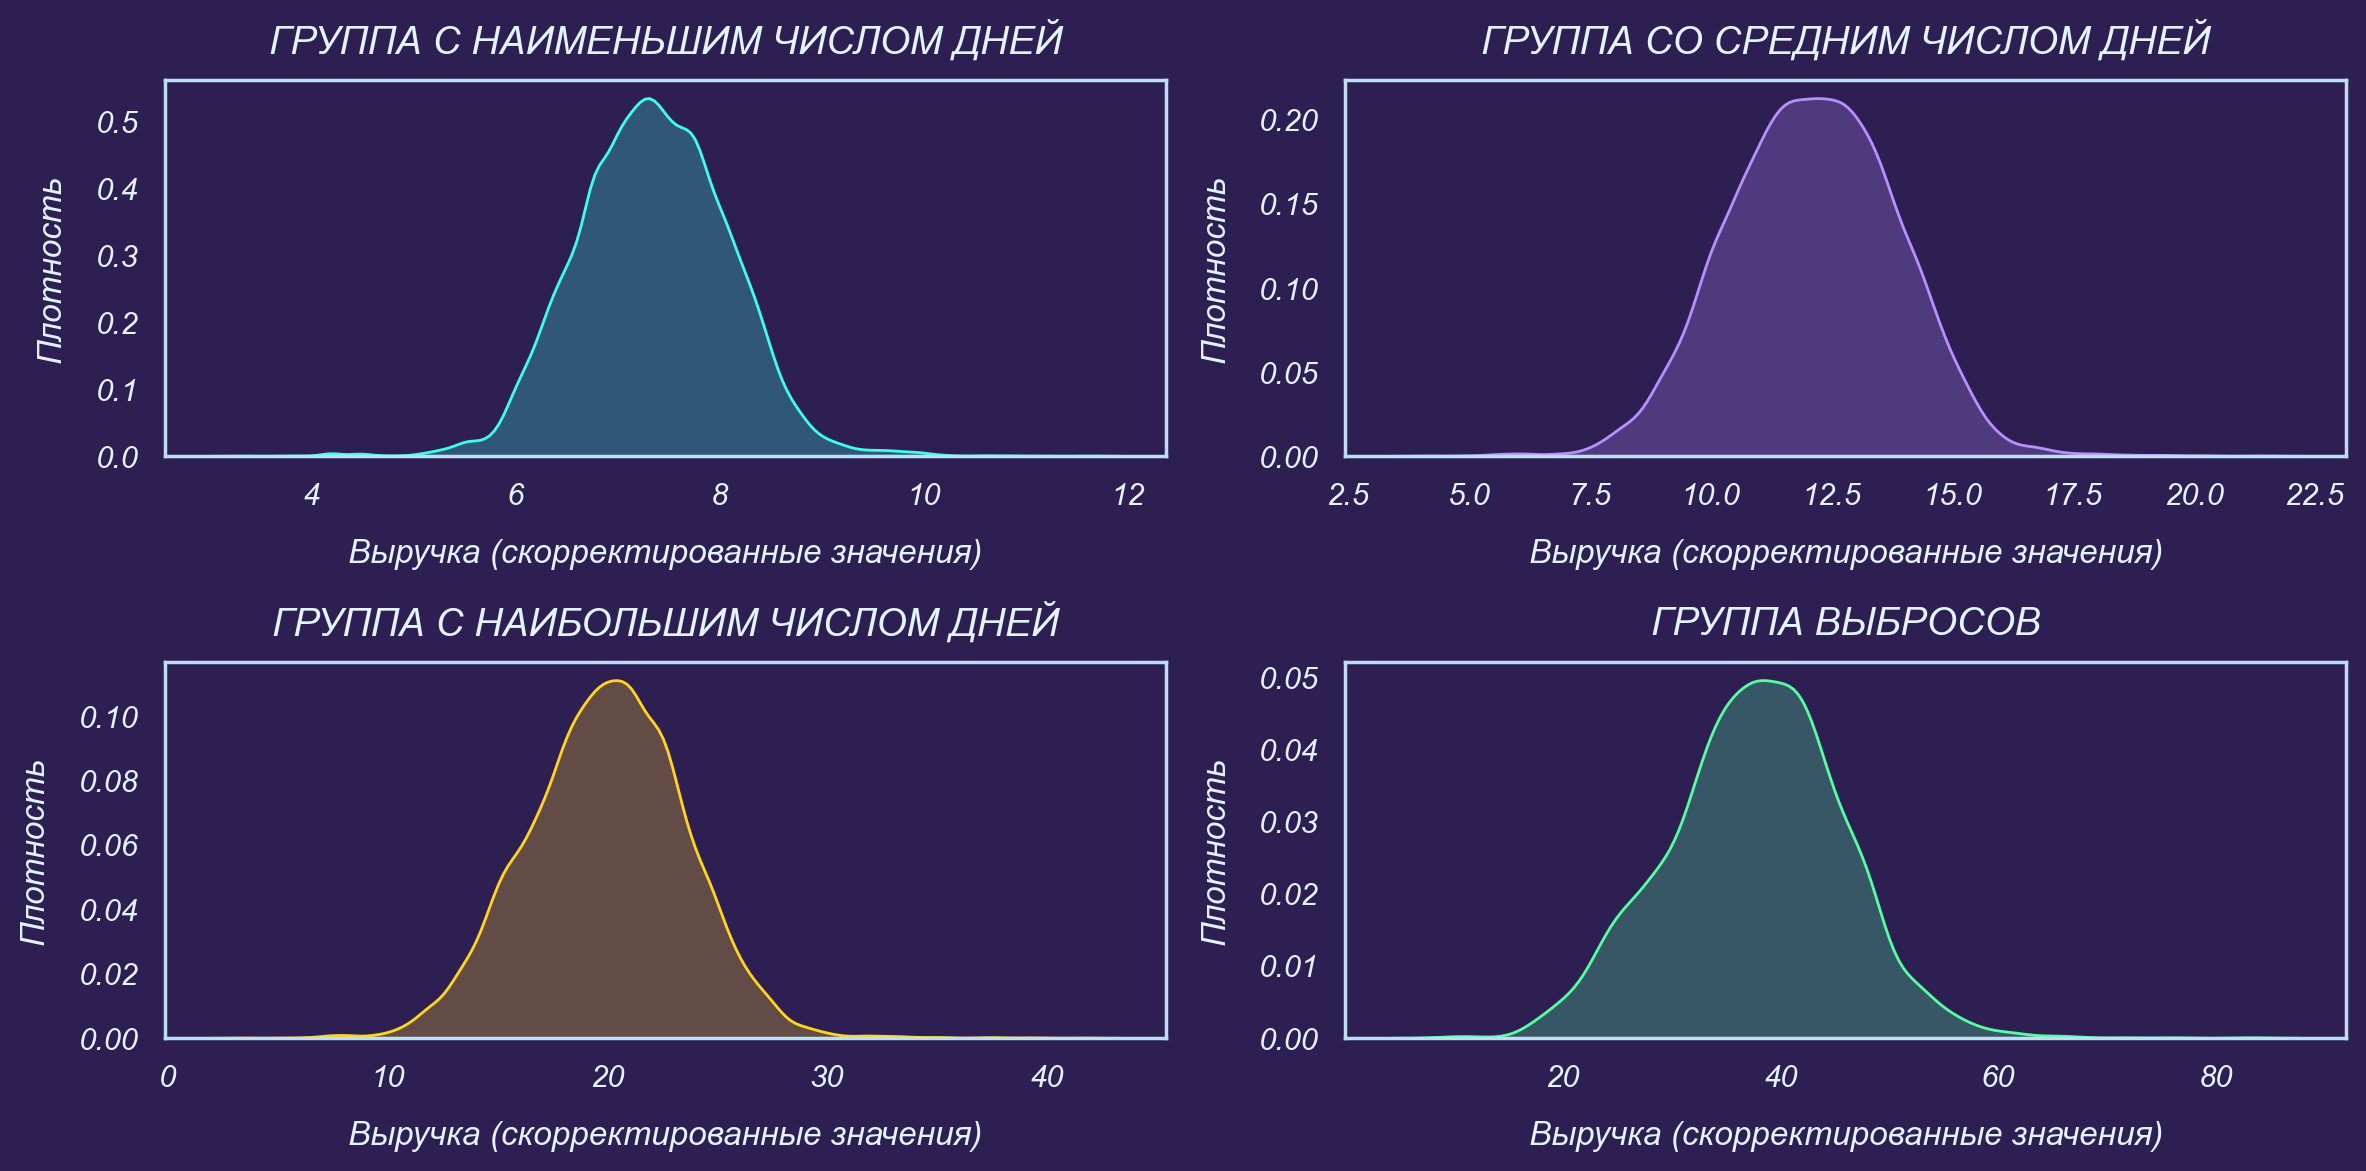

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.kdeplot(data=st.boxcox(short['revenue'])[0], fill=True, ax=axes[0, 0], color='#3dffe8').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[0, 0].set_title('ГРУППА С НАИМЕНЬШИМ ЧИСЛОМ ДНЕЙ')

sns.kdeplot(data=st.boxcox(medium['revenue'])[0], fill=True, ax=axes[0, 1], color='#b98eff').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[0, 1].set_title('ГРУППА СО СРЕДНИМ ЧИСЛОМ ДНЕЙ')

sns.kdeplot(data=st.boxcox(long['revenue'])[0], fill=True, ax=axes[1, 0], color='#ffd61c').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[1, 0].set_title('ГРУППА С НАИБОЛЬШИМ ЧИСЛОМ ДНЕЙ')

sns.kdeplot(data=st.boxcox(extreme_long['revenue'])[0], fill=True, ax=axes[1, 1], color='#55ffa0').set(
            xlabel='Выручка (скорректированные значения)',
            ylabel='Плотность')
axes[1, 1].set_title('ГРУППА ВЫБРОСОВ')

plt.tight_layout()
plt.show()

Кажется, что графики стали больше походить на нормальное распределение. Посмотрим подробнее.

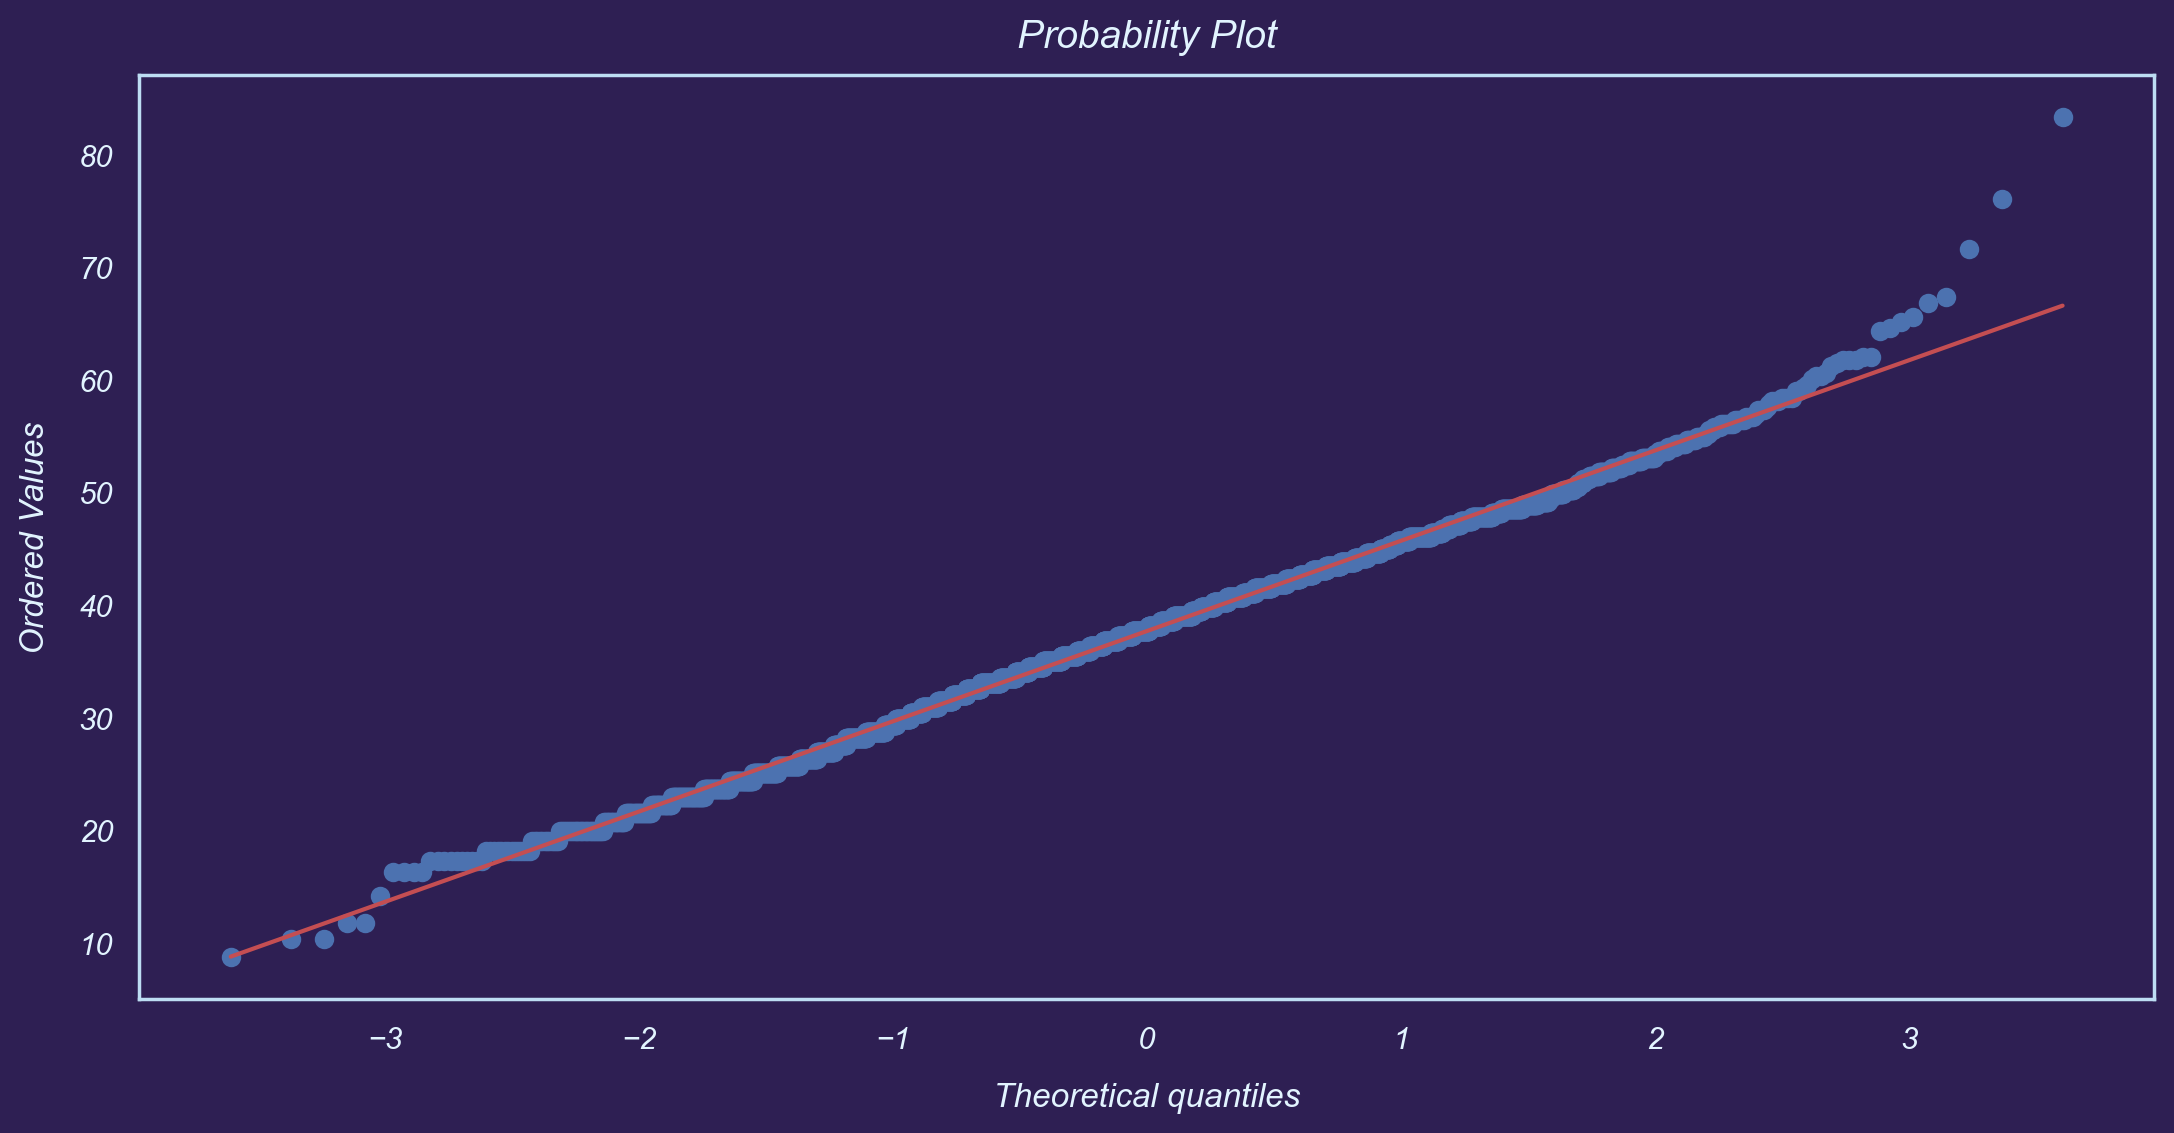

In [94]:
st.probplot(st.boxcox(extreme_long['revenue'])[0], dist='norm', plot=plt)
plt.show()

Появилась надежда, что данные могут быть распределены нормально. Проведем тест Шапиро-Уилка

In [95]:
# наблюдений должно быть <5000
len(extreme_long)

4457

In [96]:
extreme_long['revenue_boxcox'] = st.boxcox(extreme_long['revenue'])[0]

In [97]:
# проводила еще тесты с таким преобразованием, не получилось
#extreme_long['revenue_boxcox'] = np.log(extreme_long['revenue']+70)

In [98]:
# H0 = выручка в этой группе имеет нормальное распределение
# H1 = выручка не имеет нормального распределения
# alpha = 0.05

result = st.shapiro(extreme_long['revenue_boxcox'])
alpha = 0.05 
print(f'Выручка в этой группе не имеет нормального распределения, p-value = {result.pvalue}' if result.pvalue < alpha else 
      f'Выручка в этой группе нормально распределена, p-value = {result.pvalue}')

Выручка в этой группе не имеет нормального распределения, p-value = 1.386741080332349e-09


В других группах число наблюдей гораздо больше чем 5000, провести тест Шапиро-Уилка не получится.    
Можно поделить все данные на большее число групп, чтобы в каждой было меньше 5000 наблюдей, но тогда групп получится 10 (?). Скорее всего, это не будет иметь большого смысла. Вот почему:

In [99]:
print(len(df.query('gap==1')), len(df.query('gap==2')), len(df.query('gap==3')))

4041 3763 3306


Если делить группы размером меньше 5000 по количеству дней, то, например, первые две группы получатся группами, содержащими в разных пропорциях только строки с количеством дней равными 1 и 2. Кажется, будто дальнейшие сравнения подобных групп будут бесмыссленными.    

Таким образом, получили, что данные в группах не распределены нормально, провести t-тест не получится. Можно провести тест Манна-Уитни.

[Вернуться к навигации](#0)

### Тест Манна-Уитни <a class="anchor" id="25"></a>

Во всех тестах гипотезы и уровень стат. значимости будут следующими:
1. H0 = между распределением выручки в группах нет различия       
H1 = между распределением выручки в группах есть различия.
2. Уровень статистической значимости: alpha = 0.05    
При p-value < alpha отвергаем H0.

#### Проверки различий между каждой парой групп

In [162]:
alpha = 0.05

In [167]:
result = st.mannwhitneyu(short['revenue'], medium['revenue'], use_continuity=False)
print('Сравниваем 2 группы: с наименьшим числом дней и средним числом дней')
print(f'Между распределениями выручки в этих группах есть различия, p-value = {result.pvalue}' if result.pvalue < alpha else 
      f'Между распределениям выручки в этих группах нет различий, p-value = {result.pvalue}')

Сравниваем 2 группы: с наименьшим числом дней и средним числом дней
Между распределениями выручки в этих группах есть различия, p-value = 1.1616143776904907e-06


In [168]:
result = st.mannwhitneyu(short['revenue'], long['revenue'], use_continuity=False)
print('Сравниваем 2 группы: с наименьшим числом дней и наибольшим числом дней')
print(f'Между распределениями выручки в этих группах есть различия, p-value = {result.pvalue}' if result.pvalue < alpha else 
      f'Между распределениям выручки в этих группах нет различий, p-value = {result.pvalue}')

Сравниваем 2 группы: с наименьшим числом дней и наибольшим числом дней
Между распределениями выручки в этих группах есть различия, p-value = 2.4229969591213163e-14


In [169]:
result = st.mannwhitneyu(short['revenue'], extreme_long['revenue'], use_continuity=False)
print('Сравниваем 2 группы: с наименьшим числом дней и группу с выбросами')
print(f'Между распределениями выручки в этих группах есть различия, p-value = {result.pvalue}' if result.pvalue < alpha else 
      f'Между распределениям выручки в этих группах нет различий, p-value = {result.pvalue}')

Сравниваем 2 группы: с наименьшим числом дней и группу с выбросами
Между распределениями выручки в этих группах есть различия, p-value = 1.5427977366931402e-43


In [170]:
result = st.mannwhitneyu(medium['revenue'], long['revenue'], use_continuity=False)
print('Сравниваем 2 группы: со средним числом дней и наибольшим числом дней')
print(f'Между распределениями выручки в этих группах есть различия, p-value = {result.pvalue}' if result.pvalue < alpha else 
      f'Между распределениям выручки в этих группах нет различий, p-value = {result.pvalue}')

Сравниваем 2 группы: со средним числом дней и наибольшим числом дней
Между распределениям выручки в этих группах нет различий, p-value = 0.08461723402707089


In [174]:
result = st.mannwhitneyu(medium['revenue'], extreme_long['revenue'], use_continuity=False)
print('Сравниваем 2 группы: со средним числом дней и группой выбросов')
print(f'Между распределениями выручки в этих группах есть различия, p-value = {result.pvalue}' if result.pvalue < alpha else 
      f'Между распределениям выручки в этих группах нет различий, p-value = {result.pvalue}')

Сравниваем 2 группы: со средним числом дней и группой выбросов
Между распределениями выручки в этих группах есть различия, p-value = 7.419786890336154e-21


In [173]:
result = st.mannwhitneyu(long['revenue'], extreme_long['revenue'], use_continuity=False)
print('Сравниваем 2 группы: с наибольшим числом дней и группой выбросов')
print(f'Между распределениями выручки в этих группах есть различия, p-value = {result.pvalue}' if result.pvalue < alpha else 
      f'Между распределениям выручки в этих группах нет различий, p-value = {result.pvalue}')

Сравниваем 2 группы: с наибольшим числом дней и группой выбросов
Между распределениями выручки в этих группах есть различия, p-value = 8.916797620073336e-19


#### Результаты проверки

Между распределением всех групп есть различия. Кроме распределения стоимости билетов в группах со средним и наибольшим количеством дней.    
Т.е. в целом, выручка формируется по разному для покупок, совершенных за разное число дней до даты полета.   
Проверим корреляцию между выручкой и числом дней до даты полета во всех группах.

In [106]:
corr_result = short.corr(method='spearman')
corr_result.columns = ['Выручка', 'Число дней до даты полета']
corr_result.index = ['Выручка', 'Число дней до даты полета']
corr_result

Выручка  Число дней до даты полета
Выручка                    1.000000                   0.063379
Число дней до даты полета  0.063379                   1.000000

In [107]:
corr_result = medium.corr(method='spearman')
corr_result.columns = ['Выручка', 'Число дней до даты полета']
corr_result.index = ['Выручка', 'Число дней до даты полета']
corr_result

Выручка  Число дней до даты полета
Выручка                    1.000000                   0.003832
Число дней до даты полета  0.003832                   1.000000

In [108]:
corr_result = long.corr(method='spearman')
corr_result.columns = ['Выручка', 'Число дней до даты полета']
corr_result.index = ['Выручка', 'Число дней до даты полета']
corr_result

Выручка  Число дней до даты полета
Выручка                    1.000000                   0.013925
Число дней до даты полета  0.013925                   1.000000

In [109]:
corr_result = extreme_long[['revenue', 'gap']].corr(method='spearman')
corr_result.columns = ['Выручка', 'Число дней до даты полета']
corr_result.index = ['Выручка', 'Число дней до даты полета']
corr_result

Выручка  Число дней до даты полета
Выручка                    1.00000                    0.03849
Число дней до даты полета  0.03849                    1.00000

Во всех группах результаты получились очень низкими, что показывает слабую связь между стоимостью билета и количеством дней между датой покупки и датой полета. 

[Вернуться к навигации](#0)

## Самые популярные направления перелета <a class="anchor" id="26"></a>

#### Загрузка справочника, запись недостающих значений <a class="anchor" id="27"></a>

In [111]:
# Загрузим файл с информацией про аэропорты
airports = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', header = None)
len(airports)

7698

In [112]:
# В файле нет заголовков, восстановим их
airports.columns = ['id', 'name', 'city', 'country', 'iata_code', 'icao_code', 'lat', 'lon', 'altitude', 'timezone', 'dst', 'region', 'type', 'source']

In [113]:
# Удалим столбцы, которые нам не понадобятся
airports = airports[['name', 'city', 'country', 'iata_code', 'lat', 'lon']].copy()

In [114]:
airports.head(3)

name         city           country iata_code  \
0                Goroka Airport       Goroka  Papua New Guinea       GKA   
1                Madang Airport       Madang  Papua New Guinea       MAG   
2  Mount Hagen Kagamuga Airport  Mount Hagen  Papua New Guinea       HGU   

       lat         lon  
0 -6.08169  145.391998  
1 -5.20708  145.789001  
2 -5.82679  144.296005

Было обнаружено, что не все значения из столбцов с указанием аэропортов в оригинальном датасете содержатся в справочнике.

In [115]:
# для поиска информации из справочника по коду ИАТА
def find_info(iata_code, column):
    try:
        return airports[airports['iata_code']==iata_code][f'{column}'].values[0]
    except:
        return f'no info for {iata_code}'

In [116]:
find_info('MOW', 'name')

'no info for MOW'

Например, код MOW.
> MOW, Moscow city code, refers to the Moscow metropolitan area, including five primary commercial airports: Sheremetyevo (SVO), Domodedovo (DME), Vnukovo (VKO), Zhukovsky (ZIA), Ostafyevo (OSF).

Посмотрим, какие еще значения не включает в себя справочник.

In [117]:
all_codes = np.union1d(df['airport_from'].unique(), df['airport_to'].unique())

In [118]:
list_codes = []
for code in all_codes:
    if len(airports[airports['iata_code']==code]) == 0:
        list_codes.append(code)
print(list_codes)

['BAK', 'BER', 'BJS', 'GRV', 'LON', 'MIL', 'MOW', 'NQZ', 'OHH', 'PAR', 'ROM', 'SEL', 'TOX', 'TYO']


Почти все коды, которые не нашлись в справочнике, являются кодами, объединяющими несколько аэропоротов в городе.   
Если оставить все как есть, то при составлении таблицы самых популярных направлений могут получиться неверные результаты. Группировать нужно будет по названию города, а не аэропорта, а поле с городом, после объединения нашего датасета и справочника, в таких строках, скорее всего, будет пустым. Так, например, Москва может и не попасть в итоговую таблицу популярных направлений.   

Можно, конечно, группировать не по названию города, а по кодам аэропортов из оригинального датасета, но тогда MOW, DME, VKO, SVO будут считаться отдельно, а не вместе. Может быть, в нашем датасете и нет аэропортов DME, VKO, SVO, а только MOW, тогда все в порядке.

In [119]:
len(df.query('airport_from == "DME"')) + len(df.query('airport_from == "VKO"')) 
+ len(df.query('airport_from == "SVO"')) + len(df.query('airport_from == "ZIA"')) 
+ len(df.query('airport_from == "OSF"'))

0

В датасете действительно не встречаются эти коды, только общее MOW, так что действительно можно сделать группировку по кодам аэропортов вылета и прилета, и таким образом найти самые частые направления перелета. 
Однако, нам все равно понадобятся данные для кодов, которых нет в справочнике, такие как название города, координаты (для отображения на карте), поэтому более правильным решением здесь будет такая последовательность действий:
1. Дополняем справочник недостающими строками или создаем второй справочник только для городов;
2. Объединяем справочник и исходный датасет;
3. Создаем две таблицы для определения самых популярных перелетов, причем ищем по названиям городов, а не по кодам аэропортов.

In [175]:
# был найден в интернете и дополнен вручную список городов и кодов ИАТА
additional = pd.read_csv('citycodes.csv', sep=',')
additional = additional[['name', 'city', 'state', 'code', 'latitude', 'longitude']]
additional.columns = ['name', 'city', 'country', 'iata_code', 'lat', 'lon']

In [121]:
additional.head(3)

name            city       country iata_code  \
0            Baku Metropolitan Area            Baku    Azerbaijan       BAK   
1          Berlin Metropolitan Area          Berlin       Germany       BER   
2  Belo Horizonte Metropolitan Area  Belo Horizonte  Minas Gerais       BHZ   

         lat        lon  
0  40.395278  49.882222  
1  52.520008  13.404954  
2 -19.916667 -43.933333

In [122]:
for code in list_codes:
    if len(additional[additional['iata_code']==code]) == 0:
        print(f'Не нашли {code}!!!')
    else:
        print(f'Нашли {code}', end=', ')

Нашли BAK, Нашли BER, Нашли BJS, Нашли GRV, Нашли LON, Нашли MIL, Нашли MOW, Нашли NQZ, Нашли OHH, Нашли PAR, Нашли ROM, Нашли SEL, Нашли TOX, Нашли TYO, 

Все недостающие коды содержатся в дополнительном справочнике, отлично!     
Объединим справочник и дополнительный справочник для того, чтобы потом было легче внести новые данные в исходный датафрейм df.

In [123]:
airports_info = pd.concat([airports, additional], axis=0)

In [124]:
# Посмотрим сколько строк было в датасете до добавления новых столбцов 
len(df)

49362

In [125]:
df = df.merge(airports_info[['city', 'iata_code']], left_on='airport_from', right_on='iata_code')
df = df.merge(airports_info[['city', 'iata_code']], left_on='airport_to', right_on='iata_code', suffixes=('_from', '_to'))
df = df.drop(['iata_code_from', 'iata_code_to'], axis=1)
df.head(2)

purchase_date flight_date  adult  revenue airport_from airport_to  local  \
0    2021-12-07  2022-01-11      1      200          MOW        KGD      1   
1    2021-12-04  2022-01-07      0      180          MOW        KGD      1   

   loyalty  online purchase_weekday flight_weekday  purchase_month  \
0        0       1          Вторник        Вторник              12   
1        0       1          Суббота        Пятница              12   

   flight_month purchase_season flight_season  gap city_from      city_to  
0             1            Зима          Зима   35    Moscow  Kaliningrad  
1             1            Зима          Зима   34    Moscow  Kaliningrad

In [126]:
# Посмотрим сколько строк осталось в датасете после добавления столбцов
len(df)

49362

Ни одна строка не потерялась, отлично!

[Вернуться к навигации](#0)

#### Рейтинг направлений перелета <a class="anchor" id="28"></a>

Так как самые частые связки городов будут дублироваться (Москва-Сочи и Сочи-Москва), возьмем городов больше чем 10, чтобы было интересно потом отобразить эти маршруты на карте.

In [127]:
size = 40

In [128]:
top_local = df.query('local==1').groupby(['city_from', 'city_to']).agg({'revenue': 'sum', 'purchase_date': 'count'}).reset_index()
top_local.columns = ['city_from_name', 'city_to_name', 'revenue', 'count']
top_local = top_local.sort_values('count', ascending=False).head(size)

top_intern = df.query('local==0').groupby(['city_from', 'city_to']).agg({'revenue': 'sum', 'purchase_date': 'count'}).reset_index()
top_intern.columns = ['city_from_name', 'city_to_name', 'revenue', 'count']
top_intern = top_intern.sort_values('count', ascending=False).head(size)

In [129]:
# Дополним таблицы информацией о городах
top_local = top_local.merge(airports_info[['lat', 'lon', 'country', 'city']], left_on='city_from_name', right_on='city')
top_local = top_local.merge(airports_info[['lat', 'lon', 'country', 'city']], left_on='city_to_name', right_on='city',suffixes=('_from', '_to'))
top_local = top_local[['city_from', 'country_from', 'lat_from', 'lon_from', 'city_to','country_to', 'lat_to', 'lon_to', 'revenue', 'count']]
top_local = top_local.drop_duplicates(subset=['city_from', 'city_to']).reset_index(drop=True)

top_intern = top_intern.merge(airports_info[['lat', 'lon', 'country', 'city']], left_on='city_from_name', right_on='city')
top_intern = top_intern.merge(airports_info[['lat', 'lon', 'country', 'city']], left_on='city_to_name', right_on='city',suffixes=('_from', '_to'))
top_intern = top_intern[['city_from', 'country_from', 'lat_from', 'lon_from', 'city_to','country_to', 'lat_to', 'lon_to', 'revenue', 'count']]
top_intern = top_intern.drop_duplicates(subset=['city_from', 'city_to']).reset_index(drop=True)

In [130]:
top_local.head(10)

city_from country_from   lat_from    lon_from city_to country_to  \
0            Sochi       Russia  43.449902   39.956600  Moscow     Russia   
1   St. Petersburg       Russia  59.800301   30.262501  Moscow     Russia   
2      Novosibirsk       Russia  55.012600   82.650703  Moscow     Russia   
3            Kazan       Russia  55.606201   49.278702  Moscow     Russia   
4              Ufa       Russia  54.557499   55.874401  Moscow     Russia   
5           Samara       Russia  53.504902   50.164299  Moscow     Russia   
6      Kaliningrad       Russia  54.889999   20.592600  Moscow     Russia   
7  Mineralnye Vody       Russia  44.225101   43.081902  Moscow     Russia   
8             Omsk       Russia  54.966999   73.310501  Moscow     Russia   
9         Ulan-ude       Russia  51.807800  107.438004  Moscow     Russia   

      lat_to   lon_to  revenue  count  
0  55.972599  37.4146   534530   1341  
1  55.972599  37.4146   282110   1212  
2  55.972599  37.4146   467540    972  
3  55.972599  37.4146   206390    760  
4  55.972599  37.4146   207900    652  
5  55.972599  37.4146   164150    573  
6  55.972599  37.4146   161500    474  
7  55.972599  37.4146   170350    470  
8  55.972599  37.4146   191930    446  
9  55.972599  37.4146   262480    410

Любопытно, что Санкт-Петербург - Москва находится не на первом месте, а только на втором.    
В целом, Москва ожидамо находится в списке самых популярных направлений.

In [131]:
top_intern.head(10)

city_from country_from   lat_from   lon_from          city_to  \
0       Moscow       Russia  55.972599  37.414600              Osh   
1  Novosibirsk       Russia  55.012600  82.650703              Osh   
2       Moscow       Russia  55.972599  37.414600        Khudzhand   
3  Novosibirsk       Russia  55.012600  82.650703        Khudzhand   
4       Moscow       Russia  55.972599  37.414600          Antalya   
5       Moscow       Russia  55.972599  37.414600  Sharm El Sheikh   
6       Moscow       Russia  55.972599  37.414600         Hurghada   
7       Moscow       Russia  55.972599  37.414600          Minsk 2   
8       Moscow       Russia  55.972599  37.414600          Bourgas   
9       Moscow       Russia  55.972599  37.414600            Dubai   

             country_to     lat_to     lon_to  revenue  count  
0            Kyrgyzstan  40.609001  72.793297    72100    154  
1            Kyrgyzstan  40.609001  72.793297    51930    122  
2            Tajikistan  40.215401  69.694702    58750    130  
3            Tajikistan  40.215401  69.694702    37030     90  
4                Turkey  36.898701  30.800501    46900    107  
5                 Egypt  27.977301  34.395000    24690     45  
6                 Egypt  27.178301  33.799400    23390     45  
7               Belarus  53.882500  28.030701     9330     32  
8              Bulgaria  42.569599  27.515200     9770     28  
9  United Arab Emirates  25.252800  55.364399    16540     27

Самыми частыми направлениями перелета среди международних рейсов стали перелеты из Москвы и Новосибирска в Ош (Кыргызстан) и Худжанд (Таджикистан). Скорее всего, это пассажиры, которые совершают регулярные поездки от места, где они находятся по причине работы, до мест, где проживает их семья. 
Так же популярными направлениями заграницей стали Турция, Египет, Болгария, ОАЭ, что не удивительно - это типичные туристические направления, т.е. большую часть топ-10 направлений международних рейсов занимают направления, куда пассажиры едут на отдых.

[Вернуться к навигации](#0)

#### Cамые частые направления перелета на карте <a class="anchor" id="29"></a>

In [132]:
# создадим карту (в качестве начальных координат выбрана Москва)
m = folium.Map(location=(55.972599, 37.414600), zoom_start=4)

In [133]:
# добавление маркера на карту
def add_marker(loc, name, color, info):
    folium.Marker(location=loc, # кортеж широта, долгота
                  tooltip=name, # всплывающее окошко при наведении на маркер
                  popup=info, # всплывающее окошко при клике на маркер
                  icon=folium.Icon(color=color, icon="plane"),
                  ).add_to(m)

#добавление линии на карту
def add_connection(points, color, info):
    folium.PolyLine(points, color=color, tooltip=info).add_to(m)

# добавление маршрутов на карту
# df содержит следующие столбцы в таком порядке: 
# ['city_from', 'country_from', 'lat_from', 'lon_from', 'city_to','country_to', 'lat_to', 'lon_to', 'revenue', 'count']]
def add_df(df, color):
    
    # нужно для того, чтобы дополнять информацию 
    # по маршрутам между одинаковыми городами 
    # но в разные направления
    routes = dict()
    
    for i in range(len(df)):
        
        list = df.iloc[i, :].to_list()
        
        city_from = list[0]
        country_from = list[1]
        city_to = list[4]
        country_to = list[5]

        loc_from = tuple([list[2], list[3]])
        loc_to = tuple([list[6], list[7]])
    
        info_city_from = f'{city_from}, {country_from}'
        info_city_to = f'{city_to}, {country_to}'
        info_connection = f'#{i+1} по популярности: перелет {city_from}, {country_from} -> {city_to}, {country_to}'

        # если по этому направлению уже была запись,
        # нам нужно ее тоже нанести на карту вместе с новой записью
        if tuple([loc_from, loc_to]) in routes:
            old_info = routes[tuple([loc_from, loc_to])]
            info_connection = old_info + ', ' + info_connection 
        else:
            routes[tuple([loc_to, loc_from])] = info_connection
        
        add_marker(loc_from, city_from, color, info_city_from)
        add_marker(loc_to, city_to, color, info_city_to)
        add_connection((loc_from, loc_to), color, info_connection)   


In [134]:
add_df(top_local, 'green')
add_df(top_intern, 'orange')

Зелеными на карте отмечены полеты внутри страны, оранжевым отмечены международные полеты. При наведении на прямую, соединяющую два города, можно увидеть на каком месте по популярности находится этот маршрут в обоих направлениях.

In [135]:
m

[Вернуться к навигации](#0)

#### Исследуем выручку для самых популярных направлений <a class="anchor" id="30"></a>

Посмотрим какой процент выручки на себя "забирают" самые популярные направления в каждом сегменте (внутренние и международные рейсы)

In [136]:
sum_local = top_local['revenue'].sum()
sum_intern = top_intern['revenue'].sum()
top_local['revenue_perc'] = round(top_local['revenue'] / sum_local * 100, 2)
top_intern['revenue_perc'] = round(top_intern['revenue'] / sum_intern * 100, 2)

In [137]:
# добавим накапливающиеся суммы для процентов
top_local['revenue_perc_cum'] = top_local['revenue_perc'].cumsum()
top_intern['revenue_perc_cum'] = top_intern['revenue_perc'].cumsum()

In [138]:
top_local.head(5)

city_from country_from   lat_from   lon_from city_to country_to  \
0           Sochi       Russia  43.449902  39.956600  Moscow     Russia   
1  St. Petersburg       Russia  59.800301  30.262501  Moscow     Russia   
2     Novosibirsk       Russia  55.012600  82.650703  Moscow     Russia   
3           Kazan       Russia  55.606201  49.278702  Moscow     Russia   
4             Ufa       Russia  54.557499  55.874401  Moscow     Russia   

      lat_to   lon_to  revenue  count  revenue_perc  revenue_perc_cum  
0  55.972599  37.4146   534530   1341          5.99              5.99  
1  55.972599  37.4146   282110   1212          3.16              9.15  
2  55.972599  37.4146   467540    972          5.24             14.39  
3  55.972599  37.4146   206390    760          2.31             16.70  
4  55.972599  37.4146   207900    652          2.33             19.03

In [139]:
top_intern.head(5)

city_from country_from   lat_from   lon_from    city_to  country_to  \
0       Moscow       Russia  55.972599  37.414600        Osh  Kyrgyzstan   
1  Novosibirsk       Russia  55.012600  82.650703        Osh  Kyrgyzstan   
2       Moscow       Russia  55.972599  37.414600  Khudzhand  Tajikistan   
3  Novosibirsk       Russia  55.012600  82.650703  Khudzhand  Tajikistan   
4       Moscow       Russia  55.972599  37.414600    Antalya      Turkey   

      lat_to     lon_to  revenue  count  revenue_perc  revenue_perc_cum  
0  40.609001  72.793297    72100    154          6.43              6.43  
1  40.609001  72.793297    51930    122          4.63             11.06  
2  40.215401  69.694702    58750    130          5.24             16.30  
3  40.215401  69.694702    37030     90          3.30             19.60  
4  36.898701  30.800501    46900    107          4.18             23.78

In [140]:
top_local.loc[9, 'revenue_perc_cum'], top_intern.loc[9, 'revenue_perc_cum']

(29.68, 31.249999999999996)

Получается, 29.7% всей выручки от прождажи билетов на внутренние рейсы и 31.2% выручки от продажи билетов на международные рейсы было получено от продажи билетов на топ-10 самых популярных направлений в своем сегменте. 

In [141]:
top_local.loc[19, 'revenue_perc_cum'], top_intern.loc[19, 'revenue_perc_cum']

(53.37, 61.160000000000004)

Топ-20 самых популярных направлений генерируют уже 53.4% и 61% соответственно, что показывает, что по направлениям выручка распределена очень неравномерно.    
Построим столбчатую диаграмму выручки по самым популярным направлениям перелета, для этого нам придется все же ввести дополнительный столбец с указанием направления перелета.

In [142]:
top_local['route'] = top_local['city_from'] + ' ->\n' + top_local['city_to']
top_intern['route'] = top_intern['city_from'] + ' ->\n' + top_intern['city_to']

In [143]:
top_local.head(1)

city_from country_from   lat_from  lon_from city_to country_to     lat_to  \
0     Sochi       Russia  43.449902   39.9566  Moscow     Russia  55.972599   

    lon_to  revenue  count  revenue_perc  revenue_perc_cum             route  
0  37.4146   534530   1341          5.99              5.99  Sochi ->\nMoscow

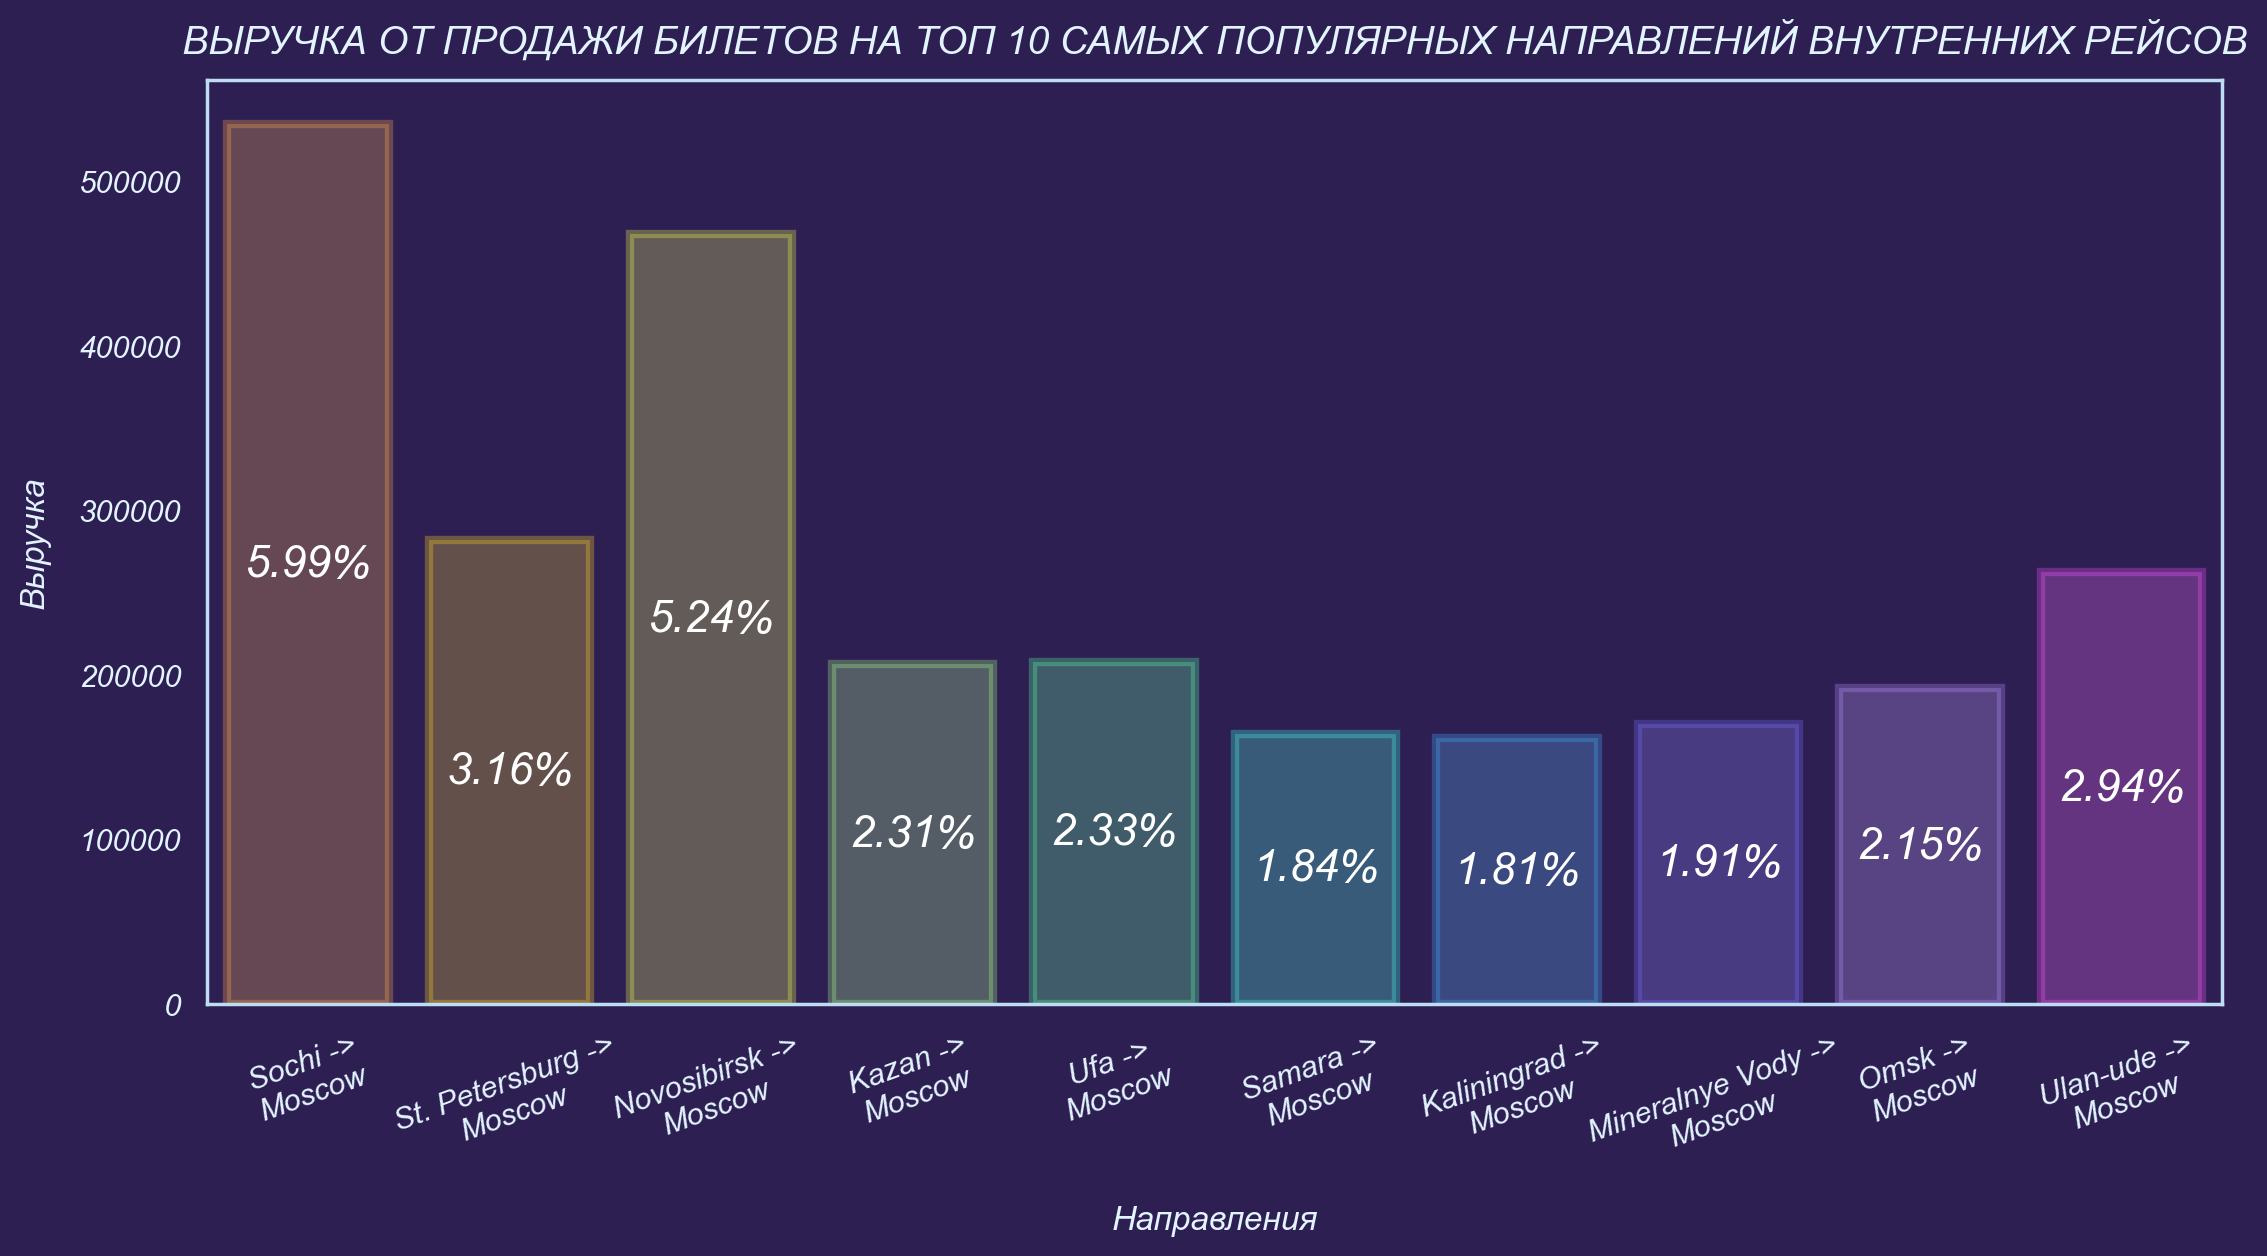

In [144]:
ax = sns.barplot(data=top_local.head(10), x='route', y = 'revenue',
            edgecolor=big_palette, 
            linewidth=3,
            #hatch = ['//', '\\\\', '|',  '-', '//',
            #         '\\\\', '-', '//', '-', '\\\\'],
                    #'|', '//', '\\\\', '-', '|',
                    #'\\\\', '//', '-', '|', '//'],
            alpha=0.3
           )
ax.set(
                title='ВЫРУЧКА ОТ ПРОДАЖИ БИЛЕТОВ НА ТОП 10 САМЫХ ПОПУЛЯРНЫХ НАПРАВЛЕНИЙ ВНУТРЕННИХ РЕЙСОВ',
                xlabel='Направления',
                ylabel='Выручка')
ax.bar_label(ax.containers[0], 
             labels=[f'{c}%' for c in top_local.head(10)['revenue_perc']],
             label_type='center',
             color='w',
             fontsize=16)
plt.xticks(rotation=20) 
plt.show()

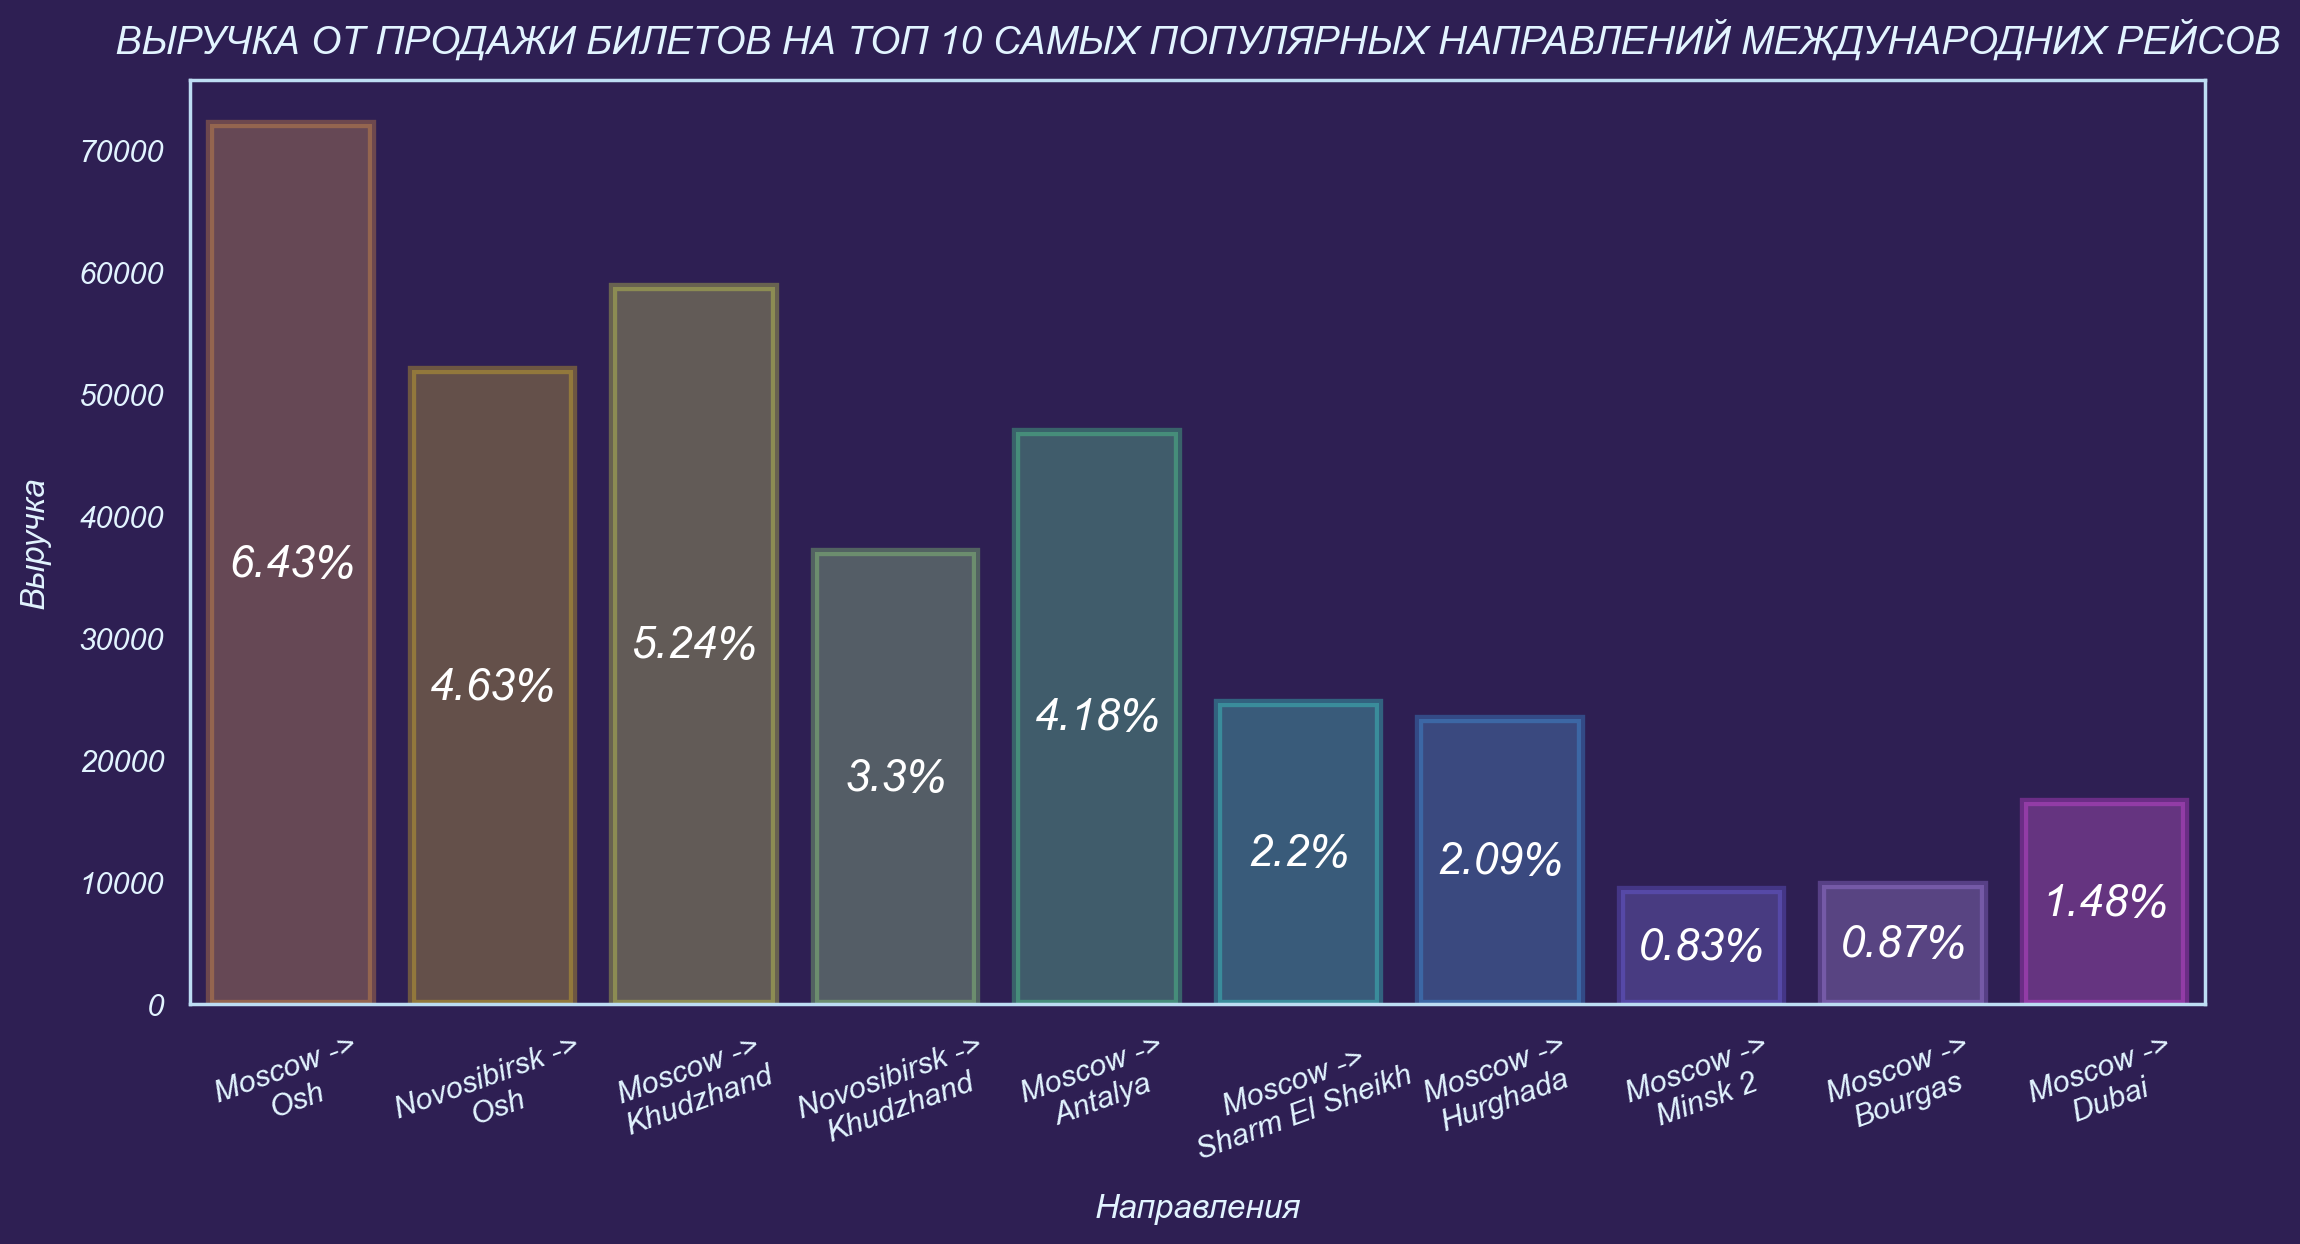

In [145]:
ax = sns.barplot(data=top_intern.head(10), x='route', y = 'revenue',
            edgecolor=big_palette, 
            linewidth=3,
            alpha=0.3
           )
ax.set(
                title='ВЫРУЧКА ОТ ПРОДАЖИ БИЛЕТОВ НА ТОП 10 САМЫХ ПОПУЛЯРНЫХ НАПРАВЛЕНИЙ МЕЖДУНАРОДНИХ РЕЙСОВ',
                xlabel='Направления',
                ylabel='Выручка')
ax.bar_label(ax.containers[0], 
             labels=[f'{c}%' for c in top_intern.head(10)['revenue_perc']],
             label_type='center',
             color='w',
             fontsize=16)
plt.xticks(rotation=20) 
plt.show()

## Матрица корреляций <a class="anchor" id="31"></a>

In [146]:
matrix_corr = df[['revenue', 'local', 'loyalty', 'online', 'purchase_month', 'flight_month']].corr()
matrix_corr.columns = ['Выручка', 'Тип рейса', 'Программа лояльности', 'Тип покупки (онлайн/офлайн)', 'Месяц покупки', 'Месяц полета']
matrix_corr.index = ['Выручка', 'Тип рейса', 'Программа лояльности', 'Тип покупки (онлайн/офлайн)', 'Месяц покупки', 'Месяц полета']
matrix_corr

Выручка  Тип рейса  Программа лояльности  \
Выручка                      1.000000  -0.100767             -0.046345   
Тип рейса                   -0.100767   1.000000              0.159557   
Программа лояльности        -0.046345   0.159557              1.000000   
Тип покупки (онлайн/офлайн) -0.162313   0.102862              0.320530   
Месяц покупки               -0.054422  -0.074864             -0.003249   
Месяц полета                 0.027697  -0.025654             -0.021154   

                             Тип покупки (онлайн/офлайн)  Месяц покупки  \
Выручка                                        -0.162313      -0.054422   
Тип рейса                                       0.102862      -0.074864   
Программа лояльности                            0.320530      -0.003249   
Тип покупки (онлайн/офлайн)                     1.000000      -0.011982   
Месяц покупки                                  -0.011982       1.000000   
Месяц полета                                   -0.030624       0.688594   

                             Месяц полета  
Выручка                          0.027697  
Тип рейса                       -0.025654  
Программа лояльности            -0.021154  
Тип покупки (онлайн/офлайн)     -0.030624  
Месяц покупки                    0.688594  
Месяц полета                     1.000000

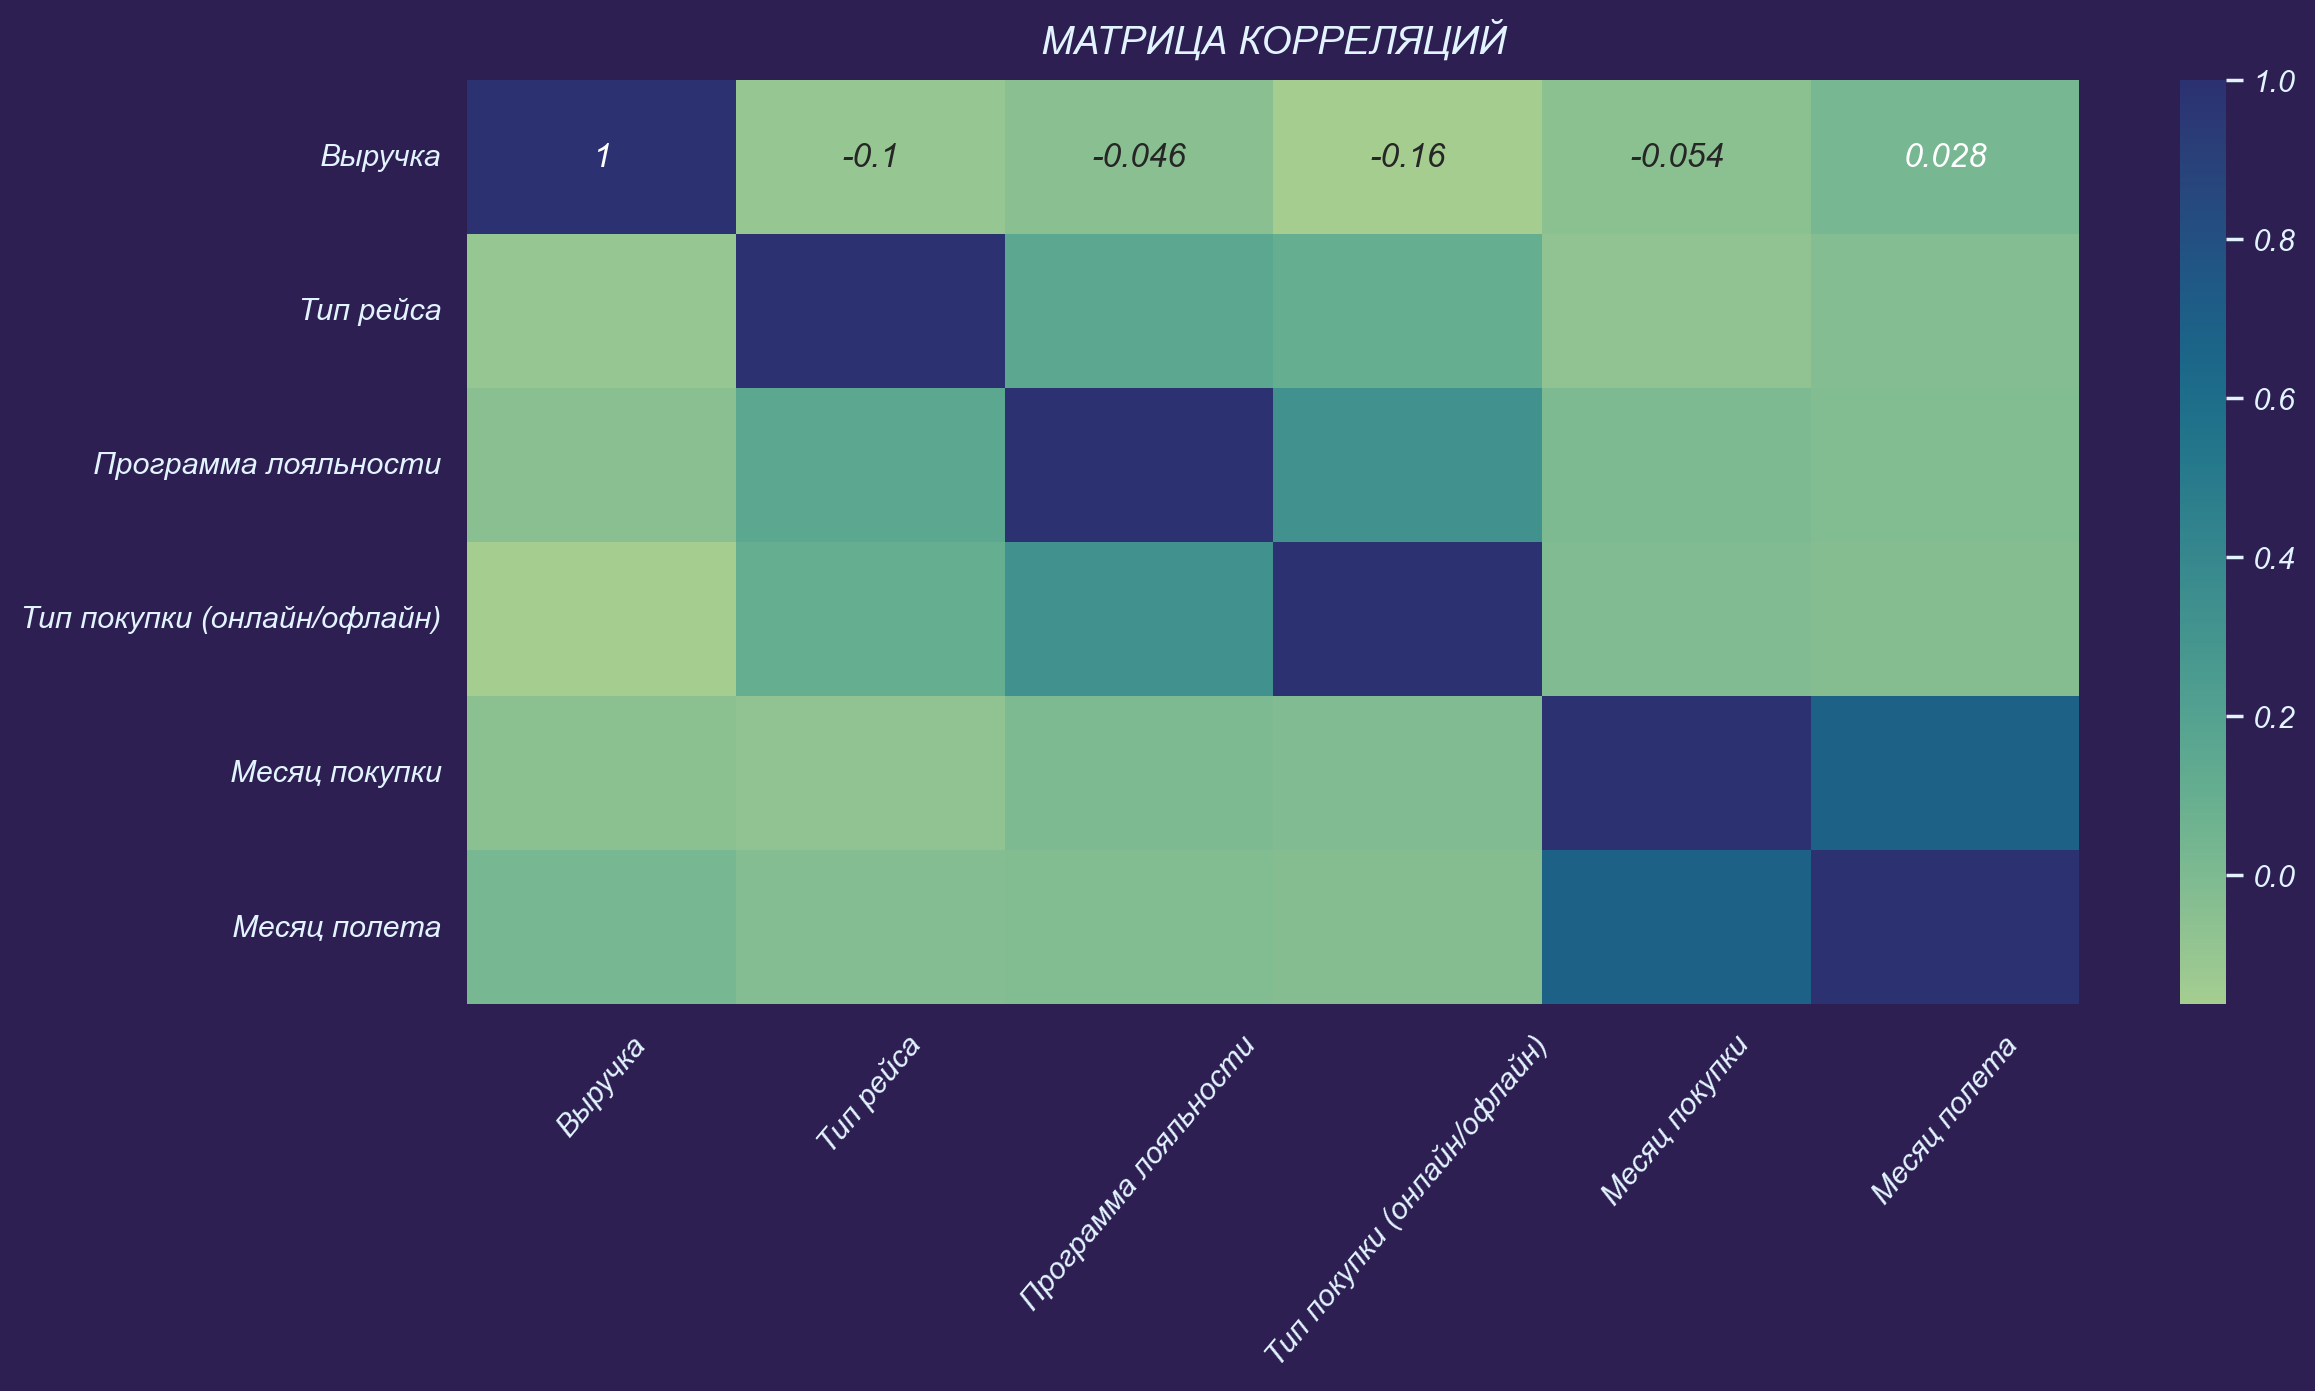

In [147]:
sns.heatmap(matrix_corr, annot=True, cmap="crest").set(title='МАТРИЦА КОРРЕЛЯЦИЙ')
plt.xticks(rotation=50) 
plt.show()

По тепловой карте можно сделать следующие выводы: коэффициенты получились отрицательными для всех полей кроме месяца полета (хотя отдельный вопрос насколько имеет смысл находить коэффициенты корреляции для выручки и номера месяца, в котором будет совершен полет). Фактически, матрица корреляций показала довольно слабую связь между объемом выручки и параметрами билетов. 

Коэффициент корреляции показывает изменение результата при изменении признака, поэтому выглядит нелогичным находить коэффициент корреляции между выручкой и месяцем. Как мы видели выше на графиках, не существует ситуации при которой выручка бы росла/уменьшалась бы от роста/увеличения номера месяца, поэтому мне кажется, что это не имеет смысла.    
Гораздо интереснее вспомнить, что в первых пунктах мы наблюдали разницу между выручкой в будние, и в выходные. Считать коэффициент корреляции для номера дня недели и выручки как будто тоже будет нелогично, поэтому лучше введем бинарную переменную. Столбец с названием weekday уже был, возьмем название workday. Выходные? 0. Будни? 1.

In [148]:
workday = {'Понедельник': 1, 'Вторник': 1, 'Среда': 1, 'Четверг': 1, 'Пятница': 1, 'Суббота': 0, 'Воскресенье': 0}

In [149]:
df['purchase_workday'] = df['purchase_weekday'].map(workday)

In [150]:
df.head(2)

purchase_date flight_date  adult  revenue airport_from airport_to  local  \
0    2021-12-07  2022-01-11      1      200          MOW        KGD      1   
1    2021-12-04  2022-01-07      0      180          MOW        KGD      1   

   loyalty  online purchase_weekday flight_weekday  purchase_month  \
0        0       1          Вторник        Вторник              12   
1        0       1          Суббота        Пятница              12   

   flight_month purchase_season flight_season  gap city_from      city_to  \
0             1            Зима          Зима   35    Moscow  Kaliningrad   
1             1            Зима          Зима   34    Moscow  Kaliningrad   

   purchase_workday  
0                 1  
1                 0

In [151]:
workday_corr = df[['revenue', 'purchase_workday']].corr(method='spearman')
workday_corr.columns = ['Выручка', 'Будний день / Выходной']
workday_corr.index= ['Выручка', 'Будний день / Выходной']
workday_corr

Выручка  Будний день / Выходной
Выручка                 1.000000                0.025675
Будний день / Выходной  0.025675                1.000000

In [152]:
# (т.к. одна переменная принимает значения либо 0, либо 1, 
# нужно использовать точечно-бисериальный коэффициент корреляции
# но и он не показал сильной связи
st.pointbiserialr(df['revenue'], df['purchase_workday'])

SignificanceResult(statistic=0.029153077163175348, pvalue=9.275231820909462e-11)

Получили тоже довольно маленький коэффциент, что свидетельствует о слабой связи.

## Общие выводы <a class="anchor" id="32"></a>

Что было сделано:
* Данные были обработаны для работы с ними: удалены пропуски, проверены дубликаты, преобразованы значения в некоторых столбцах
* Исследована выручка за весь период, выручка по сезонам, месяцам, по дням недели, по сроку между датой покупки и датой полета. К сожалению, выручка из датасета не распределена нормально, поэтому при сравнении выручки по различным критериям нельзя было использовать t-тесты.
* Проанализированны самые популярные направления перелета среди международных и внутренних рейсов.